/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Norm stats (0.31651841229383865, 0.3892599391249885)
torch.Size([2, 9, 120, 120])


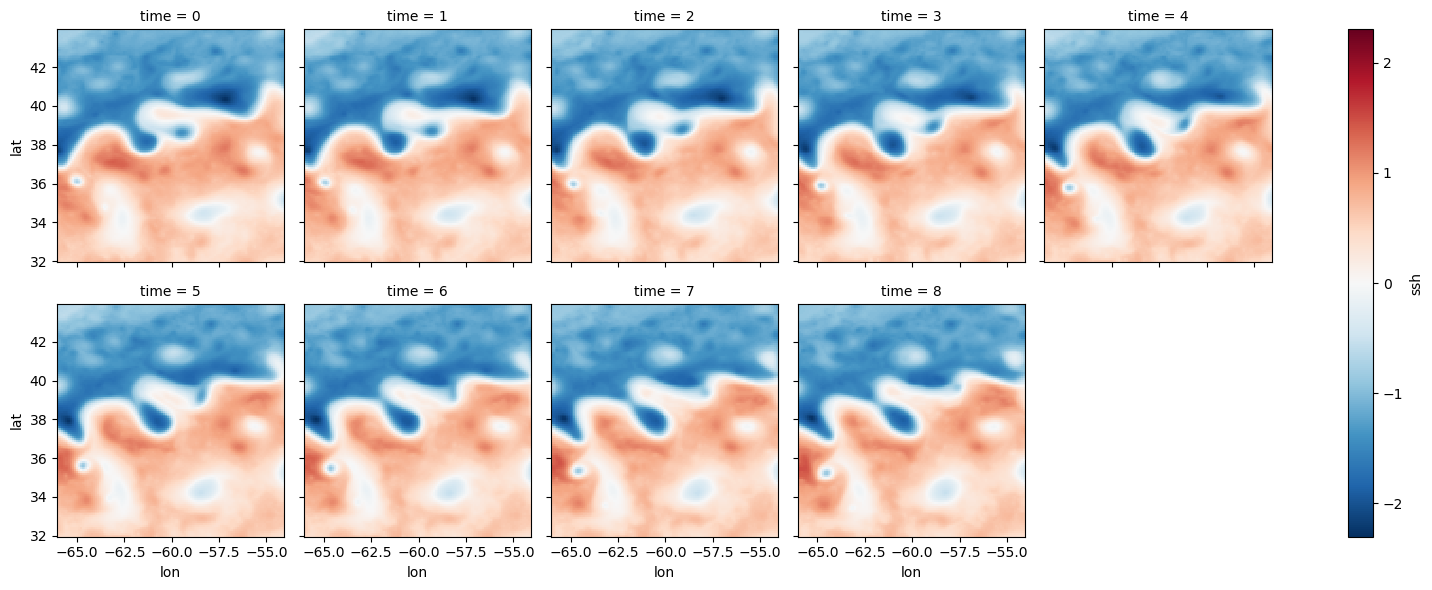

In [1]:
import sys
sys.path.append('..')
from src.data_notebook import *
from src.utils import *
from src.models import *
from contrib.IMT.SPDE.lit_model_spde import *
from contrib.IMT.SPDE.models_spde import *
#from contrib.IMT.SPDE.solver import *
#from contrib.IMT.SPDE.unet import *

def spspmm(A,B):
    return torch.sparse.mm(A,B)

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66 
lon_max = -54
#lon_max = -63
lat_min = 32
lat_max = 44
#lat_max = 35


datamodule = BaseDataModule(input_da=load_altimetry_data("/Odyssey/private/m19beauc/IMT/data/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-17', '2012-12-07',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 120, 'lon': 120},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2, grad=False)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(9),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

# Define the solver

In [2]:
### import pandas as pd
import einops
from pathlib import Path
import pytorch_lightning as pl
import kornia.filters as kfilts
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GradSolver_Lgv(nn.Module):
    def __init__(self, nll, grad_mod, n_step, lr_grad=0.2, **kwargs):
        super().__init__()
        self.nll = nll
        self.grad_mod = grad_mod
        self.n_step = n_step
        self.lr_grad = lr_grad
        self._grad_norm = None        
 
    def init_state(self, x_init=None):
        
        kappa_init = torch.sum(torch.abs(kfilts.spatial_gradient(x_init,normalized=True)),dim=2)
        kappa_init = torch.max(kappa_init)-kappa_init+.01
        tau_init = torch.sum(torch.abs(kfilts.spatial_gradient(x_init,normalized=True)),dim=2)+.01
        m1_init = kfilts.spatial_gradient(x_init,normalized=True)[:,:,0,:,:]
        m2_init = kfilts.spatial_gradient(x_init,normalized=True)[:,:,1,:,:]
        vx_init = kfilts.spatial_gradient(x_init,order=1,normalized=True)[:,:,0,:,:]
        vy_init = kfilts.spatial_gradient(x_init,order=1,normalized=True)[:,:,1,:,:]
        gamma_init = torch.ones(x_init.size()).to(device)
        beta_init = torch.ones(x_init.size()).to(device)
        state_init =  torch.cat((kappa_init,
                                tau_init,
                                m1_init,
                                m2_init,
                                vx_init,
                                vy_init,
                                gamma_init,
                                beta_init),dim=1).requires_grad_(True)
        return state_init

            
    def solver_step(self, state, batch, step):
        device = state.device
        n_b, n_t, n_y, n_x = batch.input.shape
        grad_logp = torch.nanmean(self.nll(batch.input, state, det=True))
        print(grad_logp)
        if torch.isnan(grad_logp):
            return None
        grad = torch.autograd.grad(grad_logp, state, create_graph=True)[0]
             
        gmod = self.grad_mod(grad)
        state_update = (
            1 / (step + 1) * gmod
                + self.lr_grad * (step + 1) / self.n_step * grad
        )
        state_update = 1 / (step + 1) * gmod

        res = state - state_update #+ noise
        
        # constrain theta
        idx_kappa = torch.arange(0,n_t)
        idx_tau = torch.arange(n_t,2*n_t)
        idx_m1 = torch.arange(2*n_t,3*n_t)
        idx_m2 = torch.arange(3*n_t,4*n_t)
        idx_vx = torch.arange(4*n_t,5*n_t)
        idx_vy = torch.arange(5*n_t,6*n_t)
        idx_gamma = torch.arange(6*n_t,7*n_t)
        idx_beta = torch.arange(7*n_t,8*n_t)
            
        kappa = res[:,idx_kappa,:,:]
        tau = res[:,idx_tau,:,:]
        m1 = res[:,idx_m1,:,:]
        m2 = res[:,idx_m2,:,:]
        vx = res[:,idx_vx,:,:]
        vy = res[:,idx_vy,:,:]
        gamma = res[:,idx_gamma,:,:]
        beta = res[:,idx_beta,:,:]
        # parameters: gamma > 0
        gamma =  F.relu(gamma)+.01
        res = torch.index_add(res,1,idx_gamma.to(device),-1*res[:,idx_gamma,:,:])
        res = torch.index_add(res,1,idx_gamma.to(device),gamma)
        # parameters: beta > 0
        beta =  F.relu(beta)+.01  
        res = torch.index_add(res,1,idx_beta.to(device),-1*res[:,idx_beta,:,:])
        res = torch.index_add(res,1,idx_beta.to(device),beta)                 
        # parameters: kappa > 0
        kappa = F.relu(kappa)+.01
        res = torch.index_add(res,1,idx_kappa.to(device),-1*res[:,idx_kappa,:,:])
        res = torch.index_add(res,1,idx_kappa.to(device),kappa)
        # parameters: tau > 0
        tau = F.relu(tau)+.1
        res = torch.index_add(res,1,idx_tau.to(device),-1*res[:,idx_tau,:,:])
        res = torch.index_add(res,1,idx_tau.to(device),tau)            
            
        return res
        
    def forward(self, batch, x_init, mu=None, reshape_theta=True):

        device = batch.input.device
        n_t = batch.input.size(1)
        
        with torch.set_grad_enabled(True):
            state = self.init_state(x_init)
            self.grad_mod.reset_state(batch.input)

            for step in range(self.n_step):
                state = self.solver_step(state, batch, step=step)
                if state is None:
                    return None
                if not self.training:
                    state = state.detach().requires_grad_(True)

        theta = state

        if reshape_theta:
            kappa, m, H, tau = self.nll.reshape_params(theta)
            theta = [kappa, m, H, tau]
        
        return theta

class ConvLstmGradModel(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, dropout=0.1, downsamp=None):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.gates = torch.nn.Conv2d(
            dim_in + dim_hidden,
            4 * dim_hidden,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )

        self.dropout = torch.nn.Dropout(dropout)
        self.conv_out = torch.nn.Conv2d(
            dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self._state = []
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def reset_state(self, inp):
        size = [inp.shape[0], self.dim_hidden, *inp.shape[-2:]]
        self._grad_norm = None
        self._state = [
            self.down(torch.zeros(size, device=inp.device)),
            self.down(torch.zeros(size, device=inp.device)),
        ]

    def forward(self, x):
        if self._grad_norm is None:
            self._grad_norm = (x**2).mean().sqrt()
        x =  x / self._grad_norm
        hidden, cell = self._state
        x = self.dropout(x)
        x = self.down(x)
        gates = self.gates(torch.cat((x, hidden), 1))

        in_gate, remember_gate, out_gate, cell_gate = gates.chunk(4, 1)

        in_gate, remember_gate, out_gate = map(
            torch.sigmoid, [in_gate, remember_gate, out_gate]
        )
        cell_gate = torch.tanh(cell_gate)

        cell = (remember_gate * cell) + (in_gate * cell_gate)
        hidden = out_gate * torch.tanh(cell)

        self._state = hidden, cell
        out = self.conv_out(hidden)
        out = self.up(out)
        return out

# NLL

In [3]:
def sparse_eye(size, val = torch.tensor(1.0)):
    """
    Returns the identity matrix as a sparse matrix
    """
    indices = torch.arange(0, size).long().unsqueeze(0).expand(2, size).to(device)
    if len(val.size())==0:
        values = (val.expand(size)).to(device)
    else:
        values = val.to(device)
    cls = getattr(torch.sparse, values.type().split(".")[-1])
    return cls(indices, values, torch.Size([size, size])).to(device)

def sparse_repeat(size,n1,n2):
    """
    Returns a sparse zero-filled tensor repeating 
    a 2D size*size sparse zero-filled tensor
    n1 times along dim1 and n2 times along n2
    """
    return torch.sparse.LongTensor(size*n1,size*n2).to(device)


class Encoder(torch.nn.Module):

    def __init__(self,shape_data):
        super(Encoder, self).__init__()
        self.n_t, self.n_y, self.n_x  = shape_data
        self.cnn = torch.nn.Conv2d(self.n_t,8*self.n_t,(3,3),padding=1,bias=False)

    def forward(self, x):
        # input shape (b,t,y,x) --> output shape (b,7*t,y,x)
        theta = self.cnn(x)
        # activation functions on some parameters
        return theta

class NLL_new(torch.nn.Module):

    def __init__(self, shape_data, st_lag=[1,1,1], pow=1, spde_type="adv_diff", scheme="FUDM1",crop=None, downsamp=None):

        super(NLL_new,self).__init__()
        self.spde_type = spde_type
        self.scheme = scheme
        self.pow = pow        
        self.crop = crop
        self.downsamp = downsamp
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )
        
        if crop is not None:
            shape_data = [shape_data[0],
                          shape_data[1]-self.crop,
                          shape_data[2]-self.crop]
            
        if downsamp is not None:
            shape_data = [shape_data[0],
                          shape_data[1]//self.downsamp,
                          shape_data[2]//self.downsamp] 
        
        self.encoder = Encoder(shape_data)
        
        self.operator_spde = Prior_SPDE(shape_data,st_lag,pow=self.pow,
                                        spde_type=self.spde_type,
                                        scheme=self.scheme)
        
    def custom_sigmoid(self,x,min,max):
        add_const = min/(max-min)
        mult_const = max-min
        return (torch.sigmoid(x)+add_const)*mult_const
        
    def reshape_params(self,theta):

        n_b, n_t, n_x, n_y = theta.shape
        n_t = theta.shape[1]//8

        # reshape the parameters
        kappa = theta[:,:n_t,:,:]
        tau = theta[:,n_t:2*n_t,:,:]
        m1 = theta[:,2*n_t:3*n_t,:,:]
        m2 = theta[:,3*n_t:4*n_t,:,:]
        vx = theta[:,4*n_t:5*n_t,:,:]
        vy = theta[:,5*n_t:6*n_t,:,:]
        gamma = theta[:,6*n_t:7*n_t,:,:]
        beta = theta[:,7*n_t:8*n_t,:,:]
        
        H = []
        for k in range(n_t):
            vx_ = torch.reshape(vx[:,k,:,:],(n_b,n_x*n_y))
            vy_ = torch.reshape(vy[:,k,:,:],(n_b,n_x*n_y))
            vxy = torch.stack([vx_,vy_],dim=2)
            vxyT = torch.permute(vxy,(0,2,1))
            gamma_ = torch.reshape(gamma[:,k,:,:],(n_b,n_x*n_y))
            beta_ = torch.reshape(beta[:,k,:,:],(n_b,n_x*n_y))
            H_ = torch.einsum('ij,bk->bijk',
                              torch.eye(2).to(device),
                              gamma_)+\
                 torch.einsum('bk,bijk->bijk',beta_,torch.einsum('bki,bjk->bijk',vxy,vxyT))
            H.append(H_)
        H = torch.stack(H,dim=4)
        m = torch.stack([m1,m2],dim=1)

        kappa = torch.permute(kappa,(0,2,3,1))
        tau = torch.permute(tau,(0,2,3,1))
        m = torch.permute(m,(0,1,3,4,2))
        H = torch.reshape(H,(n_b,2,2,n_x,n_y,n_t))
        H = torch.permute(H,(0,1,2,3,4,5))

        # reshaping n_x,n_y -> n_x*n_y
        kappa = torch.reshape(kappa,(n_b,1,n_y*n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y*n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y*n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y*n_x,n_t))

        #H = torch.full(H.shape,0.).to(device)
        return [kappa, m, H, tau]
    
    def downsamp_params(self, kappa, m, H, tau, sp_dims):
        
        n_b, _, nb_nodes, n_t = m.shape
        n_x, n_y = sp_dims
        
        kappa = torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y,n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y,n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))
        
        kappa = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(kappa[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)
        tau = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(tau[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)    
        m1 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(m[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m2 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(m[:,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m = torch.cat([m1,m2],dim=1)
        h11 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,0,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h12 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,0,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h22 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,1,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        H = torch.reshape(torch.cat([h11,h12,h12,h22],dim=1),(n_b,2,2,n_y//self.downsamp,n_x//self.downsamp,n_t))
        
        kappa = torch.reshape(kappa,(n_b,1,nb_nodes//(self.downsamp**2),n_t))
        tau = torch.reshape(tau,(n_b,1,nb_nodes//(self.downsamp**2),n_t))
        m = torch.reshape(m,(n_b,2,nb_nodes//(self.downsamp**2),n_t))
        H = torch.reshape(H,(n_b,2,2,nb_nodes//(self.downsamp**2),n_t))
        
        return kappa, m, H, tau
    
    def upsamp_params(self, kappa, m, H, tau, sp_dims):
        
        n_b, _, nb_nodes, n_t = m.shape
        n_x, n_y = sp_dims
        
        kappa = torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y,n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y,n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))
        
        kappa = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(kappa[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)
        tau = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(tau[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)    
        m1 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(m[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m2 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(m[:,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m = torch.cat([m1,m2],dim=1)
        h11 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,0,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h12 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,0,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h22 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,1,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        H = torch.reshape(torch.cat([h11,h12,h12,h22],dim=1),(n_b,2,2,int(n_y*self.downsamp),
                                                                      int(n_x*self.downsamp),n_t))

        kappa = torch.reshape(kappa,(n_b,1,int(nb_nodes*(self.downsamp**2)),n_t))
        tau = torch.reshape(tau,(n_b,1,int(nb_nodes*(self.downsamp**2)),n_t))
        m = torch.reshape(m,(n_b,2,int(nb_nodes*(self.downsamp**2)),n_t))
        H = torch.reshape(H,(n_b,2,2,int(nb_nodes*(self.downsamp**2)),n_t))
        
        return kappa, m, H, tau
    

    def forward(self, x, theta, mu=None, det=True):

        n_b, n_t, n_x, n_y = x.shape

        # compute the parameters
        if not isinstance(theta, list):
            kappa, m, H, tau = self.reshape_params(theta)
        else:
            kappa, m, H, tau = theta
        
        # compute Q(theta)
        if self.crop is not None:
            c = self.crop//2
            x = x[:,:,c:-c,c:-c]
            if mu is not None:
                mu = mu[:,:,c:-c,c:-c]
            kappa = torch.reshape(torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            tau = torch.reshape(torch.reshape(tau,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            m = torch.reshape(torch.reshape(m,(n_b,2,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            H = torch.reshape(torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))[:,:,:,c:-c,c:-c,:],
                                   (n_b,2,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            n_b, n_t, n_y, n_x = x.shape
            
        if self.downsamp is not None:
            kappa, m, H, tau = self.downsamp_params(kappa, m, H, tau, sp_dims=[n_y, n_x])
            
        Q, block_diag = self.operator_spde(kappa,
                                           m,
                                           H,
                                           tau,
                                           store_block_diag=True)
        
        # compute determinant(Q)
        if det==True:
            det_Q = list()
            for i in range(n_b):
                log_det = 0.
                for j in range(0,len(block_diag[i])):
                    BD = block_diag[i][j].to_dense().to(device)#.type(torch.LongTensor)
                    chol_block, info  = torch.linalg.cholesky_ex(BD)
                    if info!=0:
                        return torch.tensor([np.nan for _ in range(n_b)])
                    log_det_block =  2*torch.sum(\
                                         torch.log(\
                                         torch.diagonal(\
                                         chol_block,
                                         0)\
                                        )\
                                       )
                    log_det += log_det_block
                # log(det(Q^k)) = sum_k=1^p log(det(Q))
                #for _ in range(2,(2*self.pow)+1):
                #    log_det += log_det
                det_Q.append(log_det)

        # compute Mahanalobis distance xT.Q.x
        MD = list()
        for i in range(n_b):
            if self.downsamp is None:
                if mu is None:
                    MD_ = sp_mm(Q[i],torch.reshape(x[i],(n_t*n_x*n_y,1)))
                    MD_ = torch.matmul(torch.reshape(x[i],(1,n_t*n_x*n_y)),MD_)
                else:
                    MD_ = sp_mm(Q[i],torch.reshape(x[i]-mu[i],(n_t*n_x*n_y,1)))
                    MD_ = torch.matmul(torch.reshape(x[i]-mu[i],(1,n_t*n_x*n_y)),MD_)
            else:
                if mu is None:
                    MD_ = sp_mm(Q[i],torch.reshape(self.down(x)[i],(n_t*n_x*n_y//(self.downsamp**2),1)))
                    MD_ = torch.matmul(torch.reshape(self.down(x)[i],(1,n_t*n_x*n_y//(self.downsamp**2))),MD_)
                else:
                    MD_ = sp_mm(Q[i],torch.reshape(self.down(x)[i]-self.down(mu)[i],(n_t*n_x*n_y//(self.downsamp**2),1)))
                    MD_ = torch.matmul(torch.reshape(self.down(x)[i]-self.down(mu)[i],(1,n_t*n_x*n_y//(self.downsamp**2))),MD_)
            MD.append(MD_[0,0])

        # Negative log-likelihood
        if det==True:
            log_det = torch.stack(det_Q)
        MD = torch.stack(MD)

        # NLL is -log[p_theta(x)] has size (#batch,1)
        # GradNLL (with autodiff) will have same dim as x
        if det==True:
            NLL = -1.*(log_det - MD)
        else:
            NLL = -1.*MD
            
        if self.downsamp is not None:
            kappa, m, H, tau = self.upsamp_params(kappa, m, H, tau, sp_dims=[n_y//self.downsamp, n_x//self.downsamp])
            

        return NLL

In [4]:
device = 'cuda'

# state + param
crop_daw = 4
out_as_first_guess = True
solver = GradSolver_Lgv(n_step=5,
                      lr_grad=1e-3,
                      nll = NLL_new(shape_data=[datamodule.xrds_kw['patch_dims']['time']-crop_daw,120,120],
                                    st_lag=[1,1,1],
                                    pow=2./2, spde_type="adv_diff", 
                                    scheme="FUDM1", downsamp=None, crop=None),#10),
                      grad_mod = ConvLstmGradModel(dim_in=8*(datamodule.xrds_kw['patch_dims']['time']-crop_daw),
                                                   dim_hidden=244)).to(device)

# state only
solver2 = GradSolver(n_step=15,
                     lr_grad=1e-3,
                      prior_cost = BilinAEPriorCost(dim_in=9,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=9,dim_hidden=96)).to(device)

ckpt = torch.load('../ckpt/ckpt_spde_wonll_rzf=2.pth', map_location=device)
solver2.load_state_dict(ckpt)

<All keys matched successfully>

# Training (disjoint)

In [5]:
rec_weight = get_triang_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time']-2*crop_daw,
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)


def crop_batch(batch):
    cropped_batch = batch
    cropped_batch = cropped_batch._replace(input=(cropped_batch.input[:,crop_daw//2:-(crop_daw//2),:,:]).nan_to_num().to(device))
    cropped_batch = cropped_batch._replace(tgt=(cropped_batch.tgt[:,(crop_daw//2):-(crop_daw//2),:,:]).nan_to_num().to(device))
    return cropped_batch
    
def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.9:
        return None, None

    theta = base_step(batch)
    
    if theta is None:
        return None, None
    cropped_batch = crop_batch(batch)
    nll_loss = torch.nanmean(solver.nll(cropped_batch.tgt,
                                        theta = theta,
                                        det=True))
    if torch.isnan(nll_loss)==True:
        return None, None

    training_loss = nll_loss * 1e-6

    print(nll_loss*1e-6)
    
    return training_loss, theta

def base_step(batch):

    out = solver2(batch=batch)
    
    n_b, n_t, n_x,n_y = batch.tgt[:,crop_daw//2:-(crop_daw//2),:,:].shape

    cropped_batch = crop_batch(batch)
    cropped_batch = cropped_batch._replace(input=batch.tgt[:,crop_daw//2:-(crop_daw//2),:,:].to(device)-out[:,crop_daw//2:-(crop_daw//2),:,:]) ##
    theta = solver(batch=cropped_batch, 
                  x_init=cropped_batch.input,
                  reshape_theta=False)
        
    return theta
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [6]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

n_epochs =  50#@param {'type':'integer'}
lr = 1e-3 #@param {'type':'number'}
    
optimizer = torch.optim.Adam(
        [
            {"params": solver.parameters(), "lr": lr},
        ])


start = 0
ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2_supervised.pth', map_location=device)
solver.load_state_dict(ckpt)


tqdm_epoch = tqdm(range(start,start+n_epochs))
solver.training = True
for epoch in tqdm_epoch:
  print(epoch)
  ibatch=0
  tqdm_batch = tqdm(range(0,len(datamodule.train_dataloader())))
  for batch in tqdm_batch:
    batch = next(itertools.islice(datamodule.train_dataloader(), batch, None))
    batch = batch._replace(input=(batch.input).nan_to_num().to(device))
    batch = batch._replace(tgt=(batch.tgt).nan_to_num().to(device))
    loss, theta = step(batch)
    optimizer.zero_grad() 
    if loss is not None:
        loss.backward()
    optimizer.step()        
    
  # Update the checkpoint after each epoch of training.
  torch.save(solver.state_dict(), '../ckpt/ckpt_spde_wnll_rzf=2_supervised.pth')

  0%|                                                    | 0/50 [00:00<?, ?it/s]

0



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(26529250., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14544244., device='cuda:0', grad_fn=<DivBackward0>)
tensor(34679076., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2962515.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5072653., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6919, device='cuda:0', grad_fn=<MulBackward0>)



  1%|▍                                        | 1/106 [01:02<1:48:59, 62.28s/it]

tensor(28229348., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69261184., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25734058., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9772261., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17309802., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5120, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▊                                        | 2/106 [01:57<1:40:31, 58.00s/it]

tensor(24471492., device='cuda:0', grad_fn=<DivBackward0>)
tensor(37369120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20890462., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3713442.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6815070., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5190, device='cuda:0', grad_fn=<MulBackward0>)



  3%|█▏                                       | 3/106 [02:53<1:37:52, 57.01s/it]

tensor(23498596., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14725390., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20893252., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1636343.6250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2712063.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6489, device='cuda:0', grad_fn=<MulBackward0>)



  4%|█▌                                       | 4/106 [03:48<1:35:34, 56.22s/it]

tensor(26463550., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7453295., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21927152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1740041.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1520538.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6448, device='cuda:0', grad_fn=<MulBackward0>)



  5%|█▉                                       | 5/106 [04:43<1:34:01, 55.85s/it]

tensor(24479936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3529640., device='cuda:0', grad_fn=<DivBackward0>)
tensor(13885349., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2493543., device='cuda:0', grad_fn=<DivBackward0>)
tensor(659105.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6126, device='cuda:0', grad_fn=<MulBackward0>)



  6%|██▎                                      | 6/106 [05:39<1:33:07, 55.88s/it]

tensor(22311990., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3708799.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13302389., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2782952.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(411719., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6039, device='cuda:0', grad_fn=<MulBackward0>)



  7%|██▋                                      | 7/106 [06:34<1:31:44, 55.60s/it]

tensor(23120786., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3583165.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(12341450., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3182838., device='cuda:0', grad_fn=<DivBackward0>)
tensor(335689.3750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5968, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███                                      | 8/106 [07:29<1:30:30, 55.41s/it]

tensor(23959120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2522031., device='cuda:0', grad_fn=<DivBackward0>)
tensor(13148596., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3658164., device='cuda:0', grad_fn=<DivBackward0>)
tensor(178771.1875, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5822, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███▍                                     | 9/106 [08:24<1:29:25, 55.32s/it]

tensor(23771968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3320639.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16636415., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2924085.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(321078.6250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5944, device='cuda:0', grad_fn=<MulBackward0>)



  9%|███▊                                    | 10/106 [09:19<1:28:15, 55.17s/it]

tensor(22314328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4500048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18860800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1998696.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(369860., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5937, device='cuda:0', grad_fn=<MulBackward0>)



 10%|████▏                                   | 11/106 [10:14<1:27:18, 55.14s/it]

tensor(34141212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8021517., device='cuda:0', grad_fn=<DivBackward0>)
tensor(28555612., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1782731., device='cuda:0', grad_fn=<DivBackward0>)
tensor(828136.6250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6178, device='cuda:0', grad_fn=<MulBackward0>)



 11%|████▌                                   | 12/106 [11:09<1:26:22, 55.14s/it]

tensor(30735932., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10311361., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36622688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1225200.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1121126.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6108, device='cuda:0', grad_fn=<MulBackward0>)



 12%|████▉                                   | 13/106 [12:04<1:25:31, 55.18s/it]

tensor(26625230., device='cuda:0', grad_fn=<DivBackward0>)
tensor(12045844., device='cuda:0', grad_fn=<DivBackward0>)
tensor(33239920., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1043052.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1271107.3750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6332, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█████▎                                  | 14/106 [13:00<1:24:56, 55.40s/it]

tensor(32190596., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22739908., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38438736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1522128.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2292785.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6433, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█████▋                                  | 15/106 [13:55<1:23:51, 55.29s/it]

tensor(25856998., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22557654., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30830908., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1491557.6250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2619576.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6182, device='cuda:0', grad_fn=<MulBackward0>)



 15%|██████                                  | 16/106 [14:50<1:22:47, 55.20s/it]

tensor(26376046., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30335676., device='cuda:0', grad_fn=<DivBackward0>)
tensor(28550574., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1993169., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3496258., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5899, device='cuda:0', grad_fn=<MulBackward0>)



 16%|██████▍                                 | 17/106 [15:45<1:21:44, 55.11s/it]

tensor(30374146., device='cuda:0', grad_fn=<DivBackward0>)
tensor(43130104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36199680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2507537., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4156776.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6384, device='cuda:0', grad_fn=<MulBackward0>)



 17%|██████▊                                 | 18/106 [16:40<1:20:43, 55.04s/it]

tensor(27703672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(43652640., device='cuda:0', grad_fn=<DivBackward0>)
tensor(33362356., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2295527.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3772460.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6238, device='cuda:0', grad_fn=<MulBackward0>)



 18%|███████▏                                | 19/106 [17:35<1:19:58, 55.15s/it]

tensor(23647052., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36652592., device='cuda:0', grad_fn=<DivBackward0>)
tensor(29375448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1963227., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3277538.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6548, device='cuda:0', grad_fn=<MulBackward0>)



 19%|███████▌                                | 20/106 [18:31<1:19:10, 55.24s/it]

tensor(24145096., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44922188., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24089012., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1682687., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2831782.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6220, device='cuda:0', grad_fn=<MulBackward0>)



 20%|███████▉                                | 21/106 [19:26<1:18:12, 55.21s/it]

tensor(30037646., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46078680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(53286192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2437685.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3852273., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6650, device='cuda:0', grad_fn=<MulBackward0>)



 21%|████████▎                               | 22/106 [20:21<1:17:10, 55.12s/it]

tensor(34275848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(95598672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27611286., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2595237.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4116398., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6628, device='cuda:0', grad_fn=<MulBackward0>)



 22%|████████▋                               | 23/106 [21:16<1:16:12, 55.09s/it]

tensor(22582402., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48647936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(28566122., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1706816.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2840109., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6447, device='cuda:0', grad_fn=<MulBackward0>)



 23%|█████████                               | 24/106 [22:11<1:15:14, 55.06s/it]

tensor(21934276., device='cuda:0', grad_fn=<DivBackward0>)
tensor(60698168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22267870., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1794777., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2920660.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5982, device='cuda:0', grad_fn=<MulBackward0>)



 24%|█████████▍                              | 25/106 [23:06<1:14:21, 55.08s/it]

tensor(22120128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(59520260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22330016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1827394.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3002466., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6131, device='cuda:0', grad_fn=<MulBackward0>)



 25%|█████████▊                              | 26/106 [24:01<1:13:24, 55.05s/it]

tensor(27992612., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67703000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30732696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2038458.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3175701.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6315, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██████████▏                             | 27/106 [24:56<1:12:36, 55.14s/it]

tensor(20922000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62616496., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21658948., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1605100.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2622172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6168, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██████████▌                             | 28/106 [25:52<1:12:01, 55.40s/it]

tensor(19722972., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30525380., device='cuda:0', grad_fn=<DivBackward0>)
tensor(51739744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1531470., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2440653.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6037, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██████████▉                             | 29/106 [26:47<1:11:00, 55.33s/it]

tensor(23592544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(61547080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36549788., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1443053., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2348926.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6190, device='cuda:0', grad_fn=<MulBackward0>)



 28%|███████████▎                            | 30/106 [27:42<1:09:55, 55.20s/it]

tensor(26446340., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62752784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40291568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1553217.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2443184.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6438, device='cuda:0', grad_fn=<MulBackward0>)



 29%|███████████▋                            | 31/106 [28:38<1:09:03, 55.24s/it]

tensor(23135516., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58157912., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46182784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1316397.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2078471.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6248, device='cuda:0', grad_fn=<MulBackward0>)



 30%|████████████                            | 32/106 [29:34<1:08:37, 55.64s/it]

tensor(24034464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63519952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46195676., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1290907.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2008967.6250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6462, device='cuda:0', grad_fn=<MulBackward0>)



 31%|████████████▍                           | 33/106 [30:30<1:07:32, 55.52s/it]

tensor(25935814., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72933024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35219464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1392019.3750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2178240.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6227, device='cuda:0', grad_fn=<MulBackward0>)



 32%|████████████▊                           | 34/106 [31:25<1:06:39, 55.54s/it]

tensor(19785776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57600928., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35737528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1103662.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1734947.3750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6405, device='cuda:0', grad_fn=<MulBackward0>)



 33%|█████████████▏                          | 35/106 [32:29<1:08:49, 58.16s/it]

tensor(26077234., device='cuda:0', grad_fn=<DivBackward0>)
tensor(70761656., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46671864., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1526350.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2268517.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6358, device='cuda:0', grad_fn=<MulBackward0>)



 34%|█████████████▌                          | 36/106 [33:26<1:07:17, 57.67s/it]

tensor(30710196., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73341848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58145880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2020109.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2880147., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6671, device='cuda:0', grad_fn=<MulBackward0>)



 35%|█████████████▉                          | 37/106 [34:22<1:05:39, 57.09s/it]

tensor(17960914., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58623260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35960428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1345132.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2080609., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6252, device='cuda:0', grad_fn=<MulBackward0>)



 36%|██████████████▎                         | 38/106 [35:17<1:04:09, 56.60s/it]

tensor(22925620., device='cuda:0', grad_fn=<DivBackward0>)
tensor(55215352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71211768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1802219.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2738304.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6178, device='cuda:0', grad_fn=<MulBackward0>)



 37%|██████████████▋                         | 39/106 [36:13<1:02:50, 56.27s/it]

tensor(32721954., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1265e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(60996612., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3247993., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4717861., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6637, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███████████████                         | 40/106 [37:08<1:01:33, 55.96s/it]

tensor(21158300., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77067568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(39725408., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2108468.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3286422., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6369, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███████████████▍                        | 41/106 [38:03<1:00:18, 55.67s/it]

tensor(23438602., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75167224., device='cuda:0', grad_fn=<DivBackward0>)
tensor(54171704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2368398.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3680799.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5941, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████████████████▋                         | 42/106 [38:58<59:09, 55.47s/it]

tensor(27684680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(99555160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(47131500., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2797835.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4273167., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6512, device='cuda:0', grad_fn=<MulBackward0>)



 41%|█████████████████                         | 43/106 [39:53<58:11, 55.43s/it]

tensor(17847744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58155376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(52189548., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1763569.6250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2864265., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6476, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▍                        | 44/106 [40:50<57:35, 55.73s/it]

tensor(26409548., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1186e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(52318888., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2850063.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4397602., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6802, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▊                        | 45/106 [41:45<56:33, 55.63s/it]

tensor(32599514., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3048e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(61289792., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3431590., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5103752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6707, device='cuda:0', grad_fn=<MulBackward0>)



 43%|██████████████████▏                       | 46/106 [42:40<55:30, 55.51s/it]

tensor(27717316., device='cuda:0', grad_fn=<DivBackward0>)
tensor(99044368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(70765424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3109440.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4841576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6483, device='cuda:0', grad_fn=<MulBackward0>)



 44%|██████████████████▌                       | 47/106 [43:36<54:38, 55.57s/it]

tensor(20999676., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74911768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46360836., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2402717.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3980204., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6299, device='cuda:0', grad_fn=<MulBackward0>)



 45%|███████████████████                       | 48/106 [44:33<54:01, 55.89s/it]

tensor(25251632., device='cuda:0', grad_fn=<DivBackward0>)
tensor(98446800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(61818280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2720809.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4379956.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5898, device='cuda:0', grad_fn=<MulBackward0>)



 46%|███████████████████▍                      | 49/106 [45:28<52:52, 55.65s/it]

tensor(25874820., device='cuda:0', grad_fn=<DivBackward0>)
tensor(84738400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(93290032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2346289., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3774840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6215, device='cuda:0', grad_fn=<MulBackward0>)



 47%|███████████████████▊                      | 50/106 [46:23<51:50, 55.54s/it]

tensor(29777890., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2750e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(63807840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2736586.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4316477., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6060, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████████████████████▏                     | 51/106 [47:18<50:47, 55.41s/it]

tensor(23454080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71029784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0401e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2088068.6250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2978634., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6659, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████████████████████▌                     | 52/106 [48:13<49:48, 55.35s/it]

tensor(24458732., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79699960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(87490240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1673837., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2477943., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6180, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████████████████████                     | 53/106 [49:08<48:50, 55.28s/it]

tensor(30029352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0044e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(74600016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2135275.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2739087.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6619, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████████████████████▍                    | 54/106 [50:04<47:54, 55.28s/it]

tensor(26032642., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76991136., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80821536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1579775.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2164957.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6445, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████████████████████▊                    | 55/106 [50:59<46:58, 55.26s/it]

tensor(27350428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94831296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74069168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1901384.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2681361., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6632, device='cuda:0', grad_fn=<MulBackward0>)



 53%|██████████████████████▏                   | 56/106 [51:55<46:08, 55.38s/it]

tensor(30181720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89910768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0708e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2040991.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2806754.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6167, device='cuda:0', grad_fn=<MulBackward0>)



 54%|██████████████████████▌                   | 57/106 [52:50<45:16, 55.44s/it]

tensor(27630792., device='cuda:0', grad_fn=<DivBackward0>)
tensor(92657840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(85006832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2354525.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3222851.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6286, device='cuda:0', grad_fn=<MulBackward0>)



 55%|██████████████████████▉                   | 58/106 [53:45<44:18, 55.40s/it]

tensor(28356504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82416208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89055696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2277661.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3220827., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6469, device='cuda:0', grad_fn=<MulBackward0>)



 56%|███████████████████████▍                  | 59/106 [54:41<43:21, 55.36s/it]

tensor(25336540., device='cuda:0', grad_fn=<DivBackward0>)
tensor(98979584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75703776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2377639., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3278613.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6758, device='cuda:0', grad_fn=<MulBackward0>)



 57%|███████████████████████▊                  | 60/106 [55:36<42:29, 55.43s/it]

tensor(32910260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2114e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(60711916., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3132981.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4546807., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6673, device='cuda:0', grad_fn=<MulBackward0>)



 58%|████████████████████████▏                 | 61/106 [56:32<41:36, 55.48s/it]

tensor(26947734., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86729440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79055312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2759602.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4292126.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6444, device='cuda:0', grad_fn=<MulBackward0>)



 58%|████████████████████████▌                 | 62/106 [57:27<40:41, 55.48s/it]

tensor(37065176., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2003e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(78999080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4096639.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6390753., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6836, device='cuda:0', grad_fn=<MulBackward0>)



 59%|████████████████████████▉                 | 63/106 [58:23<39:44, 55.45s/it]

tensor(30154076., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1454e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(73969824., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3966976.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6469250., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6922, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████████████████████████▎                | 64/106 [59:18<38:50, 55.48s/it]

tensor(24172096., device='cuda:0', grad_fn=<DivBackward0>)
tensor(95248320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68280040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3655548., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6203106.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5879, device='cuda:0', grad_fn=<MulBackward0>)



 61%|████████████████████████▌               | 65/106 [1:00:13<37:50, 55.37s/it]

tensor(25889288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79720608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86798984., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3590021.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6139954.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6249, device='cuda:0', grad_fn=<MulBackward0>)



 62%|████████████████████████▉               | 66/106 [1:01:09<36:54, 55.37s/it]

tensor(23550444., device='cuda:0', grad_fn=<DivBackward0>)
tensor(99172624., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57412020., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3034101., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5134233., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6474, device='cuda:0', grad_fn=<MulBackward0>)



 63%|█████████████████████████▎              | 67/106 [1:02:04<35:59, 55.38s/it]

tensor(21945628., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0733e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(40360208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2475555.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4071439.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5965, device='cuda:0', grad_fn=<MulBackward0>)



 64%|█████████████████████████▋              | 68/106 [1:02:59<35:03, 55.35s/it]

tensor(25987784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2882e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(62970884., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2319881.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3600036.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6761, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████████████████████████              | 69/106 [1:03:55<34:07, 55.35s/it]

tensor(26864954., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0496e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(94008008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2249934., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3071447.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6659, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████████████████████████▍             | 70/106 [1:04:51<33:17, 55.49s/it]

tensor(29434780., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3229e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(66999800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2177234.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3015108.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6458, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████████████████████████▊             | 71/106 [1:05:46<32:22, 55.50s/it]

tensor(21053622., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94613408., device='cuda:0', grad_fn=<DivBackward0>)
tensor(53473520., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1388151., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2105347.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6320, device='cuda:0', grad_fn=<MulBackward0>)



 68%|███████████████████████████▏            | 72/106 [1:06:42<31:28, 55.55s/it]

tensor(40070440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1717e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0090e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2466358.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3026042.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6369, device='cuda:0', grad_fn=<MulBackward0>)



 69%|███████████████████████████▌            | 73/106 [1:07:37<30:33, 55.55s/it]

tensor(32074932., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6143e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(57392168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2515293.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3452173., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6327, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████████████████████████▉            | 74/106 [1:08:33<29:34, 55.47s/it]

tensor(27076452., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3983e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(65446288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2031088.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2788585.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6090, device='cuda:0', grad_fn=<MulBackward0>)



 71%|████████████████████████████▎           | 75/106 [1:09:28<28:39, 55.46s/it]

tensor(19652140., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94420080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(51573456., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1634260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2285149.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6127, device='cuda:0', grad_fn=<MulBackward0>)



 72%|████████████████████████████▋           | 76/106 [1:10:23<27:42, 55.40s/it]

tensor(24772228., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0943e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(59393744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2007946.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2523482.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6372, device='cuda:0', grad_fn=<MulBackward0>)



 73%|█████████████████████████████           | 77/106 [1:11:19<26:46, 55.40s/it]

tensor(21345152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78439952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62689128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1635196.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2176778., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6295, device='cuda:0', grad_fn=<MulBackward0>)



 74%|█████████████████████████████▍          | 78/106 [1:12:14<25:49, 55.33s/it]

tensor(23908830., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72752192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76479440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1754667.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2086356.6250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6468, device='cuda:0', grad_fn=<MulBackward0>)



 75%|█████████████████████████████▊          | 79/106 [1:13:10<24:56, 55.43s/it]

tensor(19288202., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77561216., device='cuda:0', grad_fn=<DivBackward0>)
tensor(50779728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1590123.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2100206., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6333, device='cuda:0', grad_fn=<MulBackward0>)



 75%|██████████████████████████████▏         | 80/106 [1:14:05<24:01, 55.45s/it]

tensor(32987066., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1803e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(92100384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2735215., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3517694., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6353, device='cuda:0', grad_fn=<MulBackward0>)



 76%|██████████████████████████████▌         | 81/106 [1:15:01<23:08, 55.54s/it]

tensor(20001672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75704232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(55466496., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1669540., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2401529., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6552, device='cuda:0', grad_fn=<MulBackward0>)



 77%|██████████████████████████████▉         | 82/106 [1:15:56<22:12, 55.54s/it]

tensor(30527308., device='cuda:0', grad_fn=<DivBackward0>)
tensor(98468208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88005600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2583544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3602315., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6291, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████████████████████████████▎        | 83/106 [1:16:52<21:18, 55.60s/it]

tensor(23525892., device='cuda:0', grad_fn=<DivBackward0>)
tensor(81838336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69581256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2196170.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3211688.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6654, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████████████████████████████▋        | 84/106 [1:17:48<20:25, 55.70s/it]

tensor(32354868., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1940e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(73556464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3176335.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4853389., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6610, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████████████████████████████        | 85/106 [1:18:44<19:29, 55.67s/it]

tensor(32388976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0015e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(81652936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3060967.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4874869.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6633, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████████████████████████████▍       | 86/106 [1:19:40<18:34, 55.73s/it]

tensor(30440812., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89013488., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79556440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2558492., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4155048.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6295, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████████████████████████████▊       | 87/106 [1:20:35<17:39, 55.77s/it]

tensor(34811200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0247e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3908e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3719528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6039469., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6752, device='cuda:0', grad_fn=<MulBackward0>)



 83%|█████████████████████████████████▏      | 88/106 [1:21:31<16:44, 55.79s/it]

tensor(24463068., device='cuda:0', grad_fn=<DivBackward0>)
tensor(81703936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(53098096., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2504932.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4277201., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6381, device='cuda:0', grad_fn=<MulBackward0>)



 84%|█████████████████████████████████▌      | 89/106 [1:22:27<15:49, 55.85s/it]

tensor(45869312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(99006368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5564e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4059951., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6076698., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6828, device='cuda:0', grad_fn=<MulBackward0>)



 85%|█████████████████████████████████▉      | 90/106 [1:23:23<14:55, 55.95s/it]

tensor(28549304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0671e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(69285488., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2790947.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4852780.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6225, device='cuda:0', grad_fn=<MulBackward0>)



 86%|██████████████████████████████████▎     | 91/106 [1:24:19<13:59, 55.97s/it]

tensor(24998724., device='cuda:0', grad_fn=<DivBackward0>)
tensor(83172008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1440e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2444829.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4057687.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6232, device='cuda:0', grad_fn=<MulBackward0>)



 87%|██████████████████████████████████▋     | 92/106 [1:25:15<13:04, 56.01s/it]

tensor(26190314., device='cuda:0', grad_fn=<DivBackward0>)
tensor(92420320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67594080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2202936.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3668365., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6290, device='cuda:0', grad_fn=<MulBackward0>)



 88%|███████████████████████████████████     | 93/106 [1:26:11<12:07, 55.98s/it]

tensor(28255336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67462120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1481e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1962805., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3147856.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6394, device='cuda:0', grad_fn=<MulBackward0>)



 89%|███████████████████████████████████▍    | 94/106 [1:27:07<11:10, 55.85s/it]

tensor(30841998., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96782736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89474560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2145154.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3102248.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6718, device='cuda:0', grad_fn=<MulBackward0>)



 90%|███████████████████████████████████▊    | 95/106 [1:28:03<10:14, 55.87s/it]

tensor(29956024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78087192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1012e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2196840.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2874523., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6720, device='cuda:0', grad_fn=<MulBackward0>)



 91%|████████████████████████████████████▏   | 96/106 [1:28:59<09:18, 55.90s/it]

tensor(28468116., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68200720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5615e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2305930., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2809770.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6430, device='cuda:0', grad_fn=<MulBackward0>)



 92%|████████████████████████████████████▌   | 97/106 [1:29:55<08:22, 55.87s/it]

tensor(28763952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80913560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94424728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2475580.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3349812.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6373, device='cuda:0', grad_fn=<MulBackward0>)



 92%|████████████████████████████████████▉   | 98/106 [1:30:50<07:26, 55.84s/it]

tensor(22563240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67583008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66101928., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1769434., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2553468.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6160, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████████████████████████████████▎  | 99/106 [1:31:46<06:30, 55.79s/it]

tensor(28638164., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86520032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88843440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2564418., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3462639., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6463, device='cuda:0', grad_fn=<MulBackward0>)



 94%|████████████████████████████████████▊  | 100/106 [1:32:42<05:34, 55.80s/it]

tensor(30538512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71530576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4487e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3123813., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3575771.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6736, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████████████████████████████████▏ | 101/106 [1:33:38<04:38, 55.74s/it]

tensor(23525290., device='cuda:0', grad_fn=<DivBackward0>)
tensor(70529840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69783664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1809551.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2473119., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5884, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████████████████████████████████▌ | 102/106 [1:34:33<03:43, 55.80s/it]

tensor(27437972., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62341688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4929e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2719933., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2864988., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6666, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████████████████████████████████▉ | 103/106 [1:35:29<02:47, 55.78s/it]

tensor(27069868., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71555840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(99891576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2400068.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3224071.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6361, device='cuda:0', grad_fn=<MulBackward0>)



 98%|██████████████████████████████████████▎| 104/106 [1:36:25<01:51, 55.86s/it]

tensor(31108260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94683088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(83920272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2651835., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3565306.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6291, device='cuda:0', grad_fn=<MulBackward0>)



 99%|██████████████████████████████████████▋| 105/106 [1:37:21<00:55, 55.78s/it]

tensor(35340568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(92419416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73590448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3243578.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4017350.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6820, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▋                                    | 1/50 [1:37:58<80:00:40, 5878.38s/it]

1



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(28367324., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69117424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3074e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2451605.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3170030., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6310, device='cuda:0', grad_fn=<MulBackward0>)



  1%|▍                                        | 1/106 [00:55<1:36:49, 55.33s/it]

tensor(19853428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35705800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8381e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2261963.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2271172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6391, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▊                                        | 2/106 [01:50<1:35:52, 55.31s/it]

tensor(24659988., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74568352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69656416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2046162.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3004031., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6139, device='cuda:0', grad_fn=<MulBackward0>)



  3%|█▏                                       | 3/106 [02:46<1:35:00, 55.34s/it]

tensor(36900228., device='cuda:0', grad_fn=<DivBackward0>)
tensor(83965696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1088e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3088720.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3778222.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6795, device='cuda:0', grad_fn=<MulBackward0>)



  4%|█▌                                       | 4/106 [03:41<1:34:07, 55.37s/it]

tensor(26822566., device='cuda:0', grad_fn=<DivBackward0>)
tensor(53648816., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6156e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2972427.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3012747.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6760, device='cuda:0', grad_fn=<MulBackward0>)



  5%|█▉                                       | 5/106 [04:36<1:33:16, 55.41s/it]

tensor(29130098., device='cuda:0', grad_fn=<DivBackward0>)
tensor(92866992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80329088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2770561., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3723705., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6347, device='cuda:0', grad_fn=<MulBackward0>)



  6%|██▎                                      | 6/106 [05:32<1:32:16, 55.36s/it]

tensor(27136686., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71941728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(97492632., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2274521.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3258316.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6143, device='cuda:0', grad_fn=<MulBackward0>)



  7%|██▋                                      | 7/106 [06:27<1:31:26, 55.42s/it]

tensor(22775784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63707352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82147392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1906418.3750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2803298., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6118, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███                                      | 8/106 [07:23<1:30:31, 55.42s/it]

tensor(26637798., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44676752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.4808e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3259277., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2867860.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6623, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███▍                                     | 9/106 [08:18<1:29:47, 55.54s/it]

tensor(21941706., device='cuda:0', grad_fn=<DivBackward0>)
tensor(59682296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72346352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1728993.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2274240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6190, device='cuda:0', grad_fn=<MulBackward0>)



  9%|███▊                                    | 10/106 [09:14<1:28:45, 55.48s/it]

tensor(33795112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78120288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3760e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2845748.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2949745.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6531, device='cuda:0', grad_fn=<MulBackward0>)



 10%|████▏                                   | 11/106 [10:09<1:27:43, 55.40s/it]

tensor(34426984., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77272040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0892e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2924714., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3255577., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6759, device='cuda:0', grad_fn=<MulBackward0>)



 11%|████▌                                   | 12/106 [11:04<1:26:46, 55.39s/it]

tensor(23160392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66897352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68549792., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1893950.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2379555.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6618, device='cuda:0', grad_fn=<MulBackward0>)



 12%|████▉                                   | 13/106 [12:00<1:25:53, 55.41s/it]

tensor(31721058., device='cuda:0', grad_fn=<DivBackward0>)
tensor(90624048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1033e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2867997., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3555267., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6500, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█████▎                                  | 14/106 [12:55<1:24:58, 55.42s/it]

tensor(33250648., device='cuda:0', grad_fn=<DivBackward0>)
tensor(84746616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0181e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2611279.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3287345.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6523, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█████▋                                  | 15/106 [13:51<1:24:07, 55.47s/it]

tensor(27112140., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74506720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96510008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2290188., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3359747.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6097, device='cuda:0', grad_fn=<MulBackward0>)



 15%|██████                                  | 16/106 [14:46<1:23:09, 55.44s/it]

tensor(23244260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71791216., device='cuda:0', grad_fn=<DivBackward0>)
tensor(81857272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2437889.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3729904.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6758, device='cuda:0', grad_fn=<MulBackward0>)



 16%|██████▍                                 | 17/106 [15:41<1:22:06, 55.36s/it]

tensor(19118112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(60996208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80124304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1954180.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3061634.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5926, device='cuda:0', grad_fn=<MulBackward0>)



 17%|██████▊                                 | 18/106 [16:37<1:21:09, 55.33s/it]

tensor(24300608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(87221576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64241936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2253053.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3366615., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6142, device='cuda:0', grad_fn=<MulBackward0>)



 18%|███████▏                                | 19/106 [17:32<1:20:10, 55.29s/it]

tensor(24616578., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74332752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68565376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2150094., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3062382.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6809, device='cuda:0', grad_fn=<MulBackward0>)



 19%|███████▌                                | 20/106 [18:27<1:19:13, 55.27s/it]

tensor(23297722., device='cuda:0', grad_fn=<DivBackward0>)
tensor(70857280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66434024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1621511.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2245142.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6084, device='cuda:0', grad_fn=<MulBackward0>)



 20%|███████▉                                | 21/106 [19:22<1:18:20, 55.30s/it]

tensor(27846248., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75794304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88962496., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2174829., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2682629.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6376, device='cuda:0', grad_fn=<MulBackward0>)



 21%|████████▎                               | 22/106 [20:18<1:17:35, 55.42s/it]

tensor(24149860., device='cuda:0', grad_fn=<DivBackward0>)
tensor(61251484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64908160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1797834.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2133848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6364, device='cuda:0', grad_fn=<MulBackward0>)



 22%|████████▋                               | 23/106 [21:14<1:16:40, 55.43s/it]

tensor(32891616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75904336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(85994432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2516246.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2709379., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6657, device='cuda:0', grad_fn=<MulBackward0>)



 23%|█████████                               | 24/106 [22:09<1:15:46, 55.44s/it]

tensor(26605476., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69292768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(91038928., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1880024.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2182060.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6318, device='cuda:0', grad_fn=<MulBackward0>)



 24%|█████████▍                              | 25/106 [23:05<1:14:51, 55.45s/it]

tensor(29640784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79637584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89003632., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2301776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2675972., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6597, device='cuda:0', grad_fn=<MulBackward0>)



 25%|█████████▊                              | 26/106 [24:00<1:13:56, 55.46s/it]

tensor(30948008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78887968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74832680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2139887.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2400765.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6398, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██████████▏                             | 27/106 [24:56<1:13:05, 55.52s/it]

tensor(26790208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68229112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1309e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2243033.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2370654., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6565, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██████████▌                             | 28/106 [25:51<1:12:15, 55.58s/it]

tensor(22121236., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79209960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66970116., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2180650.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2982852., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6488, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██████████▉                             | 29/106 [26:47<1:11:20, 55.60s/it]

tensor(18427256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88054000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(60141312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2076746., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2950093.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6304, device='cuda:0', grad_fn=<MulBackward0>)



 28%|███████████▎                            | 30/106 [27:42<1:10:18, 55.50s/it]

tensor(31343802., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4692e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(61844328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3300702.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4794131., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6304, device='cuda:0', grad_fn=<MulBackward0>)



 29%|███████████▋                            | 31/106 [28:43<1:11:18, 57.05s/it]

tensor(22533080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1839e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(55726464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2754642.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4149585.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6339, device='cuda:0', grad_fn=<MulBackward0>)



 30%|████████████                            | 32/106 [29:38<1:09:43, 56.53s/it]

tensor(28849064., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2606e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(77285000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2874043., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4086258.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6437, device='cuda:0', grad_fn=<MulBackward0>)



 31%|████████████▍                           | 33/106 [30:34<1:08:24, 56.23s/it]

tensor(35240380., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4164e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(79150112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3600196., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4680475., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6815, device='cuda:0', grad_fn=<MulBackward0>)



 32%|████████████▊                           | 34/106 [31:29<1:07:14, 56.03s/it]

tensor(23811908., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0680e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(53913480., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2420926.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3489106., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6142, device='cuda:0', grad_fn=<MulBackward0>)



 33%|█████████████▏                          | 35/106 [32:25<1:06:07, 55.88s/it]

tensor(33165722., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4932e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(66098908., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3335129.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4455707.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6640, device='cuda:0', grad_fn=<MulBackward0>)



 34%|█████████████▌                          | 36/106 [33:20<1:05:03, 55.77s/it]

tensor(24361484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(87288928., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88997960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2237593., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2727511.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6331, device='cuda:0', grad_fn=<MulBackward0>)



 35%|█████████████▉                          | 37/106 [34:16<1:04:01, 55.68s/it]

tensor(20181040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64010576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(91556144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2265590.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2412819.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6403, device='cuda:0', grad_fn=<MulBackward0>)



 36%|██████████████▎                         | 38/106 [35:12<1:03:05, 55.67s/it]

tensor(30602556., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1204e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(88786272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2960796., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3421957.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6275, device='cuda:0', grad_fn=<MulBackward0>)



 37%|██████████████▋                         | 39/106 [36:07<1:02:02, 55.55s/it]

tensor(18637172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(43081256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1974e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1967321.6250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1533626.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6118, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███████████████                         | 40/106 [37:02<1:01:05, 55.53s/it]

tensor(25442272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64627152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79403664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2492740.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2151104.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6502, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███████████████▍                        | 41/106 [37:58<1:00:10, 55.55s/it]

tensor(20078714., device='cuda:0', grad_fn=<DivBackward0>)
tensor(53229624., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64142000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1851868.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1740944., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6161, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████████████████▋                         | 42/106 [38:53<59:15, 55.56s/it]

tensor(29703204., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75909248., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77502032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2966230.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2624319.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6592, device='cuda:0', grad_fn=<MulBackward0>)



 41%|█████████████████                         | 43/106 [39:49<58:17, 55.52s/it]

tensor(34297660., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69103584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2727e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3953557.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2781046., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6617, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▍                        | 44/106 [40:45<57:26, 55.58s/it]

tensor(30657634., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62059808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2903e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3439907.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2673902.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6339, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▊                        | 45/106 [41:41<56:36, 55.69s/it]

tensor(19572674., device='cuda:0', grad_fn=<DivBackward0>)
tensor(55527744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72356368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2119561.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2166578.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6458, device='cuda:0', grad_fn=<MulBackward0>)



 43%|██████████████████▏                       | 46/106 [42:36<55:37, 55.62s/it]

tensor(35803704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(93999536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94927584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3303907., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3923784.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6650, device='cuda:0', grad_fn=<MulBackward0>)



 44%|██████████████████▌                       | 47/106 [43:32<54:40, 55.60s/it]

tensor(22320320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(65296376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79340952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2428720.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3066353., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6253, device='cuda:0', grad_fn=<MulBackward0>)



 45%|███████████████████                       | 48/106 [44:27<53:46, 55.62s/it]

tensor(18257858., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48524976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0825e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1962048.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2266936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5860, device='cuda:0', grad_fn=<MulBackward0>)



 46%|███████████████████▍                      | 49/106 [45:23<52:50, 55.62s/it]

tensor(18157664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48808584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(91853664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2015592.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2295992.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6613, device='cuda:0', grad_fn=<MulBackward0>)



 47%|███████████████████▊                      | 50/106 [46:18<51:54, 55.62s/it]

tensor(32552088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94152416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(90924440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3393342.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3905834., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6799, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████████████████████▏                     | 51/106 [47:14<50:54, 55.54s/it]

tensor(29902010., device='cuda:0', grad_fn=<DivBackward0>)
tensor(95918088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76889416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3043611.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3867144.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6509, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████████████████████▌                     | 52/106 [48:09<49:56, 55.48s/it]

tensor(28895318., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82001040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(91291728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2913171., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3888269.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6631, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████████████████████                     | 53/106 [49:05<49:00, 55.48s/it]

tensor(24617696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(97541872., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66873848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2655724., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3466153.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6436, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████████████████████▍                    | 54/106 [50:01<48:11, 55.61s/it]

tensor(23329850., device='cuda:0', grad_fn=<DivBackward0>)
tensor(90114384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62001872., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2751086.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3595481., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6532, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████████████████████▊                    | 55/106 [50:56<47:18, 55.65s/it]

tensor(17785852., device='cuda:0', grad_fn=<DivBackward0>)
tensor(51020704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1004e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2140374., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2471402.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5846, device='cuda:0', grad_fn=<MulBackward0>)



 53%|██████████████████████▏                   | 56/106 [51:52<46:23, 55.67s/it]

tensor(22111540., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76582400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72356736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2583633.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3195975., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6240, device='cuda:0', grad_fn=<MulBackward0>)



 54%|██████████████████████▌                   | 57/106 [52:48<45:30, 55.73s/it]

tensor(25140706., device='cuda:0', grad_fn=<DivBackward0>)
tensor(90890600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64885224., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2944706.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3090396.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6502, device='cuda:0', grad_fn=<MulBackward0>)



 55%|██████████████████████▉                   | 58/106 [53:44<44:35, 55.73s/it]

tensor(23083604., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68767032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(61422824., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2554081.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2559109.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6316, device='cuda:0', grad_fn=<MulBackward0>)



 56%|███████████████████████▍                  | 59/106 [54:39<43:40, 55.75s/it]

tensor(28584120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(65888460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5920e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4400291., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2333599., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6190, device='cuda:0', grad_fn=<MulBackward0>)



 57%|███████████████████████▊                  | 60/106 [55:35<42:39, 55.64s/it]

tensor(29540712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(85808400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75244408., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4369350., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2901684., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6672, device='cuda:0', grad_fn=<MulBackward0>)



 58%|████████████████████████▏                 | 61/106 [56:31<41:45, 55.69s/it]

tensor(22555206., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48578760., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2197e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4959814., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1641872.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6418, device='cuda:0', grad_fn=<MulBackward0>)



 58%|████████████████████████▌                 | 62/106 [57:26<40:47, 55.64s/it]

tensor(28468680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74542272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(92916752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3890368.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2276207.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6131, device='cuda:0', grad_fn=<MulBackward0>)



 59%|████████████████████████▉                 | 63/106 [58:22<39:54, 55.70s/it]

tensor(28360236., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79263840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94661808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4114145.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2557156.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6693, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████████████████████████▎                | 64/106 [59:18<39:01, 55.75s/it]

tensor(32023166., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78761400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1277e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5351194.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2826467.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6081, device='cuda:0', grad_fn=<MulBackward0>)



 61%|████████████████████████▌               | 65/106 [1:00:14<38:06, 55.76s/it]

tensor(22509716., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77592512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62903940., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2965048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2999762.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6511, device='cuda:0', grad_fn=<MulBackward0>)



 62%|████████████████████████▉               | 66/106 [1:01:10<37:14, 55.86s/it]

tensor(32117606., device='cuda:0', grad_fn=<DivBackward0>)
tensor(81660616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.1263e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5529249., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4052504.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6819, device='cuda:0', grad_fn=<MulBackward0>)



 63%|█████████████████████████▎              | 67/106 [1:02:06<36:20, 55.91s/it]

tensor(24411158., device='cuda:0', grad_fn=<DivBackward0>)
tensor(90756704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77346496., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3263146.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4114713., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6658, device='cuda:0', grad_fn=<MulBackward0>)



 64%|█████████████████████████▋              | 68/106 [1:03:01<35:21, 55.82s/it]

tensor(34169536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4045e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(96245808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5391390., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6994114.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6785, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████████████████████████              | 69/106 [1:03:57<34:22, 55.73s/it]

tensor(25092464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(99129056., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2434e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4049827.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5663341., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5655, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████████████████████████▍             | 70/106 [1:04:52<33:23, 55.64s/it]

tensor(21851504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(84942832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(65675176., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3196475.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4756903., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6433, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████████████████████████▊             | 71/106 [1:05:48<32:23, 55.54s/it]

tensor(23123146., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64993064., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96522464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2595504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3717797.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6631, device='cuda:0', grad_fn=<MulBackward0>)



 68%|███████████████████████████▏            | 72/106 [1:06:43<31:30, 55.59s/it]

tensor(31694336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94664088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1770e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3737946.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5016110.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6405, device='cuda:0', grad_fn=<MulBackward0>)



 69%|███████████████████████████▌            | 73/106 [1:07:39<30:35, 55.63s/it]

tensor(30020256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(83847312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1071e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3320364.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4139152.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6592, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████████████████████████▉            | 74/106 [1:08:35<29:38, 55.58s/it]

tensor(29371748., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67780080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0724e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3072728.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3602204.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6726, device='cuda:0', grad_fn=<MulBackward0>)



 71%|████████████████████████████▎           | 75/106 [1:09:30<28:46, 55.70s/it]

tensor(24469064., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64860656., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76703776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2271383., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2868392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6666, device='cuda:0', grad_fn=<MulBackward0>)



 72%|████████████████████████████▋           | 76/106 [1:10:26<27:51, 55.70s/it]

tensor(22747608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68066544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66149008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2225194.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3041378.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6521, device='cuda:0', grad_fn=<MulBackward0>)



 73%|█████████████████████████████           | 77/106 [1:11:22<26:55, 55.69s/it]

tensor(29591906., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86971952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68834736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3125262., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4222767.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6844, device='cuda:0', grad_fn=<MulBackward0>)



 74%|█████████████████████████████▍          | 78/106 [1:12:17<25:58, 55.65s/it]

tensor(36552512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0532e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(98446384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4070415.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5378895., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6368, device='cuda:0', grad_fn=<MulBackward0>)



 75%|█████████████████████████████▊          | 79/106 [1:13:13<25:03, 55.68s/it]

tensor(24597838., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71332128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(65303424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2875656., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4408726., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6518, device='cuda:0', grad_fn=<MulBackward0>)



 75%|██████████████████████████████▏         | 80/106 [1:14:09<24:07, 55.67s/it]

tensor(31717044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(83572136., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7586e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4034287.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5382845., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6838, device='cuda:0', grad_fn=<MulBackward0>)



 76%|██████████████████████████████▌         | 81/106 [1:15:04<23:09, 55.58s/it]

tensor(24666122., device='cuda:0', grad_fn=<DivBackward0>)
tensor(56878584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2266e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2974132., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4221824., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5833, device='cuda:0', grad_fn=<MulBackward0>)



 77%|██████████████████████████████▉         | 82/106 [1:16:00<22:17, 55.72s/it]

tensor(21726342., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63205416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88516272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2524722.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3514873.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6535, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████████████████████████████▎        | 83/106 [1:16:56<21:21, 55.70s/it]

tensor(35172720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57643128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.8915e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4947255., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4480296.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6741, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████████████████████████████▋        | 84/106 [1:17:52<20:26, 55.74s/it]

tensor(29786428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80788800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89844952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3188810.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3982130.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6243, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████████████████████████████        | 85/106 [1:18:47<19:30, 55.72s/it]

tensor(21498240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(43415116., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4446e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2454560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2145760.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6595, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████████████████████████████▍       | 86/106 [1:19:43<18:33, 55.67s/it]

tensor(27806412., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69918992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89665536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2967319.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3219991., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6499, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████████████████████████████▊       | 87/106 [1:20:39<17:38, 55.69s/it]

tensor(24077746., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58438400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0847e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2842648.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2668964., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6620, device='cuda:0', grad_fn=<MulBackward0>)



 83%|█████████████████████████████████▏      | 88/106 [1:21:35<16:43, 55.75s/it]

tensor(33892944., device='cuda:0', grad_fn=<DivBackward0>)
tensor(87569808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(98926960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3532881., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3563757., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6696, device='cuda:0', grad_fn=<MulBackward0>)



 84%|█████████████████████████████████▌      | 89/106 [1:22:31<15:50, 55.89s/it]

tensor(20831196., device='cuda:0', grad_fn=<DivBackward0>)
tensor(59637864., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63848048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2278627.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2661102.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6268, device='cuda:0', grad_fn=<MulBackward0>)



 85%|█████████████████████████████████▉      | 90/106 [1:23:27<14:54, 55.89s/it]

tensor(23488810., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57055328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4687e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3047619.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3070241.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6458, device='cuda:0', grad_fn=<MulBackward0>)



 86%|██████████████████████████████████▎     | 91/106 [1:24:23<13:58, 55.89s/it]

tensor(23083158., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82537376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(85240448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2824533., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3263959.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6207, device='cuda:0', grad_fn=<MulBackward0>)



 87%|██████████████████████████████████▋     | 92/106 [1:25:18<13:02, 55.86s/it]

tensor(27943114., device='cuda:0', grad_fn=<DivBackward0>)
tensor(99504632., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62463544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3123583., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3920252., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6146, device='cuda:0', grad_fn=<MulBackward0>)



 88%|███████████████████████████████████     | 93/106 [1:26:14<12:05, 55.78s/it]

tensor(26892512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(90179408., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75989336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3239124., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3458296.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6800, device='cuda:0', grad_fn=<MulBackward0>)



 89%|███████████████████████████████████▍    | 94/106 [1:27:10<11:10, 55.87s/it]

tensor(31796594., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0125e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(73306960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3588648.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3923305.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6641, device='cuda:0', grad_fn=<MulBackward0>)



 90%|███████████████████████████████████▊    | 95/106 [1:28:06<10:14, 55.85s/it]

tensor(25774888., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78483296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(65741112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2833133.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3302363.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6318, device='cuda:0', grad_fn=<MulBackward0>)



 91%|████████████████████████████████████▏   | 96/106 [1:29:02<09:18, 55.85s/it]

tensor(26192382., device='cuda:0', grad_fn=<DivBackward0>)
tensor(70415432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0285e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3375003., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3360011.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6763, device='cuda:0', grad_fn=<MulBackward0>)



 92%|████████████████████████████████████▌   | 97/106 [1:29:58<08:22, 55.85s/it]

tensor(28309030., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78647280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0965e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3823773.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4047490.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6660, device='cuda:0', grad_fn=<MulBackward0>)



 92%|████████████████████████████████████▉   | 98/106 [1:30:53<07:26, 55.81s/it]

tensor(28550530., device='cuda:0', grad_fn=<DivBackward0>)
tensor(90350736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0126e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3906753.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4636630., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6791, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████████████████████████████████▎  | 99/106 [1:31:49<06:30, 55.75s/it]

tensor(29065064., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82219856., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5403e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3864929.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4853014., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6141, device='cuda:0', grad_fn=<MulBackward0>)



 94%|████████████████████████████████████▊  | 100/106 [1:32:45<05:34, 55.82s/it]

tensor(28636644., device='cuda:0', grad_fn=<DivBackward0>)
tensor(92412600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0126e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3476030.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4670447., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5750, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████████████████████████████████▏ | 101/106 [1:33:41<04:39, 55.83s/it]

tensor(24964628., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67358072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1049e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2795727.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2995730.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6850, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████████████████████████████████▌ | 102/106 [1:34:36<03:43, 55.80s/it]

tensor(36972024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89444016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0583e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3536367.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4006385.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6882, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████████████████████████████████▉ | 103/106 [1:35:32<02:47, 55.79s/it]

tensor(22426632., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57999712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94054624., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2363627., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2659826.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6528, device='cuda:0', grad_fn=<MulBackward0>)



 98%|██████████████████████████████████████▎| 104/106 [1:36:28<01:51, 55.77s/it]

tensor(22932256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62332100., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82316072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2068084.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2701908.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6505, device='cuda:0', grad_fn=<MulBackward0>)



 99%|██████████████████████████████████████▋| 105/106 [1:37:24<00:55, 55.78s/it]

tensor(22453740., device='cuda:0', grad_fn=<DivBackward0>)
tensor(60469324., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0858e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2493312.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2858652.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6787, device='cuda:0', grad_fn=<MulBackward0>)



  4%|█▍                                   | 2/50 [3:15:51<78:20:15, 5875.32s/it]

2



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(22012696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62635416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1477e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2271514.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2908182.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6249, device='cuda:0', grad_fn=<MulBackward0>)



  1%|▍                                        | 1/106 [00:55<1:36:32, 55.17s/it]

tensor(20841348., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67181016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73596968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2105775.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2943150., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6066, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▊                                        | 2/106 [01:50<1:36:05, 55.43s/it]

tensor(23202562., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58845376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7453e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2749890., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2918294.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6115, device='cuda:0', grad_fn=<MulBackward0>)



  3%|█▏                                       | 3/106 [02:46<1:35:00, 55.35s/it]

tensor(21624448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(60075240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1136e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2449715.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2199976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6367, device='cuda:0', grad_fn=<MulBackward0>)



  4%|█▌                                       | 4/106 [03:41<1:34:15, 55.45s/it]

tensor(37765112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73005456., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2029e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4614247., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2934195.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6754, device='cuda:0', grad_fn=<MulBackward0>)



  5%|█▉                                       | 5/106 [04:37<1:33:26, 55.51s/it]

tensor(36953956., device='cuda:0', grad_fn=<DivBackward0>)
tensor(91200888., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1854e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4628523., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3272958.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6731, device='cuda:0', grad_fn=<MulBackward0>)



  6%|██▎                                      | 6/106 [05:32<1:32:35, 55.55s/it]

tensor(22927586., device='cuda:0', grad_fn=<DivBackward0>)
tensor(61896020., device='cuda:0', grad_fn=<DivBackward0>)
tensor(99026064., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3083653.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2135485., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6574, device='cuda:0', grad_fn=<MulBackward0>)



  7%|██▋                                      | 7/106 [06:28<1:31:36, 55.52s/it]

tensor(19198964., device='cuda:0', grad_fn=<DivBackward0>)
tensor(54672880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1229e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2628913.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1954896.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6298, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███                                      | 8/106 [07:23<1:30:39, 55.50s/it]

tensor(31979536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80364208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4417e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4866301., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3585570., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6745, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███▍                                     | 9/106 [08:19<1:29:55, 55.63s/it]

tensor(27329004., device='cuda:0', grad_fn=<DivBackward0>)
tensor(97418232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86158464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3425612.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3723505., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6363, device='cuda:0', grad_fn=<MulBackward0>)



  9%|███▊                                    | 10/106 [09:15<1:28:51, 55.54s/it]

tensor(20148168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(85898232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0205e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2901804., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3410171.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6534, device='cuda:0', grad_fn=<MulBackward0>)



 10%|████▏                                   | 11/106 [10:10<1:27:54, 55.52s/it]

tensor(25107562., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82953056., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2916e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3269051.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3842086., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6622, device='cuda:0', grad_fn=<MulBackward0>)



 11%|████▌                                   | 12/106 [11:06<1:27:02, 55.56s/it]

tensor(24904580., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80994536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.7333e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3816699.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4104092.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6775, device='cuda:0', grad_fn=<MulBackward0>)



 12%|████▉                                   | 13/106 [12:01<1:26:06, 55.56s/it]

tensor(29533742., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2851e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0771e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4486723.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6230593., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6796, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█████▎                                  | 14/106 [12:57<1:25:15, 55.60s/it]

tensor(28748772., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73712560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.8225e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5040354., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6405637.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6480, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█████▋                                  | 15/106 [13:52<1:24:15, 55.56s/it]

tensor(31680450., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4545e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1779e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5148804.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7608273., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6993, device='cuda:0', grad_fn=<MulBackward0>)



 15%|██████                                  | 16/106 [14:48<1:23:12, 55.47s/it]

tensor(21821482., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94084632., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2845e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3743813., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5780559., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6515, device='cuda:0', grad_fn=<MulBackward0>)



 16%|██████▍                                 | 17/106 [15:43<1:22:18, 55.49s/it]

tensor(30083424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2335e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(89429112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4411353., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6602884., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6265, device='cuda:0', grad_fn=<MulBackward0>)



 17%|██████▊                                 | 18/106 [16:39<1:21:21, 55.47s/it]

tensor(40557688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3376e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(93275064., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4823078., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6572678., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6306, device='cuda:0', grad_fn=<MulBackward0>)



 18%|███████▏                                | 19/106 [17:34<1:20:34, 55.57s/it]

tensor(26597878., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0248e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(72372704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3159776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4254773., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6499, device='cuda:0', grad_fn=<MulBackward0>)



 19%|███████▌                                | 20/106 [18:30<1:19:31, 55.49s/it]

tensor(25539384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73282080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(97711672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2763080.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3242227.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6625, device='cuda:0', grad_fn=<MulBackward0>)



 20%|███████▉                                | 21/106 [19:25<1:18:39, 55.53s/it]

tensor(23623368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62336920., device='cuda:0', grad_fn=<DivBackward0>)
tensor(85232920., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2728547.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2397887.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6301, device='cuda:0', grad_fn=<MulBackward0>)



 21%|████████▎                               | 22/106 [20:21<1:17:43, 55.52s/it]

tensor(20840096., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46553296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69337648., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2593369., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1809848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6405, device='cuda:0', grad_fn=<MulBackward0>)



 22%|████████▋                               | 23/106 [21:16<1:16:45, 55.49s/it]

tensor(22484162., device='cuda:0', grad_fn=<DivBackward0>)
tensor(51567484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94136160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3054599., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1874398.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6582, device='cuda:0', grad_fn=<MulBackward0>)



 23%|█████████                               | 24/106 [22:12<1:15:47, 55.46s/it]

tensor(22785850., device='cuda:0', grad_fn=<DivBackward0>)
tensor(54299708., device='cuda:0', grad_fn=<DivBackward0>)
tensor(95198240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2815707.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1842466.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6383, device='cuda:0', grad_fn=<MulBackward0>)



 24%|█████████▍                              | 25/106 [23:07<1:14:58, 55.54s/it]

tensor(26216532., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76578072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76139424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3035853.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2560217.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6443, device='cuda:0', grad_fn=<MulBackward0>)



 25%|█████████▊                              | 26/106 [24:03<1:14:09, 55.61s/it]

tensor(24541836., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72809120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94273248., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2940712.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2270282.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6081, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██████████▏                             | 27/106 [24:59<1:13:11, 55.59s/it]

tensor(28629492., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1106e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(83676976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3390077.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3164179.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6122, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██████████▌                             | 28/106 [25:54<1:12:10, 55.52s/it]

tensor(28363208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0061e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0416e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3546642.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3163856.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6351, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██████████▉                             | 29/106 [26:50<1:11:19, 55.58s/it]

tensor(28005686., device='cuda:0', grad_fn=<DivBackward0>)
tensor(84132296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3019e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3587038.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2684775., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6410, device='cuda:0', grad_fn=<MulBackward0>)



 28%|███████████▎                            | 30/106 [27:45<1:10:25, 55.59s/it]

tensor(32640708., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0576e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3374e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4167744.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3474493.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6759, device='cuda:0', grad_fn=<MulBackward0>)



 29%|███████████▋                            | 31/106 [28:41<1:09:35, 55.67s/it]

tensor(26070256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88201576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5970e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3690870.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3249704.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6365, device='cuda:0', grad_fn=<MulBackward0>)



 30%|████████████                            | 32/106 [29:37<1:08:40, 55.68s/it]

tensor(30957820., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0333e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.9955e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4049819.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3389931.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6005, device='cuda:0', grad_fn=<MulBackward0>)



 31%|████████████▍                           | 33/106 [30:33<1:07:43, 55.66s/it]

tensor(20431980., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79226384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0396e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2673831.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2808709.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6626, device='cuda:0', grad_fn=<MulBackward0>)



 32%|████████████▊                           | 34/106 [31:28<1:06:43, 55.61s/it]

tensor(29957984., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0274e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8708e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3660810.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3540341., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6640, device='cuda:0', grad_fn=<MulBackward0>)



 33%|█████████████▏                          | 35/106 [32:24<1:05:51, 55.66s/it]

tensor(29534402., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0494e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.9343e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3928367.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3985451.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6260, device='cuda:0', grad_fn=<MulBackward0>)



 34%|█████████████▌                          | 36/106 [33:19<1:04:54, 55.63s/it]

tensor(28124930., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0386e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7481e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3696707.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3679979.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6378, device='cuda:0', grad_fn=<MulBackward0>)



 35%|█████████████▉                          | 37/106 [34:15<1:03:58, 55.63s/it]

tensor(29160506., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0714e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1959e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3430437.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3693281.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6421, device='cuda:0', grad_fn=<MulBackward0>)



 36%|██████████████▎                         | 38/106 [35:10<1:03:00, 55.59s/it]

tensor(22249416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67456200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5987e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3286071., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2660461., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6311, device='cuda:0', grad_fn=<MulBackward0>)



 37%|██████████████▋                         | 39/106 [36:06<1:02:04, 55.59s/it]

tensor(27065890., device='cuda:0', grad_fn=<DivBackward0>)
tensor(98344976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1419e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3355645., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3454823., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6315, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███████████████                         | 40/106 [37:02<1:01:07, 55.56s/it]

tensor(26428500., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71969000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5143e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4751688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2884113.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6718, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███████████████▍                        | 41/106 [37:57<1:00:08, 55.52s/it]

tensor(22840648., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63527780., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.0361e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3484150., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2485004., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6368, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████████████████▋                         | 42/106 [38:53<59:18, 55.60s/it]

tensor(33449258., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89759448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.9867e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4623977., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3377232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6398, device='cuda:0', grad_fn=<MulBackward0>)



 41%|█████████████████                         | 43/106 [39:48<58:19, 55.56s/it]

tensor(26803248., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73330128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6817e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4093485., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3198205.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6609, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▍                        | 44/106 [40:44<57:23, 55.53s/it]

tensor(20595196., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69960256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3337e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3185372.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2631568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6412, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▊                        | 45/106 [41:40<56:32, 55.61s/it]

tensor(29376264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(93105800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7710e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4718051., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3627506., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6503, device='cuda:0', grad_fn=<MulBackward0>)



 43%|██████████████████▏                       | 46/106 [42:35<55:36, 55.60s/it]

tensor(19524260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72277720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3607e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3297574., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2875813.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6487, device='cuda:0', grad_fn=<MulBackward0>)



 44%|██████████████████▌                       | 47/106 [43:31<54:37, 55.54s/it]

tensor(24344964., device='cuda:0', grad_fn=<DivBackward0>)
tensor(85711072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2814e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3608144.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3540358.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6643, device='cuda:0', grad_fn=<MulBackward0>)



 45%|███████████████████                       | 48/106 [44:26<53:40, 55.53s/it]

tensor(23688396., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73026048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.3689e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4014383., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3580812.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6477, device='cuda:0', grad_fn=<MulBackward0>)



 46%|███████████████████▍                      | 49/106 [45:22<52:44, 55.52s/it]

tensor(31107010., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1003e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6328e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4895231.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5053341., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6447, device='cuda:0', grad_fn=<MulBackward0>)



 47%|███████████████████▊                      | 50/106 [46:17<51:49, 55.53s/it]

tensor(33595412., device='cuda:0', grad_fn=<DivBackward0>)
tensor(92871696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.2007e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5823077.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4711699., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6854, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████████████████████▏                     | 51/106 [47:13<50:58, 55.61s/it]

tensor(25603764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96470640., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6871e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4064679., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4143669., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6026, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████████████████████▌                     | 52/106 [48:09<50:05, 55.65s/it]

tensor(28967726., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0048e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8890e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4785066., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4304605., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6736, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████████████████████                     | 53/106 [49:04<49:08, 55.63s/it]

tensor(21711008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79389024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4834e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3552071., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3002315., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6300, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████████████████████▍                    | 54/106 [50:00<48:15, 55.67s/it]

tensor(26339442., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82856304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8302e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4545980., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3387403.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6452, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████████████████████▊                    | 55/106 [50:56<47:21, 55.72s/it]

tensor(23910712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63023852., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8102e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4799489., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2451533.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6380, device='cuda:0', grad_fn=<MulBackward0>)



 53%|██████████████████████▏                   | 56/106 [51:51<46:25, 55.71s/it]

tensor(24533704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76812440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2187e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4149406., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2425042.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6302, device='cuda:0', grad_fn=<MulBackward0>)



 54%|██████████████████████▌                   | 57/106 [52:47<45:28, 55.68s/it]

tensor(32721550., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96184448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3342e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5824372., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3316624., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6628, device='cuda:0', grad_fn=<MulBackward0>)



 55%|██████████████████████▉                   | 58/106 [53:43<44:34, 55.72s/it]

tensor(24660694., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80569152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1741e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3911326.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2127526.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6329, device='cuda:0', grad_fn=<MulBackward0>)



 56%|███████████████████████▍                  | 59/106 [54:38<43:35, 55.65s/it]

tensor(23254180., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58156152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5306e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5540744.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1785685.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6490, device='cuda:0', grad_fn=<MulBackward0>)



 57%|███████████████████████▊                  | 60/106 [55:34<42:38, 55.61s/it]

tensor(24413536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74484896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8807e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5461896.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2366221.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6754, device='cuda:0', grad_fn=<MulBackward0>)



 58%|████████████████████████▏                 | 61/106 [56:30<41:44, 55.66s/it]

tensor(30789632., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0107e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5872e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4746569., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3244902.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6427, device='cuda:0', grad_fn=<MulBackward0>)



 58%|████████████████████████▌                 | 62/106 [57:25<40:51, 55.71s/it]

tensor(23848098., device='cuda:0', grad_fn=<DivBackward0>)
tensor(99339712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6840e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3937819.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3448774.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6708, device='cuda:0', grad_fn=<MulBackward0>)



 59%|████████████████████████▉                 | 63/106 [58:22<39:59, 55.80s/it]

tensor(24810364., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0241e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.1812e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4053995., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4230776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6749, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████████████████████████▎                | 64/106 [59:17<38:59, 55.69s/it]

tensor(30493372., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5953e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6771e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(29518738., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7148281., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5586, device='cuda:0', grad_fn=<MulBackward0>)



 61%|████████████████████████▌               | 65/106 [1:00:13<38:02, 55.68s/it]

tensor(25554208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0610e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1871e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3855968.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6218829., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6606, device='cuda:0', grad_fn=<MulBackward0>)



 62%|████████████████████████▉               | 66/106 [1:01:08<37:08, 55.72s/it]

tensor(21903376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77515296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73627160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3206497.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5260013., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6088, device='cuda:0', grad_fn=<MulBackward0>)



 63%|█████████████████████████▎              | 67/106 [1:02:04<36:14, 55.75s/it]

tensor(21802392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(61793308., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57688712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2777517., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4663131., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6359, device='cuda:0', grad_fn=<MulBackward0>)



 64%|█████████████████████████▋              | 68/106 [1:03:00<35:15, 55.67s/it]

tensor(26512104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(45237232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(33444008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2546769.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4180567.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6487, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████████████████████████              | 69/106 [1:03:55<34:19, 55.65s/it]

tensor(34530732., device='cuda:0', grad_fn=<DivBackward0>)
tensor(41075696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18237802., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2264660.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3384325., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6292, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████████████████████████▍             | 70/106 [1:04:51<33:27, 55.76s/it]

tensor(23770736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23044154., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14183914., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1586703.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2256640.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6531, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████████████████████████▊             | 71/106 [1:05:47<32:30, 55.72s/it]

tensor(32741756., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36204524., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7960347., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1730212.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2195176.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6318, device='cuda:0', grad_fn=<MulBackward0>)



 68%|███████████████████████████▏            | 72/106 [1:06:43<31:33, 55.70s/it]

tensor(29732124., device='cuda:0', grad_fn=<DivBackward0>)
tensor(28513142., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8121957., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1553988.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1821470.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6247, device='cuda:0', grad_fn=<MulBackward0>)



 69%|███████████████████████████▌            | 73/106 [1:07:38<30:38, 55.72s/it]

tensor(23097510., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26179334., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6072842.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1240152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1396623.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6277, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████████████████████████▉            | 74/106 [1:08:34<29:44, 55.78s/it]

tensor(25426882., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19462798., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9826050., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1602009.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1539097.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6406, device='cuda:0', grad_fn=<MulBackward0>)



 71%|████████████████████████████▎           | 75/106 [1:09:30<28:51, 55.85s/it]

tensor(21032344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(28018924., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7404090., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1509132.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1730039.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6368, device='cuda:0', grad_fn=<MulBackward0>)



 72%|████████████████████████████▋           | 76/106 [1:10:26<27:53, 55.80s/it]

tensor(19706170., device='cuda:0', grad_fn=<DivBackward0>)
tensor(31836412., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7654458., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1495001.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1824565.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6275, device='cuda:0', grad_fn=<MulBackward0>)



 73%|█████████████████████████████           | 77/106 [1:11:22<26:57, 55.78s/it]

tensor(27148900., device='cuda:0', grad_fn=<DivBackward0>)
tensor(41383648., device='cuda:0', grad_fn=<DivBackward0>)
tensor(11491498., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2670549.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3244746.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6254, device='cuda:0', grad_fn=<MulBackward0>)



 74%|█████████████████████████████▍          | 78/106 [1:12:17<26:00, 55.74s/it]

tensor(24130880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48521880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10133672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2133123.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2867731.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6122, device='cuda:0', grad_fn=<MulBackward0>)



 75%|█████████████████████████████▊          | 79/106 [1:13:13<25:02, 55.66s/it]

tensor(17430880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30217768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(11728593., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1637288.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2149424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5986, device='cuda:0', grad_fn=<MulBackward0>)



 75%|██████████████████████████████▏         | 80/106 [1:14:09<24:08, 55.69s/it]

tensor(28164282., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58846740., device='cuda:0', grad_fn=<DivBackward0>)
tensor(12103938., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2403580.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3089950., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6356, device='cuda:0', grad_fn=<MulBackward0>)



 76%|██████████████████████████████▌         | 81/106 [1:15:04<23:11, 55.67s/it]

tensor(22503446., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44203840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(12951244., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1797864.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2215783., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6300, device='cuda:0', grad_fn=<MulBackward0>)



 77%|██████████████████████████████▉         | 82/106 [1:16:00<22:16, 55.68s/it]

tensor(27112172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58993376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(12652678., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2081382.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2472612., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6320, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████████████████████████████▎        | 83/106 [1:16:56<21:20, 55.67s/it]

tensor(35382680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58885880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20328688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2896241., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2846647.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6585, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████████████████████████████▋        | 84/106 [1:17:51<20:26, 55.73s/it]

tensor(28471526., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67688424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15692746., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2621514.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3022723., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6576, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████████████████████████████        | 85/106 [1:18:47<19:28, 55.65s/it]

tensor(29114770., device='cuda:0', grad_fn=<DivBackward0>)
tensor(60062128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20069440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2514158.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2801681.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6499, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████████████████████████████▍       | 86/106 [1:19:43<18:34, 55.73s/it]

tensor(31166160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(81476264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18042828., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3120133., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4088877.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6382, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████████████████████████████▊       | 87/106 [1:20:38<17:38, 55.71s/it]

tensor(22025046., device='cuda:0', grad_fn=<DivBackward0>)
tensor(60282376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18255308., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2409408.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3134445.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6390, device='cuda:0', grad_fn=<MulBackward0>)



 83%|█████████████████████████████████▏      | 88/106 [1:21:34<16:43, 55.73s/it]

tensor(19840488., device='cuda:0', grad_fn=<DivBackward0>)
tensor(43371200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(32322406., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2478125., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3190670., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6250, device='cuda:0', grad_fn=<MulBackward0>)



 84%|█████████████████████████████████▌      | 89/106 [1:22:30<15:46, 55.67s/it]

tensor(28505230., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80640864., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20659724., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3738306., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4965737., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6471, device='cuda:0', grad_fn=<MulBackward0>)



 85%|█████████████████████████████████▉      | 90/106 [1:23:26<14:51, 55.70s/it]

tensor(36202192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0354e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22418638., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4539856., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5632043., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6532, device='cuda:0', grad_fn=<MulBackward0>)



 86%|██████████████████████████████████▎     | 91/106 [1:24:21<13:55, 55.68s/it]

tensor(27955200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(90981552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23145138., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3791012.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4924934.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6193, device='cuda:0', grad_fn=<MulBackward0>)



 87%|██████████████████████████████████▋     | 92/106 [1:25:17<12:59, 55.65s/it]

tensor(20902812., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72215720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20359646., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2975512.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3861372.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6515, device='cuda:0', grad_fn=<MulBackward0>)



 88%|███████████████████████████████████     | 93/106 [1:26:13<12:04, 55.70s/it]

tensor(27606072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89349200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19508834., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3660785.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4534066.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6749, device='cuda:0', grad_fn=<MulBackward0>)



 89%|███████████████████████████████████▍    | 94/106 [1:27:08<11:08, 55.71s/it]

tensor(32444032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0695e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24242212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4530381.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5299350., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6697, device='cuda:0', grad_fn=<MulBackward0>)



 90%|███████████████████████████████████▊    | 95/106 [1:28:04<10:13, 55.75s/it]

tensor(29928842., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0162e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21025148., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4202137., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5339073.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6635, device='cuda:0', grad_fn=<MulBackward0>)



 91%|████████████████████████████████████▏   | 96/106 [1:29:00<09:16, 55.69s/it]

tensor(21843900., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78701424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24178048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3452356., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4207922.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6273, device='cuda:0', grad_fn=<MulBackward0>)



 92%|████████████████████████████████████▌   | 97/106 [1:29:56<08:21, 55.77s/it]

tensor(33129940., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2202e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22492800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5196078.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6521026., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6654, device='cuda:0', grad_fn=<MulBackward0>)



 92%|████████████████████████████████████▉   | 98/106 [1:30:51<07:25, 55.72s/it]

tensor(23005704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76695184., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23512232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3689196.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4532953., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6464, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████████████████████████████████▎  | 99/106 [1:31:47<06:30, 55.79s/it]

tensor(24724412., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77023984., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23098192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3930995.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4873580., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6596, device='cuda:0', grad_fn=<MulBackward0>)



 94%|████████████████████████████████████▊  | 100/106 [1:32:43<05:34, 55.83s/it]

tensor(26023946., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79342872., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27870600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4468517.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5008374., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6412, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████████████████████████████████▏ | 101/106 [1:33:39<04:39, 55.82s/it]

tensor(29665172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73608320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23315608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4265233.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4526309., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6392, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████████████████████████████████▌ | 102/106 [1:34:35<03:43, 55.83s/it]

tensor(29674472., device='cuda:0', grad_fn=<DivBackward0>)
tensor(87967472., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26409832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4814379., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5213842., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6881, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████████████████████████████████▉ | 103/106 [1:35:31<02:47, 55.85s/it]

tensor(31934206., device='cuda:0', grad_fn=<DivBackward0>)
tensor(95741344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(31513058., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5218160.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5755883., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6379, device='cuda:0', grad_fn=<MulBackward0>)



 98%|██████████████████████████████████████▎| 104/106 [1:36:27<01:51, 55.93s/it]

tensor(25404640., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71758184., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26106016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4277239., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4844141., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6765, device='cuda:0', grad_fn=<MulBackward0>)



 99%|██████████████████████████████████████▋| 105/106 [1:37:23<00:55, 55.93s/it]

tensor(36628864., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3114e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(31557102., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6185892., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6889328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6768, device='cuda:0', grad_fn=<MulBackward0>)



  6%|██▏                                  | 3/50 [4:53:43<76:41:08, 5873.80s/it]

3



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(25577402., device='cuda:0', grad_fn=<DivBackward0>)
tensor(51051568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25887052., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3599707., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3701472.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6128, device='cuda:0', grad_fn=<MulBackward0>)



  1%|▍                                        | 1/106 [00:55<1:36:37, 55.21s/it]

tensor(31078490., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86511264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(33110036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5443768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6266246.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6834, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▊                                        | 2/106 [01:50<1:35:40, 55.20s/it]

tensor(24013570., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63710688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27276136., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4009780.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4668260.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6316, device='cuda:0', grad_fn=<MulBackward0>)



  3%|█▏                                       | 3/106 [02:45<1:34:56, 55.30s/it]

tensor(24940802., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57734584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(32743364., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4109273.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4574069.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6578, device='cuda:0', grad_fn=<MulBackward0>)



  4%|█▌                                       | 4/106 [03:41<1:34:02, 55.32s/it]

tensor(37761136., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68645328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(45591984., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5716677., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5812055., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6693, device='cuda:0', grad_fn=<MulBackward0>)



  5%|█▉                                       | 5/106 [04:36<1:33:08, 55.33s/it]

tensor(31561224., device='cuda:0', grad_fn=<DivBackward0>)
tensor(54872664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46896544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4693461., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5106667., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6218, device='cuda:0', grad_fn=<MulBackward0>)



  6%|██▎                                      | 6/106 [05:31<1:32:08, 55.29s/it]

tensor(28114744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46467976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(29454272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3975970.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3984844.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6688, device='cuda:0', grad_fn=<MulBackward0>)



  7%|██▋                                      | 7/106 [06:27<1:31:18, 55.34s/it]

tensor(50721944., device='cuda:0', grad_fn=<DivBackward0>)
tensor(50654372., device='cuda:0', grad_fn=<DivBackward0>)
tensor(56860896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7535014., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5290832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6810, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███                                      | 8/106 [07:22<1:30:23, 55.34s/it]

tensor(24164128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40450288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35901608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3672887.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3447315.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6642, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███▍                                     | 9/106 [08:17<1:29:25, 55.32s/it]

tensor(28640884., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40938432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40860528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4264262., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4319772., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6621, device='cuda:0', grad_fn=<MulBackward0>)



  9%|███▊                                    | 10/106 [09:13<1:28:28, 55.30s/it]

tensor(27695672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36081480., device='cuda:0', grad_fn=<DivBackward0>)
tensor(41903712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4569784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4427743., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6221, device='cuda:0', grad_fn=<MulBackward0>)



 10%|████▏                                   | 11/106 [10:08<1:27:30, 55.27s/it]

tensor(35200036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(45349708., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48850512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5434080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4937245., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6271, device='cuda:0', grad_fn=<MulBackward0>)



 11%|████▌                                   | 12/106 [11:03<1:26:28, 55.20s/it]

tensor(27759432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(37134384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44757728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5268856.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3830264.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6831, device='cuda:0', grad_fn=<MulBackward0>)



 12%|████▉                                   | 13/106 [11:58<1:25:42, 55.29s/it]

tensor(27905596., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38351168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36340556., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4750083., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3510297., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6540, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█████▎                                  | 14/106 [12:54<1:24:48, 55.31s/it]

tensor(27895464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(33423102., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63819440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5829779., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3453473., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6377, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█████▋                                  | 15/106 [13:49<1:23:49, 55.27s/it]

tensor(34772796., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27867316., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71639912., device='cuda:0', grad_fn=<DivBackward0>)
tensor(12654980., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3287493., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6441, device='cuda:0', grad_fn=<MulBackward0>)



 15%|██████                                  | 16/106 [14:44<1:22:58, 55.32s/it]

tensor(19966896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26314196., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40692784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5081088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2514600.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6226, device='cuda:0', grad_fn=<MulBackward0>)



 16%|██████▍                                 | 17/106 [15:39<1:21:56, 55.24s/it]

tensor(31002144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27572832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44710924., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8137234., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2734127.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6440, device='cuda:0', grad_fn=<MulBackward0>)



 17%|██████▊                                 | 18/106 [16:35<1:21:03, 55.27s/it]

tensor(21748918., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27530246., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30633556., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4695095., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2380599.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6513, device='cuda:0', grad_fn=<MulBackward0>)



 18%|███████▏                                | 19/106 [17:30<1:20:05, 55.23s/it]

tensor(24422272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(33146376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36700776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5118444., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2790475.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6380, device='cuda:0', grad_fn=<MulBackward0>)



 19%|███████▌                                | 20/106 [18:25<1:19:06, 55.19s/it]

tensor(33396688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30847792., device='cuda:0', grad_fn=<DivBackward0>)
tensor(41258344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7685755., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3562720.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6772, device='cuda:0', grad_fn=<MulBackward0>)



 20%|███████▉                                | 21/106 [19:20<1:18:13, 55.22s/it]

tensor(24481296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30915560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38247452., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6038293., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3485474., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6559, device='cuda:0', grad_fn=<MulBackward0>)



 21%|████████▎                               | 22/106 [20:16<1:17:21, 55.26s/it]

tensor(23584112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(29388156., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30808786., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4780320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3516169., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6182, device='cuda:0', grad_fn=<MulBackward0>)



 22%|████████▋                               | 23/106 [21:11<1:16:24, 55.23s/it]

tensor(27009568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(33274800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(42543304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5493051.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4283771., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6331, device='cuda:0', grad_fn=<MulBackward0>)



 23%|█████████                               | 24/106 [22:06<1:15:34, 55.30s/it]

tensor(25469200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(32822978., device='cuda:0', grad_fn=<DivBackward0>)
tensor(42163960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5517474., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3986460.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6390, device='cuda:0', grad_fn=<MulBackward0>)



 24%|█████████▍                              | 25/106 [23:01<1:14:39, 55.30s/it]

tensor(27445192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(37531200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40360120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5810207., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3980401.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6723, device='cuda:0', grad_fn=<MulBackward0>)



 25%|█████████▊                              | 26/106 [23:57<1:13:45, 55.32s/it]

tensor(36678784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40785644., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57696260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8368507., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4371738.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6422, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██████████▏                             | 27/106 [24:52<1:12:46, 55.27s/it]

tensor(21798300., device='cuda:0', grad_fn=<DivBackward0>)
tensor(32516674., device='cuda:0', grad_fn=<DivBackward0>)
tensor(41046560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5544789., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3191861., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6587, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██████████▌                             | 28/106 [25:48<1:11:57, 55.35s/it]

tensor(22778004., device='cuda:0', grad_fn=<DivBackward0>)
tensor(34824996., device='cuda:0', grad_fn=<DivBackward0>)
tensor(42106576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5254916., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3263963.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6657, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██████████▉                             | 29/106 [26:43<1:10:55, 55.27s/it]

tensor(46282352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23553844., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4041e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(27487996., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4513183., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6568, device='cuda:0', grad_fn=<MulBackward0>)



 28%|███████████▎                            | 30/106 [27:38<1:10:04, 55.32s/it]

tensor(23907660., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26734356., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68746304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8064077.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3595215., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6690, device='cuda:0', grad_fn=<MulBackward0>)



 29%|███████████▋                            | 31/106 [28:33<1:09:11, 55.36s/it]

tensor(29000966., device='cuda:0', grad_fn=<DivBackward0>)
tensor(45289328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71127600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5961137., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4682112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5894, device='cuda:0', grad_fn=<MulBackward0>)



 30%|████████████                            | 32/106 [29:29<1:08:17, 55.37s/it]

tensor(34156608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(45661520., device='cuda:0', grad_fn=<DivBackward0>)
tensor(70010992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8587761., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5138236., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6818, device='cuda:0', grad_fn=<MulBackward0>)



 31%|████████████▍                           | 33/106 [30:25<1:07:32, 55.52s/it]

tensor(24227582., device='cuda:0', grad_fn=<DivBackward0>)
tensor(34389296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(53109368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8149301., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3955145.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6754, device='cuda:0', grad_fn=<MulBackward0>)



 32%|████████████▊                           | 34/106 [31:20<1:06:38, 55.54s/it]

tensor(25278362., device='cuda:0', grad_fn=<DivBackward0>)
tensor(45855216., device='cuda:0', grad_fn=<DivBackward0>)
tensor(41867288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5138582., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4126286., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6596, device='cuda:0', grad_fn=<MulBackward0>)



 33%|█████████████▏                          | 35/106 [32:16<1:05:41, 55.52s/it]

tensor(26062252., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40454060., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67911472., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7114405., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4292719., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6546, device='cuda:0', grad_fn=<MulBackward0>)



 34%|█████████████▌                          | 36/106 [33:11<1:04:44, 55.49s/it]

tensor(35246280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73849256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(56941552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7759141., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6489127., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6944, device='cuda:0', grad_fn=<MulBackward0>)



 35%|█████████████▉                          | 37/106 [34:07<1:03:47, 55.47s/it]

tensor(29439844., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77577144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(51668512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6334661., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6228736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6335, device='cuda:0', grad_fn=<MulBackward0>)



 36%|██████████████▎                         | 38/106 [35:02<1:02:52, 55.48s/it]

tensor(28512484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(65544968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(50383544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6139081., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5348145., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6446, device='cuda:0', grad_fn=<MulBackward0>)



 37%|██████████████▋                         | 39/106 [35:58<1:01:57, 55.49s/it]

tensor(29879178., device='cuda:0', grad_fn=<DivBackward0>)
tensor(93165592., device='cuda:0', grad_fn=<DivBackward0>)
tensor(43926356., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6124028., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5894484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6682, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███████████████                         | 40/106 [36:53<1:01:03, 55.50s/it]

tensor(21277392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(59690088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44074248., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4673766., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3730519.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6102, device='cuda:0', grad_fn=<MulBackward0>)



 39%|████████████████▏                         | 41/106 [37:48<59:58, 55.36s/it]

tensor(27842736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(52504580., device='cuda:0', grad_fn=<DivBackward0>)
tensor(87368112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8710164., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3539158.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6627, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████████████████▋                         | 42/106 [38:44<59:04, 55.38s/it]

tensor(20896688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(55565140., device='cuda:0', grad_fn=<DivBackward0>)
tensor(49949184., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5355484.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2497997., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6585, device='cuda:0', grad_fn=<MulBackward0>)



 41%|█████████████████                         | 43/106 [39:39<58:12, 55.44s/it]

tensor(27209612., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77624320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(54831028., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6509774., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3032648.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6189, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▍                        | 44/106 [40:35<57:16, 55.42s/it]

tensor(24081464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(65551000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46679576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7414816.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2616938.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6435, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▊                        | 45/106 [41:30<56:16, 55.36s/it]

tensor(22445668., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57178536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(49625904., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7595832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2448684.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6606, device='cuda:0', grad_fn=<MulBackward0>)



 43%|██████████████████▏                       | 46/106 [42:25<55:25, 55.43s/it]

tensor(29433992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77924144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(59701488., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7612682., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3190091.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6391, device='cuda:0', grad_fn=<MulBackward0>)



 44%|██████████████████▌                       | 47/106 [43:21<54:28, 55.40s/it]

tensor(23894040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64131560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(45707700., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5373132., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2575123., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6523, device='cuda:0', grad_fn=<MulBackward0>)



 45%|███████████████████                       | 48/106 [44:16<53:39, 55.51s/it]

tensor(26479932., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67936160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62434584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7135848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3315941.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6620, device='cuda:0', grad_fn=<MulBackward0>)



 46%|███████████████████▍                      | 49/106 [45:12<52:42, 55.49s/it]

tensor(19983250., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44133568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57178224., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4977538., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2522752.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6318, device='cuda:0', grad_fn=<MulBackward0>)



 47%|███████████████████▊                      | 50/106 [46:07<51:47, 55.49s/it]

tensor(23516428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64408344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46483960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5313956.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3668051.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6717, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████████████████████▏                     | 51/106 [47:03<50:54, 55.54s/it]

tensor(30021344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(95722232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(59354512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5743529., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5324219., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6563, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████████████████████▌                     | 52/106 [47:58<49:57, 55.50s/it]

tensor(29563776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(93402312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74346984., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6217577., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5725731., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6929, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████████████████████                     | 53/106 [48:54<49:00, 55.47s/it]

tensor(29717288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(93074960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(56831676., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5511336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5805286., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6655, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████████████████████▍                    | 54/106 [49:49<48:05, 55.50s/it]

tensor(22958744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(77044464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(60626552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5277724.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5537897., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6358, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████████████████████▊                    | 55/106 [50:45<47:08, 55.46s/it]

tensor(28708200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0727e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(53394112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5518202.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6238073.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6401, device='cuda:0', grad_fn=<MulBackward0>)



 53%|██████████████████████▏                   | 56/106 [51:40<46:16, 55.52s/it]

tensor(23258234., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96925088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44490220., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4381588., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4686314., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6413, device='cuda:0', grad_fn=<MulBackward0>)



 54%|██████████████████████▌                   | 57/106 [52:36<45:22, 55.57s/it]

tensor(27497000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72983408., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66456728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6256522., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4045816.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6791, device='cuda:0', grad_fn=<MulBackward0>)



 55%|██████████████████████▉                   | 58/106 [53:32<44:29, 55.61s/it]

tensor(24095756., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67079856., device='cuda:0', grad_fn=<DivBackward0>)
tensor(59873112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5065648.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3176009., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6089, device='cuda:0', grad_fn=<MulBackward0>)



 56%|███████████████████████▍                  | 59/106 [54:27<43:33, 55.60s/it]

tensor(22831024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69998104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(51430904., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5867562.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3078485.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6469, device='cuda:0', grad_fn=<MulBackward0>)



 57%|███████████████████████▊                  | 60/106 [55:23<42:34, 55.53s/it]

tensor(24370172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57691704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(57137240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7125233., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2380341., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6380, device='cuda:0', grad_fn=<MulBackward0>)



 58%|████████████████████████▏                 | 61/106 [56:18<41:39, 55.53s/it]

tensor(29068712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68314584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62838140., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7537239.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2839267.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6470, device='cuda:0', grad_fn=<MulBackward0>)



 58%|████████████████████████▌                 | 62/106 [57:14<40:43, 55.53s/it]

tensor(26758064., device='cuda:0', grad_fn=<DivBackward0>)
tensor(50852524., device='cuda:0', grad_fn=<DivBackward0>)
tensor(50197664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9033966., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2337497.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6397, device='cuda:0', grad_fn=<MulBackward0>)



 59%|████████████████████████▉                 | 63/106 [58:10<39:50, 55.60s/it]

tensor(33471640., device='cuda:0', grad_fn=<DivBackward0>)
tensor(65860224., device='cuda:0', grad_fn=<DivBackward0>)
tensor(67588296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10104968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2951685., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6211, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████████████████████████▎                | 64/106 [59:05<38:53, 55.57s/it]

tensor(30278944., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48455112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86612624., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16086832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2896384.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6528, device='cuda:0', grad_fn=<MulBackward0>)



 61%|████████████████████████▌               | 65/106 [1:00:01<38:02, 55.66s/it]

tensor(30140948., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46609056., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82958992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17131692., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3084937.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6386, device='cuda:0', grad_fn=<MulBackward0>)



 62%|████████████████████████▉               | 66/106 [1:00:56<37:03, 55.58s/it]

tensor(22626716., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38232808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63443172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10708131., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2299629., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6521, device='cuda:0', grad_fn=<MulBackward0>)



 63%|█████████████████████████▎              | 67/106 [1:01:52<36:08, 55.60s/it]

tensor(24437062., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44487336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(55322688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8552264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2999862.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6794, device='cuda:0', grad_fn=<MulBackward0>)



 64%|█████████████████████████▋              | 68/106 [1:02:48<35:16, 55.71s/it]

tensor(24210404., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38787304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(56018280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9154803., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3237596., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6368, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████████████████████████              | 69/106 [1:03:44<34:21, 55.72s/it]

tensor(26842792., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48635216., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66657768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7249836., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4191815.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6528, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████████████████████████▍             | 70/106 [1:04:39<33:22, 55.63s/it]

tensor(26430052., device='cuda:0', grad_fn=<DivBackward0>)
tensor(45726816., device='cuda:0', grad_fn=<DivBackward0>)
tensor(61521308., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7450890., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4451565., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6876, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████████████████████████▊             | 71/106 [1:05:35<32:28, 55.67s/it]

tensor(24933254., device='cuda:0', grad_fn=<DivBackward0>)
tensor(43015704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(87917568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7109825., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4708556., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6416, device='cuda:0', grad_fn=<MulBackward0>)



 68%|███████████████████████████▏            | 72/106 [1:06:30<31:31, 55.63s/it]

tensor(23198292., device='cuda:0', grad_fn=<DivBackward0>)
tensor(47960240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(59605904., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5809081., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4443390., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6342, device='cuda:0', grad_fn=<MulBackward0>)



 69%|███████████████████████████▌            | 73/106 [1:07:26<30:36, 55.65s/it]

tensor(28565048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46188636., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89964080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7570402.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4437643., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6618, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████████████████████████▉            | 74/106 [1:08:22<29:41, 55.69s/it]

tensor(23873644., device='cuda:0', grad_fn=<DivBackward0>)
tensor(56486976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62732784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4193626.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3944170., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6463, device='cuda:0', grad_fn=<MulBackward0>)



 71%|████████████████████████████▎           | 75/106 [1:09:17<28:43, 55.60s/it]

tensor(31174766., device='cuda:0', grad_fn=<DivBackward0>)
tensor(56913444., device='cuda:0', grad_fn=<DivBackward0>)
tensor(70738040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7097082.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4236141., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5975, device='cuda:0', grad_fn=<MulBackward0>)



 72%|████████████████████████████▋           | 76/106 [1:10:13<27:52, 55.75s/it]

tensor(19541484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40718948., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63959684., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3754001.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2529257., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5970, device='cuda:0', grad_fn=<MulBackward0>)



 73%|█████████████████████████████           | 77/106 [1:11:09<26:55, 55.70s/it]

tensor(33390800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(34040664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8587e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13923395., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2708885.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6389, device='cuda:0', grad_fn=<MulBackward0>)



 74%|█████████████████████████████▍          | 78/106 [1:12:05<25:57, 55.63s/it]

tensor(29053822., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48548112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(60981040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5861374., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2275415.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6467, device='cuda:0', grad_fn=<MulBackward0>)



 75%|█████████████████████████████▊          | 79/106 [1:13:00<25:04, 55.72s/it]

tensor(29446808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(55640504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68610864., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7642042., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2374902.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6347, device='cuda:0', grad_fn=<MulBackward0>)



 75%|██████████████████████████████▏         | 80/106 [1:13:56<24:08, 55.70s/it]

tensor(33035560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(50289072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86960368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10070983., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2543479.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6517, device='cuda:0', grad_fn=<MulBackward0>)



 76%|██████████████████████████████▌         | 81/106 [1:14:52<23:11, 55.67s/it]

tensor(19368838., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38890112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64060740., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5679537., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1717995.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6356, device='cuda:0', grad_fn=<MulBackward0>)



 77%|██████████████████████████████▉         | 82/106 [1:15:47<22:16, 55.70s/it]

tensor(24625156., device='cuda:0', grad_fn=<DivBackward0>)
tensor(46266812., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71998544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5863455., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2289159., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6443, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████████████████████████████▎        | 83/106 [1:16:43<21:21, 55.72s/it]

tensor(24879652., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40500896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0484e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7390151., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2575541.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6456, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████████████████████████████▋        | 84/106 [1:17:39<20:29, 55.87s/it]

tensor(27178752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80133272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(71378592., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4451087., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3582715.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5895, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████████████████████████████        | 85/106 [1:18:35<19:30, 55.73s/it]

tensor(25017070., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69292016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(87635088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4711079., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3623219.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6407, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████████████████████████████▍       | 86/106 [1:19:31<18:34, 55.74s/it]

tensor(23741300., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66641552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(72604600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3790068., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3230261.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6086, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████████████████████████████▊       | 87/106 [1:20:26<17:37, 55.67s/it]

tensor(29077428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(58833512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8193e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7067134.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3348704.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6330, device='cuda:0', grad_fn=<MulBackward0>)



 83%|█████████████████████████████████▏      | 88/106 [1:21:22<16:42, 55.71s/it]

tensor(21241900., device='cuda:0', grad_fn=<DivBackward0>)
tensor(45653948., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74071872., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5256424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2460433., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6353, device='cuda:0', grad_fn=<MulBackward0>)



 84%|█████████████████████████████████▌      | 89/106 [1:22:18<15:48, 55.79s/it]

tensor(33023304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(47544512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(85765072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8074483.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2457880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6136, device='cuda:0', grad_fn=<MulBackward0>)



 85%|█████████████████████████████████▉      | 90/106 [1:23:14<14:52, 55.76s/it]

tensor(33409324., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40455964., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0670e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9003296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2398680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6421, device='cuda:0', grad_fn=<MulBackward0>)



 86%|██████████████████████████████████▎     | 91/106 [1:24:09<13:56, 55.78s/it]

tensor(23397400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(32557996., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2455e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7018525., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1962102.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6352, device='cuda:0', grad_fn=<MulBackward0>)



 87%|██████████████████████████████████▋     | 92/106 [1:25:05<12:59, 55.66s/it]

tensor(20515476., device='cuda:0', grad_fn=<DivBackward0>)
tensor(31804408., device='cuda:0', grad_fn=<DivBackward0>)
tensor(93571736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6031870., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1887009.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6552, device='cuda:0', grad_fn=<MulBackward0>)



 88%|███████████████████████████████████     | 93/106 [1:26:01<12:04, 55.70s/it]

tensor(23598024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(31204402., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88157312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6197644.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2098698., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6392, device='cuda:0', grad_fn=<MulBackward0>)



 89%|███████████████████████████████████▍    | 94/106 [1:26:57<11:09, 55.79s/it]

tensor(23162796., device='cuda:0', grad_fn=<DivBackward0>)
tensor(32995276., device='cuda:0', grad_fn=<DivBackward0>)
tensor(97301544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4847721., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2325544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6261, device='cuda:0', grad_fn=<MulBackward0>)



 90%|███████████████████████████████████▊    | 95/106 [1:27:53<10:14, 55.86s/it]

tensor(26275772., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25671204., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.0598e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11119622., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2897810.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6431, device='cuda:0', grad_fn=<MulBackward0>)



 91%|████████████████████████████████████▏   | 96/106 [1:28:48<09:17, 55.72s/it]

tensor(23960524., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35478392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(97182336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4505910., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2730192.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5983, device='cuda:0', grad_fn=<MulBackward0>)



 92%|████████████████████████████████████▌   | 97/106 [1:29:44<08:21, 55.74s/it]

tensor(21909608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(29593656., device='cuda:0', grad_fn=<DivBackward0>)
tensor(98865040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5159501., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2362291.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6218, device='cuda:0', grad_fn=<MulBackward0>)



 92%|████████████████████████████████████▉   | 98/106 [1:30:40<07:26, 55.76s/it]

tensor(30712118., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38950452., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1065e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7388128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3222625.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6393, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████████████████████████████████▎  | 99/106 [1:31:36<06:30, 55.84s/it]

tensor(29877926., device='cuda:0', grad_fn=<DivBackward0>)
tensor(37567400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(90612864., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7383507.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2820135.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6342, device='cuda:0', grad_fn=<MulBackward0>)



 94%|████████████████████████████████████▊  | 100/106 [1:32:32<05:35, 55.92s/it]

tensor(27477660., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21833040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6859e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20817172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2423233., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6454, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████████████████████████████████▏ | 101/106 [1:33:27<04:39, 55.88s/it]

tensor(26276234., device='cuda:0', grad_fn=<DivBackward0>)
tensor(34158392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(93749904., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8940265., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2528613., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6407, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████████████████████████████████▌ | 102/106 [1:34:24<03:43, 55.92s/it]

tensor(25693220., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25458690., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7589e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16161789., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2218293.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6409, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████████████████████████████████▉ | 103/106 [1:35:19<02:47, 55.92s/it]

tensor(26042256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26979526., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2372e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11932571., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2261777.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6557, device='cuda:0', grad_fn=<MulBackward0>)



 98%|██████████████████████████████████████▎| 104/106 [1:36:15<01:51, 55.95s/it]

tensor(22596198., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26323332., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88508640., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9351716., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2142958., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6175, device='cuda:0', grad_fn=<MulBackward0>)



 99%|██████████████████████████████████████▋| 105/106 [1:37:11<00:55, 55.89s/it]

tensor(29707562., device='cuda:0', grad_fn=<DivBackward0>)
tensor(39830832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(85317952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7472268., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3150497.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6296, device='cuda:0', grad_fn=<MulBackward0>)



  8%|██▉                                  | 4/50 [6:31:23<74:59:12, 5868.52s/it]

4



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(25689668., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35265044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88505320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8949664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2861127.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6367, device='cuda:0', grad_fn=<MulBackward0>)



  1%|▍                                        | 1/106 [00:55<1:36:35, 55.20s/it]

tensor(28179100., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35673340., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1317e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11857138., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3060780.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6340, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▊                                        | 2/106 [01:50<1:35:43, 55.23s/it]

tensor(24681932., device='cuda:0', grad_fn=<DivBackward0>)
tensor(29786536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0875e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10675403., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2424018.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6117, device='cuda:0', grad_fn=<MulBackward0>)



  3%|█▏                                       | 3/106 [02:45<1:34:37, 55.12s/it]

tensor(23220050., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25708602., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0795e+08, device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                       | 4/106 [03:14<1:16:02, 44.73s/it]

tensor(nan)
tensor(29962416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(42026588., device='cuda:0', grad_fn=<DivBackward0>)
tensor(82037184., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9735314., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2841987., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6230, device='cuda:0', grad_fn=<MulBackward0>)



  5%|█▉                                       | 5/106 [04:09<1:21:42, 48.54s/it]

tensor(26383484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36585620., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75240992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10279700., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2464855., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6534, device='cuda:0', grad_fn=<MulBackward0>)



  6%|██▎                                      | 6/106 [05:04<1:24:44, 50.84s/it]

tensor(25932088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(33915460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1599e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13526884., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2457511., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6436, device='cuda:0', grad_fn=<MulBackward0>)



  7%|██▋                                      | 7/106 [06:00<1:26:25, 52.38s/it]

tensor(23883142., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30908992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(89919216., device='cuda:0', grad_fn=<DivBackward0>)
tensor(13638696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2381468.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6368, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███                                      | 8/106 [06:55<1:27:01, 53.28s/it]

tensor(26173926., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35361416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80831088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10271984., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2697731.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6464, device='cuda:0', grad_fn=<MulBackward0>)



  8%|███▍                                     | 9/106 [07:50<1:27:04, 53.86s/it]

tensor(19976044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23239952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(94967936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10613622., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1915560.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6244, device='cuda:0', grad_fn=<MulBackward0>)



  9%|███▊                                    | 10/106 [08:46<1:26:53, 54.31s/it]

tensor(30146082., device='cuda:0', grad_fn=<DivBackward0>)
tensor(41031448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86970448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9751302., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3184399., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6373, device='cuda:0', grad_fn=<MulBackward0>)



 10%|████▏                                   | 11/106 [09:41<1:26:30, 54.64s/it]

tensor(33463032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44857092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(83104352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10944216., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3495736.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6780, device='cuda:0', grad_fn=<MulBackward0>)



 11%|████▌                                   | 12/106 [10:36<1:25:55, 54.85s/it]

tensor(24870800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38887944., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96985696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9504404., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3157003.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6382, device='cuda:0', grad_fn=<MulBackward0>)



 12%|████▉                                   | 13/106 [11:32<1:25:34, 55.21s/it]

tensor(29298460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40282752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(88001360., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9582392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3476210.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6716, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█████▎                                  | 14/106 [12:28<1:24:45, 55.28s/it]

tensor(24878396., device='cuda:0', grad_fn=<DivBackward0>)
tensor(43354356., device='cuda:0', grad_fn=<DivBackward0>)
tensor(66604920., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6133879., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3644340.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6360, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█████▋                                  | 15/106 [13:23<1:23:59, 55.38s/it]

tensor(30458064., device='cuda:0', grad_fn=<DivBackward0>)
tensor(43009720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(87885440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(10420657., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4153414.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6900, device='cuda:0', grad_fn=<MulBackward0>)



 15%|██████                                  | 16/106 [14:19<1:23:06, 55.41s/it]

tensor(37854060., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48380884., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86254104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14663837., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5148939., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6905, device='cuda:0', grad_fn=<MulBackward0>)



 16%|██████▍                                 | 17/106 [15:14<1:22:12, 55.42s/it]

tensor(20577362., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35813508., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73955504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5862953., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3509996.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5847, device='cuda:0', grad_fn=<MulBackward0>)



 17%|██████▊                                 | 18/106 [16:10<1:21:21, 55.47s/it]

tensor(31730232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44225684., device='cuda:0', grad_fn=<DivBackward0>)
tensor(68340088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9115434., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3860649.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5752, device='cuda:0', grad_fn=<MulBackward0>)



 18%|███████▏                                | 19/106 [17:06<1:20:36, 55.59s/it]

tensor(21744834., device='cuda:0', grad_fn=<DivBackward0>)
tensor(47097396., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62194632., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4940991., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2499383.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6646, device='cuda:0', grad_fn=<MulBackward0>)



 19%|███████▌                                | 20/106 [18:02<1:19:47, 55.67s/it]

tensor(26122484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(50399784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75979984., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6126145., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2013194., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6248, device='cuda:0', grad_fn=<MulBackward0>)



 20%|███████▉                                | 21/106 [18:57<1:18:46, 55.61s/it]

tensor(25197564., device='cuda:0', grad_fn=<DivBackward0>)
tensor(55766336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(53922376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6733579., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1672606.1250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6513, device='cuda:0', grad_fn=<MulBackward0>)



 21%|████████▎                               | 22/106 [19:52<1:17:46, 55.56s/it]

tensor(30385628., device='cuda:0', grad_fn=<DivBackward0>)
tensor(56291572., device='cuda:0', grad_fn=<DivBackward0>)
tensor(95929776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(9345378., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1669833.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6364, device='cuda:0', grad_fn=<MulBackward0>)



 22%|████████▋                               | 23/106 [20:48<1:16:49, 55.54s/it]

tensor(28633568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(56998696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2311e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11130012., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1923167., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6576, device='cuda:0', grad_fn=<MulBackward0>)



 23%|█████████                               | 24/106 [21:44<1:16:00, 55.62s/it]

tensor(25730436., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4183e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(68167464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3767539.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2259941.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6171, device='cuda:0', grad_fn=<MulBackward0>)



 24%|█████████▍                              | 25/106 [22:39<1:15:01, 55.57s/it]

tensor(25077690., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1170e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2768e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5632775., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2313073.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6362, device='cuda:0', grad_fn=<MulBackward0>)



 25%|█████████▊                              | 26/106 [23:35<1:14:15, 55.70s/it]

tensor(29116072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.0729e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1043e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4865679.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3389007.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6414, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██████████▏                             | 27/106 [24:31<1:13:22, 55.72s/it]

tensor(30896094., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.4948e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(95632968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4668348.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4845462., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6285, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██████████▌                             | 28/106 [25:26<1:12:20, 55.65s/it]

tensor(26426028., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.3706e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0235e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4358460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4378010., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6534, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██████████▉                             | 29/106 [26:22<1:11:27, 55.68s/it]

tensor(25373392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.3135e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(95861320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3870492., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4356640.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6149, device='cuda:0', grad_fn=<MulBackward0>)



 28%|███████████▎                            | 30/106 [27:18<1:10:31, 55.68s/it]

tensor(32232480., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.5218e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0976e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4917074., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5446701., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6856, device='cuda:0', grad_fn=<MulBackward0>)



 29%|███████████▋                            | 31/106 [28:14<1:09:34, 55.66s/it]

tensor(23485040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.6985e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0681e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3521373.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4267017., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6704, device='cuda:0', grad_fn=<MulBackward0>)



 30%|████████████                            | 32/106 [29:09<1:08:43, 55.72s/it]

tensor(23587758., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2793e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(90194232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3486197.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4568402.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6227, device='cuda:0', grad_fn=<MulBackward0>)



 31%|████████████▍                           | 33/106 [30:05<1:07:45, 55.69s/it]

tensor(21225108., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5904e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1995e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3312286.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4394623., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6034, device='cuda:0', grad_fn=<MulBackward0>)



 32%|████████████▊                           | 34/106 [31:01<1:06:53, 55.75s/it]

tensor(23214208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8473e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1491e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2645867.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3317375.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6392, device='cuda:0', grad_fn=<MulBackward0>)



 33%|█████████████▏                          | 35/106 [31:57<1:06:00, 55.78s/it]

tensor(33728344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.9488e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4017e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4147643., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4613116.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6701, device='cuda:0', grad_fn=<MulBackward0>)



 34%|█████████████▌                          | 36/106 [32:52<1:04:58, 55.69s/it]

tensor(28065812., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2916e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1810e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2924506., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2935202., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6434, device='cuda:0', grad_fn=<MulBackward0>)



 35%|█████████████▉                          | 37/106 [33:48<1:04:09, 55.79s/it]

tensor(19925756., device='cuda:0', grad_fn=<DivBackward0>)
tensor(95053616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86790432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1976990.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2158389.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6405, device='cuda:0', grad_fn=<MulBackward0>)



 36%|██████████████▎                         | 38/106 [34:44<1:03:11, 55.76s/it]

tensor(30014148., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96547944., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [35:05<50:28, 45.20s/it]

tensor(nan)
tensor(21165992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(69694304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3909e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2320050., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2248112.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6444, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███████████████▊                          | 40/106 [36:00<53:15, 48.42s/it]

tensor(33129348., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96136280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2551e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3173006.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3064477.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6599, device='cuda:0', grad_fn=<MulBackward0>)



 39%|████████████████▏                         | 41/106 [36:56<54:53, 50.67s/it]

tensor(26966764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0535e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(90458352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2543028.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3060764.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6532, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████████████████▋                         | 42/106 [37:52<55:46, 52.29s/it]

tensor(28717862., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78335160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1098e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2815063.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2998284., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6408, device='cuda:0', grad_fn=<MulBackward0>)



 41%|█████████████████                         | 43/106 [38:48<55:55, 53.27s/it]

tensor(27371034., device='cuda:0', grad_fn=<DivBackward0>)
tensor(83197616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3064e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3004020.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3434780.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6385, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▍                        | 44/106 [39:44<55:51, 54.06s/it]

tensor(26661184., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1099e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(96947544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2998413.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3861845.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6433, device='cuda:0', grad_fn=<MulBackward0>)



 42%|█████████████████▊                        | 45/106 [40:39<55:26, 54.53s/it]

tensor(24281220., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79453072., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [40:59<44:08, 44.14s/it]

tensor(nan)
tensor(53607208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0099e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.9290e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5677162., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5183241., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6322, device='cuda:0', grad_fn=<MulBackward0>)



 44%|██████████████████▌                       | 47/106 [41:55<46:53, 47.68s/it]

tensor(24001036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(78281784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0107e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2701777.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3145720.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6550, device='cuda:0', grad_fn=<MulBackward0>)



 45%|███████████████████                       | 48/106 [42:51<48:30, 50.18s/it]

tensor(24428528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(64949768., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [43:11<39:05, 41.15s/it]

tensor(nan)
tensor(22773282., device='cuda:0', grad_fn=<DivBackward0>)
tensor(62842352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0420e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2718122., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2711311.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6380, device='cuda:0', grad_fn=<MulBackward0>)



 47%|███████████████████▊                      | 50/106 [44:07<42:32, 45.58s/it]

tensor(28407060., device='cuda:0', grad_fn=<DivBackward0>)
tensor(70442016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2182e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3640927.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3354345.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6738, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████████████████████▏                     | 51/106 [45:03<44:36, 48.67s/it]

tensor(25600284., device='cuda:0', grad_fn=<DivBackward0>)
tensor(80608960., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [45:23<36:03, 40.06s/it]

tensor(nan)
tensor(35666416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(96181840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2079e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4374927., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4257577.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6767, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████████████████████                     | 53/106 [46:19<39:36, 44.84s/it]

tensor(31913504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(79513120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2698e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4121149., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4165163.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6637, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████████████████████▍                    | 54/106 [47:15<41:44, 48.16s/it]

tensor(20864546., device='cuda:0', grad_fn=<DivBackward0>)
tensor(44480132., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.1440e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3696063.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2939479., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6458, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████████████████████▊                    | 55/106 [48:11<42:56, 50.52s/it]

tensor(31991232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2014e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3726e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4548789., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5837408., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6562, device='cuda:0', grad_fn=<MulBackward0>)



 53%|██████████████████████▏                   | 56/106 [49:07<43:27, 52.15s/it]

tensor(29763564., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0743e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1733e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4353319., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5538542., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6867, device='cuda:0', grad_fn=<MulBackward0>)



 54%|██████████████████████▌                   | 57/106 [50:03<43:34, 53.36s/it]

tensor(31200868., device='cuda:0', grad_fn=<DivBackward0>)
tensor(75830000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.9343e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4837989.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5191586.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6947, device='cuda:0', grad_fn=<MulBackward0>)



 55%|██████████████████████▉                   | 58/106 [50:59<43:15, 54.08s/it]

tensor(18859220., device='cuda:0', grad_fn=<DivBackward0>)
tensor(81297792., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [51:19<34:18, 43.81s/it]

tensor(nan)
tensor(25132904., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1256e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2298e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4451072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6643589., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6979, device='cuda:0', grad_fn=<MulBackward0>)



 57%|███████████████████████▊                  | 60/106 [52:15<36:22, 47.45s/it]

tensor(32291604., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4178e+08, device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [52:35<29:33, 39.40s/it]

tensor(nan)
tensor(24295392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6615e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2681e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5704506., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8749992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6729, device='cuda:0', grad_fn=<MulBackward0>)



 58%|████████████████████████▌                 | 62/106 [53:31<32:29, 44.31s/it]

tensor(25736404., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5622e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3550e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5604137., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8958561., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.5890, device='cuda:0', grad_fn=<MulBackward0>)



 59%|████████████████████████▉                 | 63/106 [54:27<34:15, 47.79s/it]

tensor(27452648., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4246e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0855e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4627189., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6629585., device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6273, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████████████████████████▎                | 64/106 [55:23<35:12, 50.31s/it]

tensor(33192382., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1808e+08, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4180e+08, device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [55:53<30:14, 44.27s/it]

tensor(nan)
tensor(21327464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(97760568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(76428040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3719690., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2635181.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.6226, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████████████████████████▏               | 66/106 [56:49<31:48, 47.72s/it]

tensor(28601872., device='cuda:0', grad_fn=<DivBackward0>)
tensor(63462468., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3949e+08, device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [57:18<27:24, 42.17s/it]

tensor(nan)
tensor(30032604., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38444860., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6404e+08, device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [57:48<24:16, 38.33s/it]

tensor(nan)
tensor(24255084., device='cuda:0', grad_fn=<DivBackward0>)
tensor(37929348., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0246e+08, device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [58:18<22:05, 35.83s/it]

tensor(nan)
tensor(25405472., device='cuda:0', grad_fn=<DivBackward0>)
tensor(51145648., device='cuda:0', grad_fn=<DivBackward0>)
tensor(74156496., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [58:47<20:18, 33.85s/it]

tensor(nan)
tensor(33949376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(35681900., device='cuda:0', grad_fn=<DivBackward0>)
tensor(98252384., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [59:16<18:54, 32.40s/it]

tensor(nan)
tensor(38418952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24206608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(73506008., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [59:46<17:52, 31.55s/it]

tensor(nan)
tensor(30578392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21095264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(86972656., device='cuda:0', grad_fn=<DivBackward0>)



 69%|███████████████████████████▌            | 73/106 [1:00:15<17:00, 30.91s/it]

tensor(nan)
tensor(27387330., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18142602., device='cuda:0', grad_fn=<DivBackward0>)
tensor(65562508., device='cuda:0', grad_fn=<DivBackward0>)



 70%|███████████████████████████▉            | 74/106 [1:00:45<16:15, 30.49s/it]

tensor(nan)
tensor(24739554., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14724822., device='cuda:0', grad_fn=<DivBackward0>)
tensor(54135856., device='cuda:0', grad_fn=<DivBackward0>)



 71%|████████████████████████████▎           | 75/106 [1:01:14<15:31, 30.05s/it]

tensor(nan)
tensor(29219288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17381796., device='cuda:0', grad_fn=<DivBackward0>)
tensor(48105416., device='cuda:0', grad_fn=<DivBackward0>)



 72%|████████████████████████████▋           | 76/106 [1:01:43<14:54, 29.80s/it]

tensor(nan)
tensor(28786154., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7898540.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(68190120., device='cuda:0', grad_fn=<DivBackward0>)



 73%|█████████████████████████████           | 77/106 [1:02:12<14:21, 29.69s/it]

tensor(nan)
tensor(25117000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8971430., device='cuda:0', grad_fn=<DivBackward0>)
tensor(42734488., device='cuda:0', grad_fn=<DivBackward0>)



 74%|█████████████████████████████▍          | 78/106 [1:02:42<13:53, 29.77s/it]

tensor(nan)
tensor(34767288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15149920., device='cuda:0', grad_fn=<DivBackward0>)
tensor(51217424., device='cuda:0', grad_fn=<DivBackward0>)



 75%|█████████████████████████████▊          | 79/106 [1:03:11<13:18, 29.58s/it]

tensor(nan)
tensor(22727870., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8955326., device='cuda:0', grad_fn=<DivBackward0>)
tensor(37141456., device='cuda:0', grad_fn=<DivBackward0>)



 75%|██████████████████████████████▏         | 80/106 [1:03:41<12:47, 29.51s/it]

tensor(nan)
tensor(25029084., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5901672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(47276388., device='cuda:0', grad_fn=<DivBackward0>)



 76%|██████████████████████████████▌         | 81/106 [1:04:10<12:15, 29.43s/it]

tensor(nan)
tensor(36676880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8128435., device='cuda:0', grad_fn=<DivBackward0>)
tensor(36996872., device='cuda:0', grad_fn=<DivBackward0>)



 77%|██████████████████████████████▉         | 82/106 [1:04:39<11:45, 29.39s/it]

tensor(nan)
tensor(28373132., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7427187., device='cuda:0', grad_fn=<DivBackward0>)
tensor(28751180., device='cuda:0', grad_fn=<DivBackward0>)



 78%|███████████████████████████████▎        | 83/106 [1:05:09<11:15, 29.38s/it]

tensor(nan)
tensor(42630944., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8068380.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(32382346., device='cuda:0', grad_fn=<DivBackward0>)



 79%|███████████████████████████████▋        | 84/106 [1:05:38<10:44, 29.32s/it]

tensor(nan)
tensor(23255972., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6526178., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25178808., device='cuda:0', grad_fn=<DivBackward0>)



 80%|████████████████████████████████        | 85/106 [1:06:07<10:16, 29.33s/it]

tensor(nan)
tensor(34541808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(8001339., device='cuda:0', grad_fn=<DivBackward0>)
tensor(29568792., device='cuda:0', grad_fn=<DivBackward0>)



 81%|████████████████████████████████▍       | 86/106 [1:06:36<09:45, 29.29s/it]

tensor(nan)
tensor(25332312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5852622., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24841412., device='cuda:0', grad_fn=<DivBackward0>)



 82%|████████████████████████████████▊       | 87/106 [1:07:06<09:17, 29.36s/it]

tensor(nan)
tensor(30739054., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7568557., device='cuda:0', grad_fn=<DivBackward0>)
tensor(29983068., device='cuda:0', grad_fn=<DivBackward0>)



 83%|█████████████████████████████████▏      | 88/106 [1:07:35<08:48, 29.34s/it]

tensor(nan)
tensor(23305276., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4969038.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25098076., device='cuda:0', grad_fn=<DivBackward0>)



 84%|█████████████████████████████████▌      | 89/106 [1:08:04<08:18, 29.35s/it]

tensor(nan)
tensor(32404824., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4330000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(31105532., device='cuda:0', grad_fn=<DivBackward0>)



 85%|█████████████████████████████████▉      | 90/106 [1:08:35<07:52, 29.55s/it]

tensor(nan)
tensor(23740168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5062342., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25546500., device='cuda:0', grad_fn=<DivBackward0>)



 86%|██████████████████████████████████▎     | 91/106 [1:09:04<07:23, 29.55s/it]

tensor(nan)
tensor(35869548., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6952562., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27399878., device='cuda:0', grad_fn=<DivBackward0>)



 87%|██████████████████████████████████▋     | 92/106 [1:09:34<06:54, 29.60s/it]

tensor(nan)
tensor(20467744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3730141.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23030808., device='cuda:0', grad_fn=<DivBackward0>)



 88%|███████████████████████████████████     | 93/106 [1:10:03<06:23, 29.50s/it]

tensor(nan)
tensor(32927260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4608388.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(47695616., device='cuda:0', grad_fn=<DivBackward0>)



 89%|███████████████████████████████████▍    | 94/106 [1:10:33<05:54, 29.54s/it]

tensor(nan)
tensor(24022440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4732440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19468024., device='cuda:0', grad_fn=<DivBackward0>)



 90%|███████████████████████████████████▊    | 95/106 [1:11:02<05:24, 29.48s/it]

tensor(nan)
tensor(31306354., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5824293.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25281310., device='cuda:0', grad_fn=<DivBackward0>)



 91%|████████████████████████████████████▏   | 96/106 [1:11:31<04:54, 29.43s/it]

tensor(nan)
tensor(29834108., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5198169., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22108160., device='cuda:0', grad_fn=<DivBackward0>)



 92%|████████████████████████████████████▌   | 97/106 [1:12:01<04:24, 29.44s/it]

tensor(nan)
tensor(24912868., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3790811.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25736440., device='cuda:0', grad_fn=<DivBackward0>)



 92%|████████████████████████████████████▉   | 98/106 [1:12:30<03:55, 29.38s/it]

tensor(nan)
tensor(30034964., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5882123., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23921580., device='cuda:0', grad_fn=<DivBackward0>)



 93%|█████████████████████████████████████▎  | 99/106 [1:12:59<03:25, 29.35s/it]

tensor(nan)
tensor(35464636., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5816137., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27547784., device='cuda:0', grad_fn=<DivBackward0>)



 94%|████████████████████████████████████▊  | 100/106 [1:13:29<02:56, 29.44s/it]

tensor(nan)
tensor(18362488., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3981889.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15234536., device='cuda:0', grad_fn=<DivBackward0>)



 95%|█████████████████████████████████████▏ | 101/106 [1:13:58<02:26, 29.38s/it]

tensor(nan)
tensor(24976948., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5623981., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18771632., device='cuda:0', grad_fn=<DivBackward0>)



 96%|█████████████████████████████████████▌ | 102/106 [1:14:27<01:57, 29.36s/it]

tensor(nan)
tensor(20389732., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4549147., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14941786., device='cuda:0', grad_fn=<DivBackward0>)



 97%|█████████████████████████████████████▉ | 103/106 [1:14:57<01:28, 29.41s/it]

tensor(nan)
tensor(28417088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5285613.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20974038., device='cuda:0', grad_fn=<DivBackward0>)



 98%|██████████████████████████████████████▎| 104/106 [1:15:27<00:58, 29.46s/it]

tensor(nan)
tensor(19018754., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3029511.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23096898., device='cuda:0', grad_fn=<DivBackward0>)



 99%|██████████████████████████████████████▋| 105/106 [1:15:56<00:29, 29.46s/it]

tensor(nan)
tensor(31612260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5274523., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20804492., device='cuda:0', grad_fn=<DivBackward0>)



 10%|███▋                                 | 5/50 [7:47:36<67:30:57, 5401.28s/it]

tensor(nan)
5



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(32865760., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5439841., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23111760., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<50:37, 28.93s/it]

tensor(nan)
tensor(23218454., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5140838., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16769488., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:57<49:51, 28.76s/it]

tensor(nan)
tensor(33646968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5438723.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23694340., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:26<49:22, 28.76s/it]

tensor(nan)
tensor(26161668., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4611629., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21216026., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:55<48:51, 28.74s/it]

tensor(nan)
tensor(27505212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3935283.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21024076., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:23<48:21, 28.72s/it]

tensor(nan)
tensor(32047014., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5617563., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20265492., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:52<48:04, 28.85s/it]

tensor(nan)
tensor(35948952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6660358., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25328640., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:21<47:40, 28.89s/it]

tensor(nan)
tensor(25632128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4794650.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18643756., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:50<47:08, 28.86s/it]

tensor(nan)
tensor(25225688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4519291., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19454830., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:19<46:37, 28.84s/it]

tensor(nan)
tensor(27459590., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4613607., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21816614., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:48<46:07, 28.83s/it]

tensor(nan)
tensor(31698952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5247369., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21370526., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:17<45:51, 28.96s/it]

tensor(nan)
tensor(28256814., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4498095.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21085888., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:46<45:18, 28.92s/it]

tensor(nan)
tensor(29372684., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5597208.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21505872., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:15<44:46, 28.89s/it]

tensor(nan)
tensor(27011912., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4517717.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19443776., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:44<44:22, 28.94s/it]

tensor(nan)
tensor(29759296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5905644.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19916848., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:13<43:58, 28.99s/it]

tensor(nan)
tensor(42335896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6361019., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22469820., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:42<43:26, 28.97s/it]

tensor(nan)
tensor(53473252., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6051109., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19221940., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:11<42:55, 28.94s/it]

tensor(nan)
tensor(27120226., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3402177., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17730672., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:39<42:22, 28.89s/it]

tensor(nan)
tensor(29379654., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5455734.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19355682., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:08<41:52, 28.88s/it]

tensor(nan)
tensor(35494868., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4497397.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19843184., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:38<41:35, 29.01s/it]

tensor(nan)
tensor(31057840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6859117., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20162372., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [10:06<41:05, 29.00s/it]

tensor(nan)
tensor(22618710., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3662564.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21977256., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:35<40:31, 28.95s/it]

tensor(nan)
tensor(23331350., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3660564.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23647232., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [11:04<40:07, 29.01s/it]

tensor(nan)
tensor(27588516., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3435562.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20790748., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:34<39:41, 29.05s/it]

tensor(nan)
tensor(24499288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3987130., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19768468., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [12:02<39:05, 28.96s/it]

tensor(nan)
tensor(20824788., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3980940.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18262388., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:31<38:33, 28.92s/it]

tensor(nan)
tensor(33075972., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5276302., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25120884., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [13:00<38:12, 29.02s/it]

tensor(nan)
tensor(20107714., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3920246.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19351348., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:29<37:38, 28.95s/it]

tensor(nan)
tensor(31867086., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4792402.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21388444., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:58<37:04, 28.89s/it]

tensor(nan)
tensor(25409620., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4142678., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20228004., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:27<36:33, 28.86s/it]

tensor(nan)
tensor(24780024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3936913.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21267422., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:55<36:01, 28.82s/it]

tensor(nan)
tensor(29002124., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5567572., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21353748., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:24<35:33, 28.83s/it]

tensor(nan)
tensor(25364110., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4390825.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17665980., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:53<35:07, 28.87s/it]

tensor(nan)
tensor(25142288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4514085., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19102268., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:22<34:37, 28.85s/it]

tensor(nan)
tensor(21163640., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3540071.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19641492., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:51<34:10, 28.89s/it]

tensor(nan)
tensor(24059892., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3086110., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18841316., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:20<33:41, 28.87s/it]

tensor(nan)
tensor(33066408., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5322365., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19855100., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:49<33:14, 28.91s/it]

tensor(nan)
tensor(20373008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3493762.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18530356., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:18<32:43, 28.87s/it]

tensor(nan)
tensor(29966280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5595336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19386848., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:47<32:12, 28.85s/it]

tensor(nan)
tensor(20399544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3318964.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17162342., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:16<31:55, 29.03s/it]

tensor(nan)
tensor(26917202., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3837116.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17230192., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:45<31:30, 29.09s/it]

tensor(nan)
tensor(24750720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3374213.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(28939732., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [20:14<30:58, 29.03s/it]

tensor(nan)
tensor(18252970., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3099077., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15567728., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:43<30:25, 28.98s/it]

tensor(nan)
tensor(28264112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4772561., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27196604., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [21:12<29:54, 28.94s/it]

tensor(nan)
tensor(24200810., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4090495., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18052404., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:41<29:25, 28.94s/it]

tensor(nan)
tensor(25404616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3309754., device='cuda:0', grad_fn=<DivBackward0>)
tensor(31809424., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [22:10<28:59, 28.99s/it]

tensor(nan)
tensor(26477468., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4278306.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23255432., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:39<28:33, 29.04s/it]

tensor(nan)
tensor(22394152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4296295., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17814572., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [23:08<28:02, 29.01s/it]

tensor(nan)
tensor(20689860., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3947122., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18193200., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:37<27:31, 28.97s/it]

tensor(nan)
tensor(29012664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4589782.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18132802., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [24:06<27:05, 29.03s/it]

tensor(nan)
tensor(22545120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4198887., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17337532., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:35<26:35, 29.01s/it]

tensor(nan)
tensor(25481384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4572188., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18630494., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [25:04<26:10, 29.09s/it]

tensor(nan)
tensor(30253256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3854475.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20609396., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:34<25:46, 29.18s/it]

tensor(nan)
tensor(26356966., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5185304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18104822., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [26:03<25:15, 29.15s/it]

tensor(nan)
tensor(33969416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6117758., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22003720., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:31<24:41, 29.05s/it]

tensor(nan)
tensor(27346036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4241432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20023632., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [27:01<24:15, 29.10s/it]

tensor(nan)
tensor(24910532., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3483725.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(12679150., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:30<23:54, 29.28s/it]

tensor(nan)
tensor(28678896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4379912., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27393758., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [28:00<23:22, 29.23s/it]

tensor(nan)
tensor(23862166., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3855149.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20184514., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:29<22:54, 29.24s/it]

tensor(nan)
tensor(35299444., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5262507., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18972412., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:58<22:25, 29.26s/it]

tensor(nan)
tensor(49619680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5664024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16957900., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:27<21:54, 29.21s/it]

tensor(nan)
tensor(31815180., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6503030., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23383024., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:57<21:30, 29.32s/it]

tensor(nan)
tensor(21489216., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4423665., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14023046., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:26<20:58, 29.27s/it]

tensor(nan)
tensor(28397928., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5187059., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19503068., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:55<20:23, 29.13s/it]

tensor(nan)
tensor(29468224., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6030241.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23057944., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:24<19:53, 29.11s/it]

tensor(nan)
tensor(24959552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4653114., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16993244., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:54<19:37, 29.43s/it]

tensor(nan)
tensor(25557088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4736514., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20183084., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [32:23<19:03, 29.31s/it]

tensor(nan)
tensor(34026792., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4396107., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22964344., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:52<18:32, 29.26s/it]

tensor(nan)
tensor(22543264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4022964.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17226890., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [33:21<18:02, 29.25s/it]

tensor(nan)
tensor(28203084., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5508741., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19181416., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:50<17:30, 29.17s/it]

tensor(nan)
tensor(30237044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5254576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18904060., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [34:20<17:03, 29.24s/it]

tensor(nan)
tensor(32216062., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4433592.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20329948., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:49<16:35, 29.28s/it]

tensor(nan)
tensor(34121732., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7458670., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18129678., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [35:18<16:05, 29.26s/it]

tensor(nan)
tensor(23137006., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4065467.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16456168., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:47<15:33, 29.19s/it]

tensor(nan)
tensor(25361368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4520079.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17357200., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [36:17<15:05, 29.21s/it]

tensor(nan)
tensor(25637748., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5067960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17623688., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:46<14:36, 29.21s/it]

tensor(nan)
tensor(24573440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4421446.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18881092., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [37:15<14:07, 29.23s/it]

tensor(nan)
tensor(23057728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4436120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17753372., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:44<13:38, 29.22s/it]

tensor(nan)
tensor(23961528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4725425., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16088985., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [38:13<13:07, 29.15s/it]

tensor(nan)
tensor(26691010., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5054011., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19616822., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:42<12:37, 29.15s/it]

tensor(nan)
tensor(25635768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4209062.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20927372., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [39:11<12:07, 29.09s/it]

tensor(nan)
tensor(20739196., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3435557., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19374516., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:40<11:36, 29.02s/it]

tensor(nan)
tensor(26832780., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4722400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16201315., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [40:09<11:08, 29.05s/it]

tensor(nan)
tensor(25333216., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4379259., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19604156., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:38<10:38, 29.01s/it]

tensor(nan)
tensor(23595898., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4191087., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17590024., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [41:07<10:09, 29.02s/it]

tensor(nan)
tensor(22536848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4570299.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17748046., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:37<09:42, 29.14s/it]

tensor(nan)
tensor(24304300., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3996591., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21336496., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [42:06<09:11, 29.05s/it]

tensor(nan)
tensor(22571988., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4673066.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16592300., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:35<08:43, 29.06s/it]

tensor(nan)
tensor(23158240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4645699., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18523584., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [43:04<08:14, 29.11s/it]

tensor(nan)
tensor(33404116., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5926721., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21333600., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:33<07:46, 29.15s/it]

tensor(nan)
tensor(38323792., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4235571.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25560404., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [44:02<07:17, 29.18s/it]

tensor(nan)
tensor(32866368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5222401.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20383344., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [44:32<06:49, 29.28s/it]

tensor(nan)
tensor(32080152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5386301.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21361400., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [45:01<06:20, 29.24s/it]

tensor(nan)
tensor(20221260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3429908.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22086848., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [45:30<05:50, 29.21s/it]

tensor(nan)
tensor(35176752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5966253., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20809448., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:59<05:20, 29.15s/it]

tensor(nan)
tensor(32097072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4277361., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15996812., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [46:29<04:52, 29.24s/it]

tensor(nan)
tensor(27863344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5089762., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21920344., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:58<04:23, 29.26s/it]

tensor(nan)
tensor(26486636., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3787626., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23539040., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [47:27<03:53, 29.15s/it]

tensor(nan)
tensor(23917036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4201194.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19487012., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:56<03:24, 29.25s/it]

tensor(nan)
tensor(21935492., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3858648.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16035250., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [48:25<02:54, 29.12s/it]

tensor(nan)
tensor(26425812., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5391958.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18876712., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:54<02:25, 29.15s/it]

tensor(nan)
tensor(31256352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5092496., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21098984., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [49:23<01:56, 29.14s/it]

tensor(nan)
tensor(19755508., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3611474., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16104071., device='cuda:0', grad_fn=<DivBackward0>)



 97%|███████████████████████████████████████▊ | 103/106 [49:53<01:27, 29.18s/it]

tensor(nan)
tensor(18158012., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3130828., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15520184., device='cuda:0', grad_fn=<DivBackward0>)



 98%|████████████████████████████████████████▏| 104/106 [50:22<00:58, 29.12s/it]

tensor(nan)
tensor(29056168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3807998., device='cuda:0', grad_fn=<DivBackward0>)
tensor(29620078., device='cuda:0', grad_fn=<DivBackward0>)



 99%|████████████████████████████████████████▌| 105/106 [50:51<00:29, 29.08s/it]

tensor(nan)
tensor(27606628., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5285505., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20686510., device='cuda:0', grad_fn=<DivBackward0>)



 12%|████▍                                | 6/50 [8:38:43<56:18:54, 4607.60s/it]

tensor(nan)
6



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(19491044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3053814.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17587908., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<50:02, 28.60s/it]

tensor(nan)
tensor(28230174., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4251426., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23360044., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:57<49:30, 28.56s/it]

tensor(nan)
tensor(25547948., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4237427., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20189572., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:25<49:00, 28.55s/it]

tensor(nan)
tensor(26350512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5514485., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18778304., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:54<48:38, 28.61s/it]

tensor(nan)
tensor(27828294., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4983256.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17642288., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:23<48:17, 28.69s/it]

tensor(nan)
tensor(23430012., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4362427., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20527776., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:51<47:42, 28.62s/it]

tensor(nan)
tensor(24118142., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4003189.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17382330., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:20<47:22, 28.71s/it]

tensor(nan)
tensor(23015608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4322537.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18226880., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:49<46:49, 28.67s/it]

tensor(nan)
tensor(29421518., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4161837.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13020932., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:18<46:28, 28.75s/it]

tensor(nan)
tensor(20780388., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3701356., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15578765., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:46<45:53, 28.68s/it]

tensor(nan)
tensor(25798888., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4725501., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17858644., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:15<45:18, 28.62s/it]

tensor(nan)
tensor(22841104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3860326., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19224850., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:43<44:48, 28.61s/it]

tensor(nan)
tensor(29154302., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4979599.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22036494., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:12<44:19, 28.59s/it]

tensor(nan)
tensor(40348112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5260328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20381356., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:40<43:47, 28.56s/it]

tensor(nan)
tensor(31544724., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5516181.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21687636., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:09<43:19, 28.57s/it]

tensor(nan)
tensor(35891304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5278682., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21292692., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:37<42:52, 28.58s/it]

tensor(nan)
tensor(32316552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4933520., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22775214., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:06<42:24, 28.59s/it]

tensor(nan)
tensor(34758232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4650204.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20432606., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:35<42:02, 28.67s/it]

tensor(nan)
tensor(22845726., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4683187., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17842032., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:04<41:34, 28.67s/it]

tensor(nan)
tensor(22570112., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3837690.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17900240., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:32<41:06, 28.68s/it]

tensor(nan)
tensor(25084096., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4615995.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16913864., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [10:01<40:34, 28.64s/it]

tensor(nan)
tensor(26295644., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4180262., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19311982., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:30<40:07, 28.66s/it]

tensor(nan)
tensor(27936316., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4302515.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20600244., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [10:58<39:37, 28.64s/it]

tensor(nan)
tensor(28398368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4782401., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18672010., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:27<39:09, 28.65s/it]

tensor(nan)
tensor(30790164., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4908050., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21284684., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [11:56<38:45, 28.71s/it]

tensor(nan)
tensor(32579782., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5462039., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19668998., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:24<38:18, 28.73s/it]

tensor(nan)
tensor(32610796., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4048541.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15760662., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [12:53<37:51, 28.75s/it]

tensor(nan)
tensor(26702528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5092382., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17748634., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:22<37:24, 28.78s/it]

tensor(nan)
tensor(22618798., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4994751., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16729952., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:51<36:52, 28.74s/it]

tensor(nan)
tensor(27659716., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3840198., device='cuda:0', grad_fn=<DivBackward0>)
tensor(13336186., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:19<36:20, 28.69s/it]

tensor(nan)
tensor(24920152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4799562.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18343864., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:48<35:48, 28.65s/it]

tensor(nan)
tensor(26628340., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4637537., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22192868., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:17<35:22, 28.68s/it]

tensor(nan)
tensor(25632018., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4123506.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15710266., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:46<35:00, 28.77s/it]

tensor(nan)
tensor(26836608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4966088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18750852., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:14<34:28, 28.73s/it]

tensor(nan)
tensor(29012716., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5601317., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19092988., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:43<33:55, 28.66s/it]

tensor(nan)
tensor(39778076., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5610202.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19929300., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:12<33:29, 28.70s/it]

tensor(nan)
tensor(32666190., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4251182.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13718052., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:40<33:01, 28.71s/it]

tensor(nan)
tensor(30912760., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5574631.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21448008., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:09<32:30, 28.68s/it]

tensor(nan)
tensor(31033484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4171397.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25030442., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:38<32:01, 28.68s/it]

tensor(nan)
tensor(18283018., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3319062., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16861772., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:06<31:30, 28.64s/it]

tensor(nan)
tensor(22644768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3548759., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18538796., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:35<31:00, 28.63s/it]

tensor(nan)
tensor(27486324., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5452630., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19914828., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [20:03<30:32, 28.63s/it]

tensor(nan)
tensor(27568260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4400913., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19462626., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:32<30:03, 28.63s/it]

tensor(nan)
tensor(44949832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6185755., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15254316., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [21:01<29:39, 28.70s/it]

tensor(nan)
tensor(27352142., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4594549., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20401624., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:30<29:11, 28.72s/it]

tensor(nan)
tensor(23423230., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4817142., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17240218., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [21:58<28:40, 28.68s/it]

tensor(nan)
tensor(21486178., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3666314., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16536032., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:27<28:11, 28.68s/it]

tensor(nan)
tensor(30808296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5234504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20230608., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [22:55<27:43, 28.68s/it]

tensor(nan)
tensor(29309280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5348668.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19124808., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:24<27:14, 28.68s/it]

tensor(nan)
tensor(23451156., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3677555.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20966952., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [23:53<26:45, 28.67s/it]

tensor(nan)
tensor(31126672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5027617., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18479682., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:22<26:18, 28.70s/it]

tensor(nan)
tensor(29584908., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4118932.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18306732., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [24:50<25:49, 28.70s/it]

tensor(nan)
tensor(32579242., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4191350.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15582131., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:19<25:21, 28.70s/it]

tensor(nan)
tensor(24378832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3018846., device='cuda:0', grad_fn=<DivBackward0>)
tensor(38838768., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [25:48<24:54, 28.73s/it]

tensor(nan)
tensor(36342264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4320882., device='cuda:0', grad_fn=<DivBackward0>)
tensor(32992790., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:16<24:23, 28.70s/it]

tensor(nan)
tensor(30102282., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4626456.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21896264., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [26:45<23:55, 28.70s/it]

tensor(nan)
tensor(24035172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4047049.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15066158., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:14<23:30, 28.78s/it]

tensor(nan)
tensor(27446086., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4502105.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21123388., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [27:43<23:00, 28.76s/it]

tensor(nan)
tensor(27381032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3829335.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16372727., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:12<22:32, 28.77s/it]

tensor(nan)
tensor(28669312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5480272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21483676., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:40<22:02, 28.76s/it]

tensor(nan)
tensor(19877268., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3629040.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15896490., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:09<21:33, 28.74s/it]

tensor(nan)
tensor(27007954., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5739072.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19230712., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:38<21:03, 28.72s/it]

tensor(nan)
tensor(32532560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5108740., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16621398., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:07<20:38, 28.80s/it]

tensor(nan)
tensor(20945098., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3715143., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19005208., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:35<20:08, 28.77s/it]

tensor(nan)
tensor(20870320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3702105.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18623402., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:04<19:38, 28.74s/it]

tensor(nan)
tensor(24103284., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4552985., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18680744., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:33<19:07, 28.69s/it]

tensor(nan)
tensor(30719800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5812330., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22702932., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [32:01<18:40, 28.72s/it]

tensor(nan)
tensor(29065248., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4055089.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(27123684., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:30<18:11, 28.72s/it]

tensor(nan)
tensor(24612936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4066516., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18675106., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [32:59<17:42, 28.72s/it]

tensor(nan)
tensor(24084300., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3938843.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19430896., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:28<17:15, 28.75s/it]

tensor(nan)
tensor(46707212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5087161., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15624305., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [33:57<16:48, 28.82s/it]

tensor(nan)
tensor(33902688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4778361.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19897846., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:26<16:23, 28.92s/it]

tensor(nan)
tensor(19008860., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3273550., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18529100., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [34:54<15:51, 28.84s/it]

tensor(nan)
tensor(29116420., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4697623., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20768072., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:23<15:21, 28.80s/it]

tensor(nan)
tensor(26824248., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4117850., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17297988., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [35:52<14:52, 28.80s/it]

tensor(nan)
tensor(21560244., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5222347., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15541888., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:21<14:27, 28.93s/it]

tensor(nan)
tensor(29907936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5401449., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24671844., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [36:50<13:56, 28.83s/it]

tensor(nan)
tensor(23083044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4165890.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21209864., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:19<13:26, 28.79s/it]

tensor(nan)
tensor(28297272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4050206., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17563042., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [37:47<12:58, 28.83s/it]

tensor(nan)
tensor(31218624., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5300504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19434144., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:16<12:29, 28.84s/it]

tensor(nan)
tensor(21367280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3761639.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17784548., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [38:45<11:59, 28.77s/it]

tensor(nan)
tensor(25928204., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4471788.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18461748., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:14<11:31, 28.79s/it]

tensor(nan)
tensor(39877416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5687059., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18848684., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [39:43<11:05, 28.94s/it]

tensor(nan)
tensor(32117368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4488887.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26799146., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:12<10:35, 28.89s/it]

tensor(nan)
tensor(41691832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4569196., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18044840., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [40:41<10:08, 28.96s/it]

tensor(nan)
tensor(27359286., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4894373., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19549948., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:10<09:38, 28.91s/it]

tensor(nan)
tensor(24938882., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4650675., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19383084., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [41:39<09:08, 28.87s/it]

tensor(nan)
tensor(24583208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4417124., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16941328., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:07<08:39, 28.83s/it]

tensor(nan)
tensor(23723132., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3557733.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16735914., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [42:36<08:09, 28.78s/it]

tensor(nan)
tensor(28417298., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5170132., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22927772., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:05<07:40, 28.80s/it]

tensor(nan)
tensor(19696514., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3366048.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18415072., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [43:34<07:12, 28.82s/it]

tensor(nan)
tensor(32414396., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5200829., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23295924., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [44:02<06:43, 28.79s/it]

tensor(nan)
tensor(21131716., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4507309., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16752324., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [44:31<06:14, 28.79s/it]

tensor(nan)
tensor(23389672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3808051., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17890240., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [45:00<05:45, 28.83s/it]

tensor(nan)
tensor(25090820., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3859398., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18003178., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:29<05:17, 28.83s/it]

tensor(nan)
tensor(23981346., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4515762.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18942072., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [45:58<04:48, 28.87s/it]

tensor(nan)
tensor(19826052., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3529269., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17736602., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:27<04:19, 28.82s/it]

tensor(nan)
tensor(33788744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4747253., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23779244., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [46:56<03:51, 28.91s/it]

tensor(nan)
tensor(32888682., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4900947.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18195848., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:25<03:22, 28.90s/it]

tensor(nan)
tensor(25882592., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4716000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21214324., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [47:53<02:53, 28.89s/it]

tensor(nan)
tensor(21145368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3386897.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19349404., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:22<02:24, 28.87s/it]

tensor(nan)
tensor(26453140., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4898756., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20826460., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [48:51<01:55, 28.88s/it]

tensor(nan)
tensor(37224128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5461762., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16399402., device='cuda:0', grad_fn=<DivBackward0>)



 97%|███████████████████████████████████████▊ | 103/106 [49:20<01:26, 28.92s/it]

tensor(nan)
tensor(25917304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3626735.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21109656., device='cuda:0', grad_fn=<DivBackward0>)



 98%|████████████████████████████████████████▏| 104/106 [49:49<00:57, 28.87s/it]

tensor(nan)
tensor(28558972., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4722185., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20875744., device='cuda:0', grad_fn=<DivBackward0>)



 99%|████████████████████████████████████████▌| 105/106 [50:18<00:28, 28.88s/it]

tensor(nan)
tensor(27377496., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5114471.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22116124., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▏                               | 7/50 [9:29:17<48:53:21, 4093.05s/it]

tensor(nan)
7



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(25858284., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5119787., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18721592., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<50:10, 28.67s/it]

tensor(nan)
tensor(37352868., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6587764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23423944., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:57<49:32, 28.58s/it]

tensor(nan)
tensor(27669398., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5510659.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17910752., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:25<49:07, 28.62s/it]

tensor(nan)
tensor(25178134., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4337228., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17645912., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:54<48:32, 28.55s/it]

tensor(nan)
tensor(32902034., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5630774.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21716000., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:22<48:01, 28.53s/it]

tensor(nan)
tensor(29306682., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5394134., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19934928., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:51<47:31, 28.52s/it]

tensor(nan)
tensor(31563260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4135335.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14075870., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:19<47:06, 28.55s/it]

tensor(nan)
tensor(17771670., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3301192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18744090., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:48<46:34, 28.52s/it]

tensor(nan)
tensor(29451076., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4007352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21238572., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:16<46:04, 28.50s/it]

tensor(nan)
tensor(30535046., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3781464.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(30203386., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:45<45:35, 28.50s/it]

tensor(nan)
tensor(24085994., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3473699., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22582038., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:13<45:10, 28.53s/it]

tensor(nan)
tensor(26561842., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4766463., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20308734., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:42<44:41, 28.53s/it]

tensor(nan)
tensor(28179000., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4959665.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18950012., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:11<44:19, 28.59s/it]

tensor(nan)
tensor(24409644., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5426427.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17028476., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:39<43:47, 28.56s/it]

tensor(nan)
tensor(25193768., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4471228., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19141448., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:08<43:15, 28.53s/it]

tensor(nan)
tensor(28528198., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4369174., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16564885., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:36<42:48, 28.54s/it]

tensor(nan)
tensor(34377992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5654215., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20487794., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:05<42:20, 28.54s/it]

tensor(nan)
tensor(35477472., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4578100., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21020528., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:33<41:54, 28.58s/it]

tensor(nan)
tensor(24249072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5075003., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16856850., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:02<41:25, 28.56s/it]

tensor(nan)
tensor(23760060., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4816010., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22290124., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:30<40:55, 28.55s/it]

tensor(nan)
tensor(24646888., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3185488.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19711616., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [09:59<40:26, 28.55s/it]

tensor(nan)
tensor(35671732., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5539084.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15863458., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:28<40:01, 28.59s/it]

tensor(nan)
tensor(29384760., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4132751., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22136298., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [10:56<39:28, 28.54s/it]

tensor(nan)
tensor(34662480., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5400888.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19228452., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:25<39:01, 28.55s/it]

tensor(nan)
tensor(28079428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5113643., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18581508., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [11:53<38:32, 28.56s/it]

tensor(nan)
tensor(24386364., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5124756.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17426304., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:22<38:02, 28.54s/it]

tensor(nan)
tensor(18778456., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4048664.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15071220., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [12:50<37:34, 28.54s/it]

tensor(nan)
tensor(28147528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4697318.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18576424., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:19<37:08, 28.56s/it]

tensor(nan)
tensor(31288904., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5028268., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22193392., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:47<36:39, 28.57s/it]

tensor(nan)
tensor(30100284., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4912580., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23635736., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:16<36:14, 28.61s/it]

tensor(nan)
tensor(22427642., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4117166., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16762669., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:45<35:45, 28.61s/it]

tensor(nan)
tensor(23967092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4653483., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18334116., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:13<35:16, 28.60s/it]

tensor(nan)
tensor(25729280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5423377., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18416316., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:42<34:49, 28.62s/it]

tensor(nan)
tensor(31632096., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4883041., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20906848., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:11<34:26, 28.70s/it]

tensor(nan)
tensor(29175358., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4477061., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25832676., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:40<33:56, 28.68s/it]

tensor(nan)
tensor(29965092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5164002., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20589818., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:08<33:23, 28.62s/it]

tensor(nan)
tensor(28416070., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4623689., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17838094., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:37<32:55, 28.63s/it]

tensor(nan)
tensor(28380624., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5372031., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20522204., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:06<32:41, 28.85s/it]

tensor(nan)
tensor(62925668., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7458087., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20680072., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:35<32:12, 28.84s/it]

tensor(nan)
tensor(26162328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5095879., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15354123., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:04<31:40, 28.79s/it]

tensor(nan)
tensor(30184938., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5176033.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22564234., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:32<31:08, 28.75s/it]

tensor(nan)
tensor(31571936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5561351., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16479546., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [20:01<30:38, 28.73s/it]

tensor(nan)
tensor(31530776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4275255., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23926664., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:30<30:10, 28.74s/it]

tensor(nan)
tensor(29137552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4938073., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17714894., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [20:58<29:41, 28.73s/it]

tensor(nan)
tensor(27759752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5185402., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21604560., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:27<29:11, 28.72s/it]

tensor(nan)
tensor(25023930., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4156560.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18354112., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [21:56<28:40, 28.68s/it]

tensor(nan)
tensor(31872314., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5609127.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18662790., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:24<28:12, 28.68s/it]

tensor(nan)
tensor(28361448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4136553., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16843920., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [22:53<27:44, 28.69s/it]

tensor(nan)
tensor(25958126., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3957384.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15517960., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:22<27:16, 28.71s/it]

tensor(nan)
tensor(27791348., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4397991., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22924116., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [23:51<26:48, 28.72s/it]

tensor(nan)
tensor(34900796., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5811956., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22552886., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:19<26:18, 28.71s/it]

tensor(nan)
tensor(24863354., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2844600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27050760., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [24:48<25:47, 28.66s/it]

tensor(nan)
tensor(29967412., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5401213., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19651388., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:17<25:22, 28.72s/it]

tensor(nan)
tensor(28414936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4801021.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23986420., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [25:45<24:52, 28.71s/it]

tensor(nan)
tensor(24478728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5312147.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18869152., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:14<24:25, 28.74s/it]

tensor(nan)
tensor(26275966., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3505112.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19659648., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [26:43<23:56, 28.74s/it]

tensor(nan)
tensor(26426460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5254019., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17935396., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:11<23:27, 28.72s/it]

tensor(nan)
tensor(28345700., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4922272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21701436., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [27:40<22:57, 28.71s/it]

tensor(nan)
tensor(26238592., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4253089., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21358214., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:09<22:28, 28.70s/it]

tensor(nan)
tensor(37601320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4776437., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24572024., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:38<22:01, 28.72s/it]

tensor(nan)
tensor(37831700., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5212683., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18146200., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:06<21:33, 28.75s/it]

tensor(nan)
tensor(28490980., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4607321., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16840364., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:35<21:04, 28.74s/it]

tensor(nan)
tensor(29447762., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4538328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22765336., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:04<20:34, 28.71s/it]

tensor(nan)
tensor(29558642., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4670457., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21767160., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:33<20:05, 28.71s/it]

tensor(nan)
tensor(24261100., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4357539., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20275664., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:01<19:39, 28.78s/it]

tensor(nan)
tensor(23015190., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4250045., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18850276., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:30<19:10, 28.76s/it]

tensor(nan)
tensor(29698182., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5148262., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19817224., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [31:59<18:41, 28.74s/it]

tensor(nan)
tensor(35621800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4535897., device='cuda:0', grad_fn=<DivBackward0>)
tensor(30690492., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:28<18:13, 28.77s/it]

tensor(nan)
tensor(30355348., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5380023., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22920338., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [32:56<17:43, 28.76s/it]

tensor(nan)
tensor(23424888., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3857869., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20075380., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:25<17:15, 28.78s/it]

tensor(nan)
tensor(30481224., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5153716., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18503056., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [33:54<16:48, 28.81s/it]

tensor(nan)
tensor(19227148., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3995755., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15799996., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:23<16:18, 28.79s/it]

tensor(nan)
tensor(29113040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3829495.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21879242., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [34:52<15:49, 28.77s/it]

tensor(nan)
tensor(27625186., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5049623.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19048526., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:20<15:20, 28.77s/it]

tensor(nan)
tensor(27896860., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4824405., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19383936., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [35:49<14:52, 28.78s/it]

tensor(nan)
tensor(34124656., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5527179., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23409920., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:18<14:23, 28.77s/it]

tensor(nan)
tensor(26218008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4554508., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16953852., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [36:47<13:55, 28.79s/it]

tensor(nan)
tensor(24415904., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3969659.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19978894., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:15<13:25, 28.77s/it]

tensor(nan)
tensor(24717380., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4059334.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23357822., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [37:44<12:56, 28.77s/it]

tensor(nan)
tensor(18196638., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2733060., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17751380., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:13<12:30, 28.86s/it]

tensor(nan)
tensor(26881372., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3697655.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22170294., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [38:42<12:00, 28.82s/it]

tensor(nan)
tensor(21444844., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4081195., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19027160., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:11<11:31, 28.82s/it]

tensor(nan)
tensor(23153074., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4261451.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15598139., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [39:40<11:03, 28.86s/it]

tensor(nan)
tensor(26651840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4325698., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17344160., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:09<10:36, 28.95s/it]

tensor(nan)
tensor(21415472., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3679232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17467324., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [40:38<10:07, 28.92s/it]

tensor(nan)
tensor(25146296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3400325.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18255838., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:07<09:38, 28.91s/it]

tensor(nan)
tensor(27465524., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4533442., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20873878., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [41:36<09:13, 29.15s/it]

tensor(nan)
tensor(27113504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4847214., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19196238., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:05<08:42, 29.05s/it]

tensor(nan)
tensor(24368686., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4737326.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17914816., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [42:34<08:13, 29.01s/it]

tensor(nan)
tensor(28117652., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4534366., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18908086., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:03<07:43, 28.96s/it]

tensor(nan)
tensor(22868202., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3821756.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17289884., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [43:32<07:13, 28.91s/it]

tensor(nan)
tensor(23627088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3630008.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24303848., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [44:01<06:44, 28.86s/it]

tensor(nan)
tensor(33627816., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5715584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23742128., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [44:29<06:15, 28.87s/it]

tensor(nan)
tensor(27291494., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4799614., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20073332., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [44:58<05:46, 28.87s/it]

tensor(nan)
tensor(26454036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5117732.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19168216., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:27<05:17, 28.84s/it]

tensor(nan)
tensor(24838932., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3977875.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22589404., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [45:56<04:48, 28.82s/it]

tensor(nan)
tensor(29925418., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4452517.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22963500., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:25<04:19, 28.83s/it]

tensor(nan)
tensor(27018416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5122798., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17650328., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [46:54<03:50, 28.86s/it]

tensor(nan)
tensor(26745524., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4927474., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17350126., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:23<03:22, 28.87s/it]

tensor(nan)
tensor(29375676., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5478703., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21112348., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [47:51<02:53, 28.87s/it]

tensor(nan)
tensor(29081132., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4233090., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22720068., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:20<02:24, 28.88s/it]

tensor(nan)
tensor(28662524., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4837586., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20687608., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [48:49<01:55, 28.90s/it]

tensor(nan)
tensor(23782858., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3943128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20076456., device='cuda:0', grad_fn=<DivBackward0>)



 97%|███████████████████████████████████████▊ | 103/106 [49:18<01:26, 28.88s/it]

tensor(nan)
tensor(22177280., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3796062.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16693336., device='cuda:0', grad_fn=<DivBackward0>)



 98%|████████████████████████████████████████▏| 104/106 [49:47<00:57, 28.87s/it]

tensor(nan)
tensor(22693060., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3829398., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17574424., device='cuda:0', grad_fn=<DivBackward0>)



 99%|████████████████████████████████████████▌| 105/106 [50:16<00:28, 28.89s/it]

tensor(nan)
tensor(31569986., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5950315., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17346396., device='cuda:0', grad_fn=<DivBackward0>)



 16%|█████▊                              | 8/50 [10:19:49<43:48:37, 3755.18s/it]

tensor(nan)
8



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(26707940., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3777521.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21520016., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<49:51, 28.49s/it]

tensor(nan)
tensor(21146616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4247188., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15717265., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:56<49:21, 28.47s/it]

tensor(nan)
tensor(25010980., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5485816., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17809634., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:25<48:54, 28.49s/it]

tensor(nan)
tensor(31952752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5372189., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22475230., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:53<48:18, 28.42s/it]

tensor(nan)
tensor(31968806., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4981858., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19250160., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:22<47:53, 28.45s/it]

tensor(nan)
tensor(29018488., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4637359.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19900424., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:51<47:42, 28.63s/it]

tensor(nan)
tensor(32377660., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5301840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18767470., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:19<47:06, 28.55s/it]

tensor(nan)
tensor(32581328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5851433.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17637528., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:48<46:36, 28.54s/it]

tensor(nan)
tensor(24825350., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4732430., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18536716., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:16<46:11, 28.57s/it]

tensor(nan)
tensor(23574756., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4591232.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16841412., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:45<45:38, 28.52s/it]

tensor(nan)
tensor(21079720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3943255.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17150794., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:13<45:09, 28.52s/it]

tensor(nan)
tensor(21263896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4155752.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18213246., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:42<44:37, 28.48s/it]

tensor(nan)
tensor(26273172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4185085., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21355696., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:10<44:08, 28.48s/it]

tensor(nan)
tensor(26016072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4072375.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20609952., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:39<43:41, 28.49s/it]

tensor(nan)
tensor(20845664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3186653.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16971526., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:07<43:14, 28.51s/it]

tensor(nan)
tensor(24368460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4561713., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18244768., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:36<42:44, 28.49s/it]

tensor(nan)
tensor(20089400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3554513.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14809762., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:04<42:21, 28.56s/it]

tensor(nan)
tensor(27195744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4824085.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19201996., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:33<41:52, 28.55s/it]

tensor(nan)
tensor(20318332., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4234958., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17645862., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:01<41:22, 28.54s/it]

tensor(nan)
tensor(24290748., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4022945.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18534288., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:30<40:53, 28.53s/it]

tensor(nan)
tensor(26889976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5283317., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20747572., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [09:58<40:24, 28.53s/it]

tensor(nan)
tensor(24575120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4849321., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17718252., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:27<39:54, 28.51s/it]

tensor(nan)
tensor(28929182., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3308647.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24766672., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [10:55<39:28, 28.53s/it]

tensor(nan)
tensor(26794828., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4427938., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20642324., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:24<38:58, 28.52s/it]

tensor(nan)
tensor(25520204., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4499313., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17999816., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [11:53<38:31, 28.54s/it]

tensor(nan)
tensor(23644172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4294485., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16802540., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:21<38:04, 28.56s/it]

tensor(nan)
tensor(27517482., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5036621.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20826108., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [12:50<37:34, 28.54s/it]

tensor(nan)
tensor(29299954., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3864111., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25300360., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:18<37:05, 28.54s/it]

tensor(nan)
tensor(31711036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5027400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19944120., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:47<36:39, 28.56s/it]

tensor(nan)
tensor(33122410., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4677808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19900738., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:16<36:20, 28.69s/it]

tensor(nan)
tensor(24515390., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4810665., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18485612., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:44<35:49, 28.66s/it]

tensor(nan)
tensor(31859396., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5094631., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21285664., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:13<35:19, 28.64s/it]

tensor(nan)
tensor(20361044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3457379., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17630476., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:42<34:49, 28.63s/it]

tensor(nan)
tensor(32217198., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6173401., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21083184., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:10<34:18, 28.59s/it]

tensor(nan)
tensor(33301840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4544032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22922696., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:39<33:51, 28.61s/it]

tensor(nan)
tensor(24643732., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3721098., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24814126., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:07<33:23, 28.62s/it]

tensor(nan)
tensor(21840536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3224461.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19892372., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:36<32:56, 28.65s/it]

tensor(nan)
tensor(21069722., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4024229.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20211410., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:05<32:27, 28.64s/it]

tensor(nan)
tensor(28862130., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4745725.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20121902., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:33<31:56, 28.61s/it]

tensor(nan)
tensor(27705748., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4951922., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15687842., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:02<31:33, 28.68s/it]

tensor(nan)
tensor(24429424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4234220., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18031666., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:31<31:04, 28.69s/it]

tensor(nan)
tensor(22636644., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4359681.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18758674., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [19:59<30:35, 28.69s/it]

tensor(nan)
tensor(21769892., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2982978.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16176067., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:28<30:08, 28.71s/it]

tensor(nan)
tensor(23532048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4335126.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19426170., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [20:57<29:40, 28.72s/it]

tensor(nan)
tensor(31693600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4400551.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16411520., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:26<29:12, 28.74s/it]

tensor(nan)
tensor(28115798., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5061903., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17290296., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [21:54<28:41, 28.69s/it]

tensor(nan)
tensor(20723484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3631841.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14663334., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:23<28:13, 28.71s/it]

tensor(nan)
tensor(18961192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3796319.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14326648., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [22:52<27:44, 28.69s/it]

tensor(nan)
tensor(36212256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4560895., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19877966., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:21<27:18, 28.75s/it]

tensor(nan)
tensor(29546256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4604778., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15323970., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [23:49<26:49, 28.74s/it]

tensor(nan)
tensor(27006096., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3559939.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(12292103., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:19<26:31, 28.93s/it]

tensor(nan)
tensor(26666604., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5489386.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19540974., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [24:47<25:57, 28.85s/it]

tensor(nan)
tensor(27075288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5183787., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17054516., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:16<25:26, 28.80s/it]

tensor(nan)
tensor(28458804., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4692339., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24845888., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [25:45<24:54, 28.75s/it]

tensor(nan)
tensor(21427552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3938196.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17141204., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:14<24:27, 28.78s/it]

tensor(nan)
tensor(24277180., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3986378.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22726008., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [26:42<23:58, 28.76s/it]

tensor(nan)
tensor(31904248., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5029852.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17422712., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:11<23:30, 28.78s/it]

tensor(nan)
tensor(25615374., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4964507., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17814292., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [27:40<23:00, 28.77s/it]

tensor(nan)
tensor(26831572., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4996455., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19967972., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:09<22:33, 28.79s/it]

tensor(nan)
tensor(25330864., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4279710., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19107078., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:37<22:01, 28.73s/it]

tensor(nan)
tensor(23768224., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3956272.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18404570., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:06<21:31, 28.69s/it]

tensor(nan)
tensor(18357090., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3168415.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16146532., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:35<21:03, 28.71s/it]

tensor(nan)
tensor(22198068., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3458055.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21303300., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:03<20:32, 28.66s/it]

tensor(nan)
tensor(27985108., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3802736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21173584., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:32<20:05, 28.70s/it]

tensor(nan)
tensor(28229088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5394838., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19377104., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:01<19:36, 28.69s/it]

tensor(nan)
tensor(21908168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3938482.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15839844., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:29<19:08, 28.70s/it]

tensor(nan)
tensor(29108412., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3797539.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17744806., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [31:58<18:43, 28.80s/it]

tensor(nan)
tensor(25681444., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4745770., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17727382., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:27<18:13, 28.78s/it]

tensor(nan)
tensor(22301304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3196359.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20880320., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [32:56<17:44, 28.77s/it]

tensor(nan)
tensor(33283212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4523960.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16691950., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:25<17:17, 28.81s/it]

tensor(nan)
tensor(23901188., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4542383., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18333804., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [33:53<16:47, 28.78s/it]

tensor(nan)
tensor(26466172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3577887.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14846978., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:22<16:17, 28.76s/it]

tensor(nan)
tensor(29731836., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5887526., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19623428., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [34:51<15:49, 28.76s/it]

tensor(nan)
tensor(30367020., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3899350.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15202616., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:20<15:21, 28.79s/it]

tensor(nan)
tensor(27328174., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4645210., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21580082., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [35:49<14:52, 28.78s/it]

tensor(nan)
tensor(18061868., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3085606.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13659804., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:17<14:23, 28.77s/it]

tensor(nan)
tensor(26106072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4382050., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15838035., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [36:46<13:54, 28.76s/it]

tensor(nan)
tensor(26669142., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5108047., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21587348., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:15<13:25, 28.77s/it]

tensor(nan)
tensor(27999246., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4468554.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22020968., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [37:44<12:56, 28.78s/it]

tensor(nan)
tensor(25065542., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5012691., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17204468., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:12<12:27, 28.76s/it]

tensor(nan)
tensor(31188136., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5074856., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21970860., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [38:41<11:59, 28.78s/it]

tensor(nan)
tensor(31645124., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6015710., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21925808., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:10<11:31, 28.82s/it]

tensor(nan)
tensor(29946882., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5478213., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19609796., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [39:39<11:03, 28.84s/it]

tensor(nan)
tensor(30972124., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5932685., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19554088., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:08<10:34, 28.82s/it]

tensor(nan)
tensor(26849100., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4401133., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25322422., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [40:37<10:05, 28.82s/it]

tensor(nan)
tensor(32628420., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5439314., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21727224., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:06<09:39, 28.95s/it]

tensor(nan)
tensor(30789430., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5711869.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25331752., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [41:35<09:09, 28.91s/it]

tensor(nan)
tensor(27648004., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5905026., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21156192., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:03<08:39, 28.87s/it]

tensor(nan)
tensor(28451252., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4370211., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19419084., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [42:33<08:14, 29.11s/it]

tensor(nan)
tensor(31247552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4556899., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15728582., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:02<07:44, 29.06s/it]

tensor(nan)
tensor(28662150., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5983485., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20176528., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [43:31<07:15, 29.03s/it]

tensor(nan)
tensor(27029616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4541295.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18383776., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [44:00<06:45, 28.98s/it]

tensor(nan)
tensor(31895282., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4401729., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24427284., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [44:29<06:15, 28.91s/it]

tensor(nan)
tensor(26152500., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4642433., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21084188., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [44:57<05:46, 28.86s/it]

tensor(nan)
tensor(28601384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4512103., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20754388., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:26<05:17, 28.87s/it]

tensor(nan)
tensor(27188566., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4904289.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18789936., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [45:55<04:48, 28.86s/it]

tensor(nan)
tensor(23471864., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3862546.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26499622., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:24<04:19, 28.86s/it]

tensor(nan)
tensor(24072892., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3863293.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20057204., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [46:53<03:50, 28.82s/it]

tensor(nan)
tensor(30629812., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4196231.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19625052., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:22<03:21, 28.85s/it]

tensor(nan)
tensor(31313992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4871171., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26131600., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [47:50<02:52, 28.83s/it]

tensor(nan)
tensor(24787388., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4699325., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17344638., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:19<02:24, 28.83s/it]

tensor(nan)
tensor(28493230., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4921398., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19549464., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [48:48<01:55, 28.84s/it]

tensor(nan)
tensor(30500660., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4880657.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15990603., device='cuda:0', grad_fn=<DivBackward0>)



 97%|███████████████████████████████████████▊ | 103/106 [49:17<01:26, 28.87s/it]

tensor(nan)
tensor(23243916., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4707199., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18955822., device='cuda:0', grad_fn=<DivBackward0>)



 98%|████████████████████████████████████████▏| 104/106 [49:46<00:57, 28.87s/it]

tensor(nan)
tensor(25033722., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4627697.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18372124., device='cuda:0', grad_fn=<DivBackward0>)



 99%|████████████████████████████████████████▌| 105/106 [50:15<00:28, 28.87s/it]

tensor(nan)
tensor(28122390., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3111416.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(51209636., device='cuda:0', grad_fn=<DivBackward0>)



 18%|██████▍                             | 9/50 [11:10:19<40:11:14, 3528.65s/it]

tensor(nan)
9



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(28874688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5071148., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21421296., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<50:01, 28.59s/it]

tensor(nan)
tensor(29920308., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4376564., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22483732., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:57<49:25, 28.52s/it]

tensor(nan)
tensor(25106580., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4345292.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19787680., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:25<49:02, 28.57s/it]

tensor(nan)
tensor(30313940., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4965846.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18976610., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:54<48:30, 28.53s/it]

tensor(nan)
tensor(25060968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4460335.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19667876., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:22<48:01, 28.53s/it]

tensor(nan)
tensor(22197564., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3790612.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20487744., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:51<47:30, 28.51s/it]

tensor(nan)
tensor(28328474., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4380085., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22658108., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:19<47:01, 28.50s/it]

tensor(nan)
tensor(27496592., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4468991., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20635572., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:48<46:44, 28.61s/it]

tensor(nan)
tensor(23555724., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4369612., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22960374., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:17<46:13, 28.59s/it]

tensor(nan)
tensor(28212430., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5621361., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18112016., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:45<45:36, 28.50s/it]

tensor(nan)
tensor(26252858., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4783387.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19249734., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:13<45:05, 28.48s/it]

tensor(nan)
tensor(37708664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5000501., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17599804., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:42<44:41, 28.52s/it]

tensor(nan)
tensor(29354770., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5073262., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21793228., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:10<44:11, 28.51s/it]

tensor(nan)
tensor(26164938., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4638109., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19842938., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:39<43:41, 28.49s/it]

tensor(nan)
tensor(29369144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5781871., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19554352., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:07<43:14, 28.51s/it]

tensor(nan)
tensor(20150092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3366311., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16816074., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:36<42:45, 28.50s/it]

tensor(nan)
tensor(23763192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4045030., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20569014., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:04<42:16, 28.50s/it]

tensor(nan)
tensor(38369848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5583725., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16061147., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:33<41:53, 28.56s/it]

tensor(nan)
tensor(31493696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4338037., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25018032., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:02<41:25, 28.57s/it]

tensor(nan)
tensor(25071560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4420595., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19915598., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:30<41:04, 28.66s/it]

tensor(nan)
tensor(17304542., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3019287., device='cuda:0', grad_fn=<DivBackward0>)
tensor(13565163., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [09:59<40:31, 28.61s/it]

tensor(nan)
tensor(36963352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6483539., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21385764., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:28<40:02, 28.60s/it]

tensor(nan)
tensor(24020976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4113222.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18665876., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [10:56<39:32, 28.59s/it]

tensor(nan)
tensor(24358464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4566248.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17348406., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:25<39:02, 28.57s/it]

tensor(nan)
tensor(27038296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4294337., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22306436., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [11:53<38:29, 28.52s/it]

tensor(nan)
tensor(35112128., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5785959., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22956888., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:22<38:02, 28.54s/it]

tensor(nan)
tensor(27572708., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4864463.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20149072., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [12:50<37:35, 28.55s/it]

tensor(nan)
tensor(28098110., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4707123.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18815956., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:19<37:07, 28.56s/it]

tensor(nan)
tensor(42377308., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6142937., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19978642., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:47<36:41, 28.59s/it]

tensor(nan)
tensor(22777872., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4048638.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17543818., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:16<36:12, 28.59s/it]

tensor(nan)
tensor(40799568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5216691.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23974240., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:45<35:47, 28.64s/it]

tensor(nan)
tensor(24140308., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4413979., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19823950., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:14<35:25, 28.72s/it]

tensor(nan)
tensor(25207088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3925266., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19709852., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:42<34:54, 28.69s/it]

tensor(nan)
tensor(30805368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5068863.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23824828., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:11<34:29, 28.74s/it]

tensor(nan)
tensor(25531912., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4924612., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16456832., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:40<33:58, 28.71s/it]

tensor(nan)
tensor(30942430., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5966613., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19977040., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:08<33:26, 28.67s/it]

tensor(nan)
tensor(26190916., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3937992.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20572968., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:37<32:57, 28.65s/it]

tensor(nan)
tensor(31829262., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5628726., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21339472., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:06<32:27, 28.65s/it]

tensor(nan)
tensor(29488978., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5093855., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17603906., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:34<32:00, 28.66s/it]

tensor(nan)
tensor(26221704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3408856.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26074116., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:03<31:31, 28.65s/it]

tensor(nan)
tensor(25172412., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3942653.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17938744., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:32<31:04, 28.68s/it]

tensor(nan)
tensor(31989012., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4757865., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20362522., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [20:00<30:35, 28.68s/it]

tensor(nan)
tensor(29152892., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5342044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19630200., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:29<30:05, 28.66s/it]

tensor(nan)
tensor(22187838., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3786843., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16280194., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [20:58<29:41, 28.74s/it]

tensor(nan)
tensor(20460364., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3479808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16736075., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:27<29:13, 28.74s/it]

tensor(nan)
tensor(23422424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3793595.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17383728., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [21:55<28:42, 28.72s/it]

tensor(nan)
tensor(19891204., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3540114.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18318478., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:24<28:13, 28.70s/it]

tensor(nan)
tensor(23770752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4905817.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17435050., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [22:53<27:51, 28.82s/it]

tensor(nan)
tensor(24974752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4068514.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19370840., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:22<27:20, 28.78s/it]

tensor(nan)
tensor(28466512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4590501., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25326730., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [23:51<26:50, 28.76s/it]

tensor(nan)
tensor(33529212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4632153., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19557544., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:19<26:21, 28.75s/it]

tensor(nan)
tensor(21051612., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4983995., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16810116., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [24:48<25:50, 28.72s/it]

tensor(nan)
tensor(22266668., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4096930.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19770936., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:17<25:22, 28.72s/it]

tensor(nan)
tensor(21158832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4027122., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16670780., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [25:45<24:51, 28.68s/it]

tensor(nan)
tensor(30062116., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5079507., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19367796., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:14<24:21, 28.66s/it]

tensor(nan)
tensor(27997704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4617942., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23474612., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [26:43<23:53, 28.68s/it]

tensor(nan)
tensor(21289430., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4053491., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16234161., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:11<23:23, 28.65s/it]

tensor(nan)
tensor(24860352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2902672., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17123068., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [27:40<22:58, 28.72s/it]

tensor(nan)
tensor(23971272., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4465231., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17883276., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:09<22:29, 28.72s/it]

tensor(nan)
tensor(23018078., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3572957.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21450516., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:37<22:01, 28.73s/it]

tensor(nan)
tensor(23488968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4806426., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18020712., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:06<21:33, 28.73s/it]

tensor(nan)
tensor(31897780., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5339282., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20353980., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:35<21:04, 28.73s/it]

tensor(nan)
tensor(24515484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2706509., device='cuda:0', grad_fn=<DivBackward0>)
tensor(31103252., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:04<20:40, 28.84s/it]

tensor(nan)
tensor(21776948., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3825219.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18821072., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:33<20:09, 28.79s/it]

tensor(nan)
tensor(22165236., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4042520.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17652024., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:01<19:40, 28.79s/it]

tensor(nan)
tensor(28309510., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5646833.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19239008., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:30<19:11, 28.78s/it]

tensor(nan)
tensor(21371904., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3706033.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15975482., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [31:59<18:43, 28.82s/it]

tensor(nan)
tensor(24905848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4522950., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18090960., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:28<18:14, 28.79s/it]

tensor(nan)
tensor(19366544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3643521.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17546010., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [32:57<17:45, 28.79s/it]

tensor(nan)
tensor(32345928., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5735094., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20254368., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:25<17:16, 28.78s/it]

tensor(nan)
tensor(21528456., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3712024.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20440156., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [33:54<16:47, 28.77s/it]

tensor(nan)
tensor(28725460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4730702., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22958484., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:23<16:18, 28.77s/it]

tensor(nan)
tensor(28675352., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4339514., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23655164., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [34:52<15:49, 28.76s/it]

tensor(nan)
tensor(27516304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5241158., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18212398., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:20<15:20, 28.76s/it]

tensor(nan)
tensor(26316994., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3879979.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22366392., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [35:49<14:49, 28.71s/it]

tensor(nan)
tensor(28601376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5345715., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20670408., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:18<14:21, 28.72s/it]

tensor(nan)
tensor(29390340., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5631213., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18928494., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [36:46<13:52, 28.72s/it]

tensor(nan)
tensor(23646180., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3709487.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24448024., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:15<13:26, 28.79s/it]

tensor(nan)
tensor(27585238., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4210605.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24589660., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [37:44<12:56, 28.75s/it]

tensor(nan)
tensor(30906736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5298748.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22242562., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:13<12:28, 28.79s/it]

tensor(nan)
tensor(28685840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4795110., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21614316., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [38:42<11:59, 28.76s/it]

tensor(nan)
tensor(28665404., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4921048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20834732., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:11<11:30, 28.78s/it]

tensor(nan)
tensor(29329694., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4741769., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19954564., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [39:39<11:01, 28.75s/it]

tensor(nan)
tensor(27457708., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4577027., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20840550., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:08<10:33, 28.78s/it]

tensor(nan)
tensor(35662152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6563083.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21793620., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [40:37<10:04, 28.79s/it]

tensor(nan)
tensor(23230708., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4491765.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18138710., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:06<09:36, 28.80s/it]

tensor(nan)
tensor(23132246., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3611154.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20661784., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [41:34<09:06, 28.78s/it]

tensor(nan)
tensor(25568784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4749699., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14584762., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:03<08:38, 28.80s/it]

tensor(nan)
tensor(23745460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4792770.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16958840., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [42:32<08:09, 28.81s/it]

tensor(nan)
tensor(26570104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5337957., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17502724., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:01<07:40, 28.80s/it]

tensor(nan)
tensor(21875102., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4391546.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18957376., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [43:30<07:12, 28.82s/it]

tensor(nan)
tensor(26363320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4442821., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20579640., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [43:59<06:43, 28.84s/it]

tensor(nan)
tensor(27981688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4697086., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20887060., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [44:28<06:15, 28.86s/it]

tensor(nan)
tensor(28307602., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4658453.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21652628., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [44:56<05:46, 28.85s/it]

tensor(nan)
tensor(33657720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6078937., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19306942., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:25<05:17, 28.85s/it]

tensor(nan)
tensor(20736460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2672872.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25884268., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [45:54<04:48, 28.88s/it]

tensor(nan)
tensor(28761712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4808973., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21495768., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:23<04:20, 28.93s/it]

tensor(nan)
tensor(29608160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4224420.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16332777., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [46:52<03:51, 28.95s/it]

tensor(nan)
tensor(27521328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4113050., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22566010., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:21<03:22, 28.89s/it]

tensor(nan)
tensor(24331308., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4725547., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15874582., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [47:50<02:54, 29.06s/it]

tensor(nan)
tensor(26513748., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5162802., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20723862., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:19<02:25, 29.02s/it]

tensor(nan)
tensor(29313960., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5134809., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21297688., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [48:48<01:55, 28.99s/it]

tensor(nan)
tensor(23355792., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4251282.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22986756., device='cuda:0', grad_fn=<DivBackward0>)



 97%|███████████████████████████████████████▊ | 103/106 [49:18<01:27, 29.12s/it]

tensor(nan)
tensor(26624364., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5785646., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17700574., device='cuda:0', grad_fn=<DivBackward0>)



 98%|████████████████████████████████████████▏| 104/106 [49:47<00:58, 29.08s/it]

tensor(nan)
tensor(28611764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4696679., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23464168., device='cuda:0', grad_fn=<DivBackward0>)



 99%|████████████████████████████████████████▌| 105/106 [50:16<00:29, 29.02s/it]

tensor(nan)
tensor(18411934., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2660558., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26284356., device='cuda:0', grad_fn=<DivBackward0>)



 20%|███████                            | 10/50 [12:00:51<37:30:05, 3375.14s/it]

tensor(nan)
10



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(28374952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4254274., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18955936., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<49:51, 28.49s/it]

tensor(nan)
tensor(30619086., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4695916.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21130358., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:57<49:25, 28.51s/it]

tensor(nan)
tensor(28028516., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4712483., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20124516., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:25<48:58, 28.53s/it]

tensor(nan)
tensor(22151382., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4084334.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18599380., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:53<48:20, 28.43s/it]

tensor(nan)
tensor(27087440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4372848., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23432682., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:22<47:57, 28.49s/it]

tensor(nan)
tensor(33461140., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6128442., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21643720., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:50<47:27, 28.47s/it]

tensor(nan)
tensor(22208940., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4090211.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18385036., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:19<46:59, 28.48s/it]

tensor(nan)
tensor(27896916., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5636624.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20281100., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:47<46:29, 28.46s/it]

tensor(nan)
tensor(32063428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5905992.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18638184., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:16<46:06, 28.52s/it]

tensor(nan)
tensor(27326072., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4099441.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20295196., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:44<45:37, 28.51s/it]

tensor(nan)
tensor(30824252., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5399646., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18874476., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:13<45:05, 28.48s/it]

tensor(nan)
tensor(30161376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6581070., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20077218., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:41<44:37, 28.49s/it]

tensor(nan)
tensor(23064092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4589015., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16094633., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:10<44:07, 28.47s/it]

tensor(nan)
tensor(31965544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5230726., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24059612., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:38<43:42, 28.50s/it]

tensor(nan)
tensor(27623542., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3802372., device='cuda:0', grad_fn=<DivBackward0>)
tensor(29690808., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:07<43:11, 28.48s/it]

tensor(nan)
tensor(29295660., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5873775., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21877518., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:36<42:50, 28.56s/it]

tensor(nan)
tensor(21243744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3702339., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17296408., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:04<42:20, 28.55s/it]

tensor(nan)
tensor(22888668., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3712196.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19535724., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:33<41:53, 28.56s/it]

tensor(nan)
tensor(22889108., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4286791., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19344792., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:01<41:22, 28.54s/it]

tensor(nan)
tensor(24621992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5011522., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18050374., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:30<40:52, 28.52s/it]

tensor(nan)
tensor(29146320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3489979.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(29480512., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [09:58<40:23, 28.51s/it]

tensor(nan)
tensor(23544872., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3723682.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14010096., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:27<39:57, 28.54s/it]

tensor(nan)
tensor(27466844., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4779988.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20655040., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [10:55<39:29, 28.54s/it]

tensor(nan)
tensor(26239516., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4191909.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20174308., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:24<39:02, 28.56s/it]

tensor(nan)
tensor(24154152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4444917., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19461034., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [11:52<38:30, 28.52s/it]

tensor(nan)
tensor(23106232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3594493., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21752644., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:21<38:03, 28.54s/it]

tensor(nan)
tensor(19870208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3803589.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15969146., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [12:49<37:36, 28.56s/it]

tensor(nan)
tensor(34606844., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3999330.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17568884., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:19<37:18, 28.70s/it]

tensor(nan)
tensor(32533296., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5960757., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22694252., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:47<36:46, 28.66s/it]

tensor(nan)
tensor(32202156., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4955856.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23933232., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:16<36:18, 28.66s/it]

tensor(nan)
tensor(25053528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4245582., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20267256., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:44<35:47, 28.63s/it]

tensor(nan)
tensor(33832116., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5832386., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21612592., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:13<35:15, 28.59s/it]

tensor(nan)
tensor(26803326., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4786253., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18712664., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:41<34:46, 28.59s/it]

tensor(nan)
tensor(27311828., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4753927., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19843052., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:10<34:17, 28.58s/it]

tensor(nan)
tensor(35283532., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5734486.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20620340., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:39<33:50, 28.60s/it]

tensor(nan)
tensor(23194118., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4155934.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19958384., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:07<33:21, 28.59s/it]

tensor(nan)
tensor(24375144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4317234., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20488184., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:36<32:48, 28.53s/it]

tensor(nan)
tensor(31810068., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4816259., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19366916., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:04<32:23, 28.58s/it]

tensor(nan)
tensor(22554196., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4241005., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18700372., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:33<31:56, 28.61s/it]

tensor(nan)
tensor(24020382., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4190228.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16661912., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:02<31:36, 28.73s/it]

tensor(nan)
tensor(22289328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4420895.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16346493., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:31<31:07, 28.73s/it]

tensor(nan)
tensor(18989902., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3612306.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18969372., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [19:59<30:38, 28.73s/it]

tensor(nan)
tensor(27629430., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4985336.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20557440., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:28<30:07, 28.69s/it]

tensor(nan)
tensor(27810986., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4710621., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22418616., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [20:57<29:37, 28.67s/it]

tensor(nan)
tensor(21132444., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5057192., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15655346., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:25<29:07, 28.65s/it]

tensor(nan)
tensor(27402876., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4833904.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15571572., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [21:54<28:40, 28.67s/it]

tensor(nan)
tensor(26920780., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5070588., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20649960., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:23<28:10, 28.66s/it]

tensor(nan)
tensor(25863790., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3917012.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22788836., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [22:51<27:42, 28.66s/it]

tensor(nan)
tensor(32323630., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5606453., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17579376., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:20<27:18, 28.74s/it]

tensor(nan)
tensor(23165440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4310793.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18744944., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [23:49<26:47, 28.70s/it]

tensor(nan)
tensor(24319578., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3741695., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17156686., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:18<26:20, 28.73s/it]

tensor(nan)
tensor(31820928., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5282965., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21287228., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [24:47<25:56, 28.82s/it]

tensor(nan)
tensor(26743688., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4803793.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18531546., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:15<25:26, 28.79s/it]

tensor(nan)
tensor(18572582., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3021052., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19459436., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [25:44<24:54, 28.74s/it]

tensor(nan)
tensor(27359118., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3861058.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17719588., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:13<24:23, 28.70s/it]

tensor(nan)
tensor(30390338., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4928191., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21289620., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [26:41<23:56, 28.72s/it]

tensor(nan)
tensor(20392270., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3657051.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20940368., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:10<23:26, 28.70s/it]

tensor(nan)
tensor(34378744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5432005., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22184066., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [27:39<22:57, 28.70s/it]

tensor(nan)
tensor(25384764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3888613., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20076474., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:07<22:28, 28.69s/it]

tensor(nan)
tensor(27159068., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5341775., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19545994., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:36<21:57, 28.65s/it]

tensor(nan)
tensor(22590618., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4859611., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16752016., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:05<21:28, 28.64s/it]

tensor(nan)
tensor(28463254., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3300660., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21407980., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:33<21:01, 28.68s/it]

tensor(nan)
tensor(23196976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4798061., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16818168., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:02<20:33, 28.69s/it]

tensor(nan)
tensor(30179576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4909345.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25153508., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:31<20:04, 28.69s/it]

tensor(nan)
tensor(28120456., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4589801., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21557860., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:00<19:39, 28.77s/it]

tensor(nan)
tensor(23059432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4042466.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17414482., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:28<19:10, 28.77s/it]

tensor(nan)
tensor(32742660., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4496382., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19698756., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [31:57<18:43, 28.82s/it]

tensor(nan)
tensor(32914976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5901763.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25308608., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:26<18:14, 28.80s/it]

tensor(nan)
tensor(22782876., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3662603.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15293686., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [32:55<17:45, 28.79s/it]

tensor(nan)
tensor(24207536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4159535.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19204348., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:24<17:15, 28.75s/it]

tensor(nan)
tensor(30944944., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3944590.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(28435014., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [33:52<16:46, 28.77s/it]

tensor(nan)
tensor(31296006., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5899284., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21334514., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:21<16:18, 28.77s/it]

tensor(nan)
tensor(25764852., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4557086.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19911624., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [34:50<15:49, 28.76s/it]

tensor(nan)
tensor(23628308., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3130929., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25130264., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:19<15:21, 28.79s/it]

tensor(nan)
tensor(33791976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5739560.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21589058., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [35:48<14:52, 28.79s/it]

tensor(nan)
tensor(25086208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4714492., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19312338., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:16<14:23, 28.79s/it]

tensor(nan)
tensor(22482766., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3762612., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15155165., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [36:45<13:55, 28.80s/it]

tensor(nan)
tensor(26451146., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4219107., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22095266., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:14<13:26, 28.79s/it]

tensor(nan)
tensor(24817230., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4499330., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18866070., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [37:43<12:57, 28.79s/it]

tensor(nan)
tensor(21865924., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4142287.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19155774., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:12<12:32, 28.96s/it]

tensor(nan)
tensor(23562808., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4399682., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20920610., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [38:41<12:01, 28.85s/it]

tensor(nan)
tensor(31343452., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5489715., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19685960., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:10<11:32, 28.87s/it]

tensor(nan)
tensor(28345576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4250694.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24768274., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [39:38<11:02, 28.82s/it]

tensor(nan)
tensor(36832756., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5423121.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23805792., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:07<10:34, 28.84s/it]

tensor(nan)
tensor(31383184., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5559509., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21856894., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [40:36<10:04, 28.81s/it]

tensor(nan)
tensor(30142884., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4889014.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20485016., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:05<09:36, 28.84s/it]

tensor(nan)
tensor(22573324., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2987502., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26178016., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [41:34<09:07, 28.83s/it]

tensor(nan)
tensor(22023668., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4027913.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17012796., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:02<08:38, 28.82s/it]

tensor(nan)
tensor(22454444., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4024193.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18634466., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [42:31<08:10, 28.84s/it]

tensor(nan)
tensor(21093932., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4240301., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15431358., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:00<07:41, 28.85s/it]

tensor(nan)
tensor(23697104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4333575.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19829126., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [43:29<07:12, 28.84s/it]

tensor(nan)
tensor(33358834., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4517155., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21381200., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [43:58<06:44, 28.87s/it]

tensor(nan)
tensor(24020644., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3319841.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25834536., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [44:27<06:14, 28.84s/it]

tensor(nan)
tensor(24624928., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3818616.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24693232., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [44:55<05:46, 28.84s/it]

tensor(nan)
tensor(29135988., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5649091., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17571016., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:25<05:18, 28.98s/it]

tensor(nan)
tensor(21563156., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4237393.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17303352., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [45:54<04:49, 28.94s/it]

tensor(nan)
tensor(31549360., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5110620., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20664166., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:23<04:20, 28.91s/it]

tensor(nan)
tensor(34704288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4967292.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25903124., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [46:52<03:51, 28.95s/it]

tensor(nan)
tensor(29563856., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5431918.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19828826., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:21<03:23, 29.14s/it]

tensor(nan)
tensor(23402150., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4138586.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19391840., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [47:50<02:54, 29.06s/it]

tensor(nan)
tensor(37286064., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4706020., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18820184., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:19<02:25, 29.02s/it]

tensor(nan)
tensor(26293104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4860927., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20643866., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [48:48<01:56, 29.01s/it]

tensor(nan)
tensor(32081636., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5016105., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22225862., device='cuda:0', grad_fn=<DivBackward0>)



 97%|███████████████████████████████████████▊ | 103/106 [49:17<01:26, 28.93s/it]

tensor(nan)
tensor(31493204., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4214039.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22428972., device='cuda:0', grad_fn=<DivBackward0>)



 98%|████████████████████████████████████████▏| 104/106 [49:46<00:57, 28.91s/it]

tensor(nan)
tensor(28883640., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4863788., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22527788., device='cuda:0', grad_fn=<DivBackward0>)



 99%|████████████████████████████████████████▌| 105/106 [50:14<00:28, 28.90s/it]

tensor(nan)
tensor(27760604., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5508058., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23517498., device='cuda:0', grad_fn=<DivBackward0>)



 22%|███████▋                           | 11/50 [12:51:21<35:25:11, 3269.54s/it]

tensor(nan)
11



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(24206384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4412934.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18971730., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<49:56, 28.53s/it]

tensor(nan)
tensor(32173512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4967924., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24526058., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:56<49:14, 28.41s/it]

tensor(nan)
tensor(27841004., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5129796.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20532032., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:25<48:48, 28.43s/it]

tensor(nan)
tensor(26116284., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4401687., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19731786., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:53<48:19, 28.42s/it]

tensor(nan)
tensor(26215784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3744308.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15503765., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:22<47:57, 28.50s/it]

tensor(nan)
tensor(24051712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5055467., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18482220., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:50<47:27, 28.48s/it]

tensor(nan)
tensor(29725748., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5254682., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18026076., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:19<47:00, 28.49s/it]

tensor(nan)
tensor(32340402., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5009518.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19154928., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:48<46:44, 28.61s/it]

tensor(nan)
tensor(22411764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3591660.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19856400., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:16<46:10, 28.56s/it]

tensor(nan)
tensor(24851520., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3895864.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18341800., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:45<45:40, 28.55s/it]

tensor(nan)
tensor(27234028., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4413242., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20318940., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:13<45:12, 28.55s/it]

tensor(nan)
tensor(25266624., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4074414.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22179920., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:42<44:42, 28.54s/it]

tensor(nan)
tensor(23934164., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3478983.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19708884., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:10<44:12, 28.52s/it]

tensor(nan)
tensor(19646310., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3564572.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15572212., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:39<43:42, 28.51s/it]

tensor(nan)
tensor(27270212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5658188.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17389512., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:07<43:17, 28.55s/it]

tensor(nan)
tensor(24039572., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3784128.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20816992., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:36<42:48, 28.54s/it]

tensor(nan)
tensor(32169964., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4911452., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14631676., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:04<42:22, 28.57s/it]

tensor(nan)
tensor(24757876., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4033477., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19808588., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:33<41:53, 28.56s/it]

tensor(nan)
tensor(22999976., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4859342., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16471624., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:02<41:23, 28.55s/it]

tensor(nan)
tensor(30873544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4311133.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23862500., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:30<40:55, 28.56s/it]

tensor(nan)
tensor(19480740., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2935258.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18180056., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [09:59<40:30, 28.59s/it]

tensor(nan)
tensor(27666798., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4728783., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16375939., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:27<40:01, 28.59s/it]

tensor(nan)
tensor(27306760., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5780027., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20049312., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [10:56<39:31, 28.58s/it]

tensor(nan)
tensor(30812968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5016619., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23360930., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:25<39:03, 28.58s/it]

tensor(nan)
tensor(28017664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4204085.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22809000., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [11:53<38:34, 28.58s/it]

tensor(nan)
tensor(21547752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3505809.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16626829., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:22<38:06, 28.58s/it]

tensor(nan)
tensor(30266284., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4327381.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20216152., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [12:50<37:37, 28.58s/it]

tensor(nan)
tensor(22460326., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4223681.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17206484., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:19<37:13, 28.64s/it]

tensor(nan)
tensor(25774080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4918847., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18203996., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:48<36:42, 28.60s/it]

tensor(nan)
tensor(35242408., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4929063., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22745508., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:16<36:15, 28.62s/it]

tensor(nan)
tensor(27027668., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4133760.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20218216., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:45<35:45, 28.61s/it]

tensor(nan)
tensor(24606282., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4405186.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18566438., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:13<35:16, 28.60s/it]

tensor(nan)
tensor(22704172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3674521.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23587076., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:42<34:55, 28.70s/it]

tensor(nan)
tensor(30598396., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5536232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20329540., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:11<34:23, 28.66s/it]

tensor(nan)
tensor(35029028., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5417080.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21430052., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:40<33:56, 28.69s/it]

tensor(nan)
tensor(27318400., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5258291., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16696248., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:08<33:27, 28.67s/it]

tensor(nan)
tensor(25980312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4713376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18994408., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:37<32:56, 28.65s/it]

tensor(nan)
tensor(33036028., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4495232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24137508., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:05<32:26, 28.63s/it]

tensor(nan)
tensor(36451708., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5019949.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19380160., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:34<32:00, 28.67s/it]

tensor(nan)
tensor(20596344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3280504., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18723556., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:03<31:30, 28.65s/it]

tensor(nan)
tensor(28565596., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5220048.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20713488., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:31<31:00, 28.63s/it]

tensor(nan)
tensor(31777298., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5630645., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22382568., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [20:00<30:33, 28.64s/it]

tensor(nan)
tensor(24215464., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4409506., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15203944., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:29<30:05, 28.66s/it]

tensor(nan)
tensor(30052404., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5119636., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19999160., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [20:57<29:36, 28.65s/it]

tensor(nan)
tensor(23872348., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3901752.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22365298., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:26<29:10, 28.69s/it]

tensor(nan)
tensor(26969896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4488484., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22663028., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [21:55<28:43, 28.73s/it]

tensor(nan)
tensor(25472176., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4024405.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19722536., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:24<28:15, 28.74s/it]

tensor(nan)
tensor(18743120., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4327207., device='cuda:0', grad_fn=<DivBackward0>)
tensor(13031906., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [22:52<27:45, 28.71s/it]

tensor(nan)
tensor(26882340., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4151541., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23683224., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:22<27:23, 28.83s/it]

tensor(nan)
tensor(20613788., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3480701.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19670592., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [23:50<26:51, 28.78s/it]

tensor(nan)
tensor(31555700., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5345962.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23605300., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:19<26:19, 28.72s/it]

tensor(nan)
tensor(21046460., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4529291., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18893288., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [24:48<25:53, 28.77s/it]

tensor(nan)
tensor(30918088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5317416.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20931740., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:16<25:24, 28.76s/it]

tensor(nan)
tensor(24750248., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4566432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20594492., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [25:45<24:54, 28.74s/it]

tensor(nan)
tensor(26780144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4847360., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18305910., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:14<24:25, 28.74s/it]

tensor(nan)
tensor(29607900., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4999044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19900660., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [26:43<23:56, 28.74s/it]

tensor(nan)
tensor(27739282., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4370067.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16364344., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:11<23:28, 28.74s/it]

tensor(nan)
tensor(33083430., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5438323., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21405368., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [27:40<22:58, 28.72s/it]

tensor(nan)
tensor(21490274., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3312576.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16791446., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:09<22:30, 28.74s/it]

tensor(nan)
tensor(36678212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6615623., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18544696., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:38<22:02, 28.75s/it]

tensor(nan)
tensor(30945772., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5352122.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20875220., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:06<21:33, 28.75s/it]

tensor(nan)
tensor(26119262., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5331197., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19834912., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:35<21:03, 28.71s/it]

tensor(nan)
tensor(23527416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3685395.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19089900., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:04<20:34, 28.71s/it]

tensor(nan)
tensor(19574080., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2870208.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16579830., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:32<20:06, 28.74s/it]

tensor(nan)
tensor(32214380., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4430641., device='cuda:0', grad_fn=<DivBackward0>)
tensor(31550754., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:01<19:36, 28.69s/it]

tensor(nan)
tensor(26256096., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4779898., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16594923., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:30<19:08, 28.71s/it]

tensor(nan)
tensor(24252856., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3319884.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18465800., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [31:59<18:40, 28.74s/it]

tensor(nan)
tensor(20271220., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4406291., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16631177., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:27<18:12, 28.75s/it]

tensor(nan)
tensor(33911212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4937320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(26488684., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [32:56<17:42, 28.72s/it]

tensor(nan)
tensor(25938364., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4706616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17673426., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:25<17:14, 28.73s/it]

tensor(nan)
tensor(22060212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3193145.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22710214., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [33:54<16:46, 28.75s/it]

tensor(nan)
tensor(23660764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4479830., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17515336., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:22<16:17, 28.75s/it]

tensor(nan)
tensor(29958420., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4777676., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18749918., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [34:51<15:49, 28.77s/it]

tensor(nan)
tensor(25104832., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4821677., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20011524., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:20<15:20, 28.76s/it]

tensor(nan)
tensor(30661786., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5045991.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23810792., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [35:49<14:52, 28.79s/it]

tensor(nan)
tensor(20402164., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4419876., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14763613., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:17<14:23, 28.79s/it]

tensor(nan)
tensor(26304776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4939482., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19042836., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [36:46<13:53, 28.76s/it]

tensor(nan)
tensor(29026288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5417990., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18480374., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:15<13:26, 28.79s/it]

tensor(nan)
tensor(29541344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4919375., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19739640., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [37:44<12:58, 28.82s/it]

tensor(nan)
tensor(25064706., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4762150., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17505946., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:13<12:29, 28.82s/it]

tensor(nan)
tensor(24041560., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4453592., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18462166., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [38:41<11:59, 28.78s/it]

tensor(nan)
tensor(36414016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5797640., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25441918., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:10<11:31, 28.79s/it]

tensor(nan)
tensor(31730432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5252000.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19953824., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [39:39<11:02, 28.80s/it]

tensor(nan)
tensor(30989980., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4985595., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23334316., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:08<10:33, 28.81s/it]

tensor(nan)
tensor(19200974., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3309887., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18362976., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [40:37<10:04, 28.79s/it]

tensor(nan)
tensor(31112230., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5424428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20212416., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:05<09:36, 28.82s/it]

tensor(nan)
tensor(25774796., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4008061.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24290240., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [41:35<09:11, 29.03s/it]

tensor(nan)
tensor(29148992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4717800., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22355004., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:04<08:41, 28.98s/it]

tensor(nan)
tensor(19987804., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3518260.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16835232., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [42:33<08:12, 28.94s/it]

tensor(nan)
tensor(25523330., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5012583., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18097440., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:02<07:42, 28.91s/it]

tensor(nan)
tensor(23593284., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4550558., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17574988., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [43:30<07:12, 28.86s/it]

tensor(nan)
tensor(28371872., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4618195., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23018252., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [43:59<06:43, 28.84s/it]

tensor(nan)
tensor(22143548., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3435578.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16763857., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [44:28<06:14, 28.81s/it]

tensor(nan)
tensor(40894892., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5921585., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21109148., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [44:57<05:46, 28.84s/it]

tensor(nan)
tensor(24214312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3922686., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20135848., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:26<05:17, 28.84s/it]

tensor(nan)
tensor(20147700., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3469107.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16440878., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [45:54<04:48, 28.84s/it]

tensor(nan)
tensor(30205896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5580476., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19257294., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:23<04:19, 28.86s/it]

tensor(nan)
tensor(21395180., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3919197.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18299112., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [46:52<03:50, 28.84s/it]

tensor(nan)
tensor(25235564., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4449442.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17430796., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:21<03:21, 28.80s/it]

tensor(nan)
tensor(30638286., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4946389., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25621564., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [47:50<02:53, 28.90s/it]

tensor(nan)
tensor(23966524., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4759229., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18591164., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:19<02:24, 28.90s/it]

tensor(nan)
tensor(32036900., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4854562.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17496548., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [48:48<01:55, 28.94s/it]

tensor(nan)
tensor(21693568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4089534.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15765860., device='cuda:0', grad_fn=<DivBackward0>)



 97%|███████████████████████████████████████▊ | 103/106 [49:17<01:26, 28.93s/it]

tensor(nan)
tensor(27748004., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5123689., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20431876., device='cuda:0', grad_fn=<DivBackward0>)



 98%|████████████████████████████████████████▏| 104/106 [49:46<00:58, 29.10s/it]

tensor(nan)
tensor(37840088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4010988.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(38078508., device='cuda:0', grad_fn=<DivBackward0>)



 99%|████████████████████████████████████████▌| 105/106 [50:15<00:29, 29.08s/it]

tensor(nan)
tensor(26252416., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5226640.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18587794., device='cuda:0', grad_fn=<DivBackward0>)



 24%|████████▍                          | 12/50 [13:41:52<33:44:47, 3197.04s/it]

tensor(nan)
12



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(29528366., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4662609.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26073576., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<49:48, 28.46s/it]

tensor(nan)
tensor(26497418., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3988743.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23641712., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:56<49:19, 28.46s/it]

tensor(nan)
tensor(50019240., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5929809.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14768034., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:25<49:03, 28.58s/it]

tensor(nan)
tensor(23089388., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4988815., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16307770., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:54<48:30, 28.53s/it]

tensor(nan)
tensor(24411436., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4260856., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18985828., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:22<47:59, 28.51s/it]

tensor(nan)
tensor(30134200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5591667., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18077588., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:51<47:37, 28.58s/it]

tensor(nan)
tensor(26233014., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4392889., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19305456., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:19<47:08, 28.57s/it]

tensor(nan)
tensor(22126728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4060180., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15801152., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:48<46:37, 28.55s/it]

tensor(nan)
tensor(26707392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4234993., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21205816., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:16<46:08, 28.54s/it]

tensor(nan)
tensor(25003782., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4625263.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15242046., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:45<45:49, 28.64s/it]

tensor(nan)
tensor(29385506., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5189728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20803662., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:14<45:17, 28.61s/it]

tensor(nan)
tensor(24399536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4901704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18226240., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:42<44:44, 28.55s/it]

tensor(nan)
tensor(23342544., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3585061., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18790180., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:11<44:15, 28.55s/it]

tensor(nan)
tensor(22224664., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4199073.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18396688., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:39<43:46, 28.54s/it]

tensor(nan)
tensor(25527866., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3841760., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23153168., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:08<43:15, 28.52s/it]

tensor(nan)
tensor(43931032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(7046190.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21614668., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:36<42:52, 28.59s/it]

tensor(nan)
tensor(29175944., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4990060.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19888180., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:05<42:23, 28.58s/it]

tensor(nan)
tensor(27479176., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4334978., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20186474., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:34<41:52, 28.55s/it]

tensor(nan)
tensor(28425716., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4706707., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18841308., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:02<41:26, 28.58s/it]

tensor(nan)
tensor(26832932., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4229119., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22512812., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:31<41:07, 28.69s/it]

tensor(nan)
tensor(19883220., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3730841., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19348852., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [10:00<40:34, 28.64s/it]

tensor(nan)
tensor(26248680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4432066., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22527974., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:28<40:06, 28.65s/it]

tensor(nan)
tensor(34333168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6043239.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24000048., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [10:57<39:34, 28.61s/it]

tensor(nan)
tensor(29838528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5382999., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23738976., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:25<39:01, 28.55s/it]

tensor(nan)
tensor(23914472., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4373049., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17235634., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [11:54<38:34, 28.57s/it]

tensor(nan)
tensor(23671144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3919669.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17155680., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:22<38:05, 28.57s/it]

tensor(nan)
tensor(24757888., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4880405., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18891054., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [12:51<37:34, 28.54s/it]

tensor(nan)
tensor(26988040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5014690., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19718384., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:20<37:11, 28.61s/it]

tensor(nan)
tensor(22092986., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3995551.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17099200., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:48<36:41, 28.59s/it]

tensor(nan)
tensor(21624796., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3690119., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22618292., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:17<36:11, 28.57s/it]

tensor(nan)
tensor(24622382., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4255501.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17128638., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:45<35:43, 28.57s/it]

tensor(nan)
tensor(22665384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3824011.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20045268., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:14<35:23, 28.70s/it]

tensor(nan)
tensor(29089732., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5083665., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25740004., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:43<34:51, 28.65s/it]

tensor(nan)
tensor(23146738., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4090125.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19480488., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:12<34:23, 28.66s/it]

tensor(nan)
tensor(29601568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5043077., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16157442., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:40<33:57, 28.70s/it]

tensor(nan)
tensor(16904530., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3109955., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14207840., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:09<33:25, 28.65s/it]

tensor(nan)
tensor(24676328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4201931.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19241204., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:37<32:55, 28.63s/it]

tensor(nan)
tensor(30275710., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5659928., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16951512., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:06<32:27, 28.64s/it]

tensor(nan)
tensor(32250570., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5093246.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17711784., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:35<31:59, 28.65s/it]

tensor(nan)
tensor(19522076., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4325291., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14735305., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:03<31:27, 28.60s/it]

tensor(nan)
tensor(22343750., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4503725.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18408204., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:32<30:59, 28.60s/it]

tensor(nan)
tensor(27253448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4191443.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18695894., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [20:01<30:31, 28.61s/it]

tensor(nan)
tensor(18594648., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3167032.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16665294., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:29<30:03, 28.62s/it]

tensor(nan)
tensor(30327340., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5591827., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20702700., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [20:58<29:43, 28.76s/it]

tensor(nan)
tensor(30760344., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6082588., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21907030., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:27<29:11, 28.72s/it]

tensor(nan)
tensor(28643434., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5564008., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20453908., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [21:55<28:41, 28.69s/it]

tensor(nan)
tensor(25095968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4971696., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16634162., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:24<28:14, 28.72s/it]

tensor(nan)
tensor(32211880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4913267., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23255276., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [22:53<27:43, 28.69s/it]

tensor(nan)
tensor(30845340., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4789454., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25964036., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:22<27:16, 28.71s/it]

tensor(nan)
tensor(30556320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5799867., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22673006., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [23:50<26:47, 28.71s/it]

tensor(nan)
tensor(24087920., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3687514.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21217984., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:19<26:16, 28.66s/it]

tensor(nan)
tensor(26441990., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4506984., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18550338., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [24:48<25:47, 28.66s/it]

tensor(nan)
tensor(28603288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4572218., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21925372., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:16<25:16, 28.62s/it]

tensor(nan)
tensor(21314256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3949212.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16608240., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [25:45<24:50, 28.66s/it]

tensor(nan)
tensor(23163956., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5535710., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17761318., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:13<24:19, 28.62s/it]

tensor(nan)
tensor(26307432., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4383686., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21479088., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [26:42<23:50, 28.62s/it]

tensor(nan)
tensor(32267466., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5050316., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19797108., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:11<23:24, 28.65s/it]

tensor(nan)
tensor(27508648., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4400806., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22327724., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [27:39<22:55, 28.66s/it]

tensor(nan)
tensor(34699224., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5185024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18199084., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:09<22:33, 28.80s/it]

tensor(nan)
tensor(29258604., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5571162., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20881758., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:37<22:05, 28.81s/it]

tensor(nan)
tensor(34941088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5471031.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24816348., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:06<21:35, 28.79s/it]

tensor(nan)
tensor(25258638., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4856177., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18325316., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:35<21:06, 28.78s/it]

tensor(nan)
tensor(25431764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5236740., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18793002., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:04<20:47, 29.00s/it]

tensor(nan)
tensor(34686264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5644371., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20310634., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:33<20:15, 28.94s/it]

tensor(nan)
tensor(23655396., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4332299.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15378530., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:02<19:43, 28.87s/it]

tensor(nan)
tensor(28861954., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3891142.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17923030., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:31<19:15, 28.89s/it]

tensor(nan)
tensor(28705292., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5391840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19535370., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [32:00<18:44, 28.84s/it]

tensor(nan)
tensor(25323824., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4176587., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20801324., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:28<18:14, 28.80s/it]

tensor(nan)
tensor(28056834., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4742149., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19276726., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [32:57<17:46, 28.82s/it]

tensor(nan)
tensor(27626104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3637521., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15943342., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:26<17:18, 28.85s/it]

tensor(nan)
tensor(27112312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4384618., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17050394., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [33:55<16:49, 28.83s/it]

tensor(nan)
tensor(19958144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3857219.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13850340., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:24<16:19, 28.81s/it]

tensor(nan)
tensor(24261232., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3212793.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18590032., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [34:52<15:50, 28.81s/it]

tensor(nan)
tensor(22877608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4304980.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18373608., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:21<15:21, 28.80s/it]

tensor(nan)
tensor(21825916., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4358489.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16714242., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [35:50<14:52, 28.78s/it]

tensor(nan)
tensor(22563572., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3816552.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19072128., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:19<14:22, 28.76s/it]

tensor(nan)
tensor(31957968., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5841901., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18264114., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [36:47<13:54, 28.78s/it]

tensor(nan)
tensor(25430156., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4333237.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20366148., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:16<13:25, 28.77s/it]

tensor(nan)
tensor(25965842., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3928673.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17842616., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [37:45<12:57, 28.81s/it]

tensor(nan)
tensor(23981452., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3321013.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25495944., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:14<12:28, 28.79s/it]

tensor(nan)
tensor(26714940., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2846165.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(37148992., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [38:43<11:59, 28.78s/it]

tensor(nan)
tensor(28210668., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3353852.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24504092., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:11<11:31, 28.81s/it]

tensor(nan)
tensor(32841684., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5173258.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21667184., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [39:40<11:03, 28.83s/it]

tensor(nan)
tensor(27210858., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4748841., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20538228., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:09<10:33, 28.82s/it]

tensor(nan)
tensor(29348018., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5209022., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20324716., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [40:38<10:05, 28.83s/it]

tensor(nan)
tensor(28245372., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5884049.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20860496., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:07<09:36, 28.83s/it]

tensor(nan)
tensor(23524660., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5063811., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17119132., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [41:36<09:07, 28.82s/it]

tensor(nan)
tensor(26410760., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3928557., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22826312., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:04<08:38, 28.79s/it]

tensor(nan)
tensor(23783522., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3945798.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19139248., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [42:33<08:09, 28.81s/it]

tensor(nan)
tensor(28863600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4252873., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22533864., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:02<07:41, 28.85s/it]

tensor(nan)
tensor(28527268., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4517768.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20279256., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [43:31<07:12, 28.83s/it]

tensor(nan)
tensor(26198944., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3945831.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18697204., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [44:00<06:43, 28.85s/it]

tensor(nan)
tensor(24783040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3865147.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14743696., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [44:29<06:15, 28.86s/it]

tensor(nan)
tensor(25061048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3673735.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13836126., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [44:58<05:46, 28.89s/it]

tensor(nan)
tensor(24987144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4662149., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18870220., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:26<05:17, 28.87s/it]

tensor(nan)
tensor(26225150., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4844933., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21576324., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [45:55<04:48, 28.85s/it]

tensor(nan)
tensor(28781744., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5043308.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19436924., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:24<04:19, 28.86s/it]

tensor(nan)
tensor(27283788., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4064996., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19356872., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [46:53<03:51, 28.89s/it]

tensor(nan)
tensor(25727882., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3868269., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21943730., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:22<03:23, 29.03s/it]

tensor(nan)
tensor(28905396., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3147558., device='cuda:0', grad_fn=<DivBackward0>)
tensor(40587380., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [47:51<02:53, 28.96s/it]

tensor(nan)
tensor(31485388., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5907773., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20875256., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:20<02:24, 28.95s/it]

tensor(nan)
tensor(26694350., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5223692., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22048264., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [48:49<01:55, 28.94s/it]

tensor(nan)
tensor(31562792., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4215847., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24574432., device='cuda:0', grad_fn=<DivBackward0>)



 97%|███████████████████████████████████████▊ | 103/106 [49:18<01:26, 28.93s/it]

tensor(nan)
tensor(23802492., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4821043., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15938212., device='cuda:0', grad_fn=<DivBackward0>)



 98%|████████████████████████████████████████▏| 104/106 [49:47<00:57, 28.92s/it]

tensor(nan)
tensor(31196996., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4822798.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25294612., device='cuda:0', grad_fn=<DivBackward0>)



 99%|████████████████████████████████████████▌| 105/106 [50:16<00:28, 28.90s/it]

tensor(nan)
tensor(28508508., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3919047.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14835875., device='cuda:0', grad_fn=<DivBackward0>)



 26%|█████████                          | 13/50 [14:32:24<32:20:37, 3146.97s/it]

tensor(nan)
13



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(22538608., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4546489.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15868092., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<49:46, 28.44s/it]

tensor(nan)
tensor(22175304., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2613336., device='cuda:0', grad_fn=<DivBackward0>)
tensor(37528000., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:56<49:20, 28.47s/it]

tensor(nan)
tensor(27136736., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4877947., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18524442., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:25<48:52, 28.47s/it]

tensor(nan)
tensor(23289092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4143294.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19691300., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:53<48:28, 28.52s/it]

tensor(nan)
tensor(36913908., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6101170.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20192968., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:22<48:02, 28.54s/it]

tensor(nan)
tensor(29551600., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4929536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19286428., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:51<47:40, 28.60s/it]

tensor(nan)
tensor(25863732., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4956923., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19670092., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:19<47:08, 28.57s/it]

tensor(nan)
tensor(23342806., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4013925., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18314124., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:48<46:37, 28.54s/it]

tensor(nan)
tensor(28970536., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3476925.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15316362., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:16<46:09, 28.56s/it]

tensor(nan)
tensor(23783498., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3548343.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14065068., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:45<45:44, 28.59s/it]

tensor(nan)
tensor(27589616., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4719194., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20230536., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:14<45:13, 28.56s/it]

tensor(nan)
tensor(24026994., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4351420.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18836462., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:42<44:43, 28.55s/it]

tensor(nan)
tensor(22315880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4963117.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17739118., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:10<44:09, 28.49s/it]

tensor(nan)
tensor(24997390., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4152811.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16954436., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:39<43:41, 28.50s/it]

tensor(nan)
tensor(31318312., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4365784., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18583536., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:08<43:17, 28.54s/it]

tensor(nan)
tensor(28361012., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4671512., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19488960., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:36<42:49, 28.55s/it]

tensor(nan)
tensor(31273374., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5290609., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15789512., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:05<42:21, 28.55s/it]

tensor(nan)
tensor(30703082., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4823152., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21893312., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:33<41:53, 28.56s/it]

tensor(nan)
tensor(34145096., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4548149.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19638104., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:02<41:24, 28.56s/it]

tensor(nan)
tensor(27182360., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5243623., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18491764., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:30<40:54, 28.54s/it]

tensor(nan)
tensor(25948468., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4695292.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20347936., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [09:59<40:27, 28.56s/it]

tensor(nan)
tensor(25974392., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4474131., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18007996., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:27<39:57, 28.54s/it]

tensor(nan)
tensor(29523852., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5313906., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19096894., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [10:56<39:25, 28.50s/it]

tensor(nan)
tensor(31202748., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5230323.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19474422., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:24<38:57, 28.51s/it]

tensor(nan)
tensor(28617844., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5093837., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18495980., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [11:53<38:30, 28.52s/it]

tensor(nan)
tensor(22781764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3885422.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19189026., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:21<38:03, 28.54s/it]

tensor(nan)
tensor(24508846., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5104257.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18194422., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [12:50<37:42, 28.64s/it]

tensor(nan)
tensor(22991870., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3954420., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20906944., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:19<37:14, 28.65s/it]

tensor(nan)
tensor(23162556., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3194006.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23930756., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:48<36:44, 28.63s/it]

tensor(nan)
tensor(26310208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4467232.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21960434., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:16<36:14, 28.61s/it]

tensor(nan)
tensor(23386840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4716943., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17120982., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:45<35:46, 28.62s/it]

tensor(nan)
tensor(36242140., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4908786.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19134672., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:14<35:20, 28.65s/it]

tensor(nan)
tensor(21919016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4288777.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15914990., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:42<34:51, 28.65s/it]

tensor(nan)
tensor(32685028., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5417079., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19118604., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:11<34:23, 28.66s/it]

tensor(nan)
tensor(26611760., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4674189., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22053432., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:40<33:56, 28.68s/it]

tensor(nan)
tensor(18749972., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3584899., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14478188., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:08<33:25, 28.65s/it]

tensor(nan)
tensor(23002250., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4266376., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17298324., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:37<32:57, 28.66s/it]

tensor(nan)
tensor(20334406., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3737881.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16490698., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:05<32:25, 28.61s/it]

tensor(nan)
tensor(29273440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4812449.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16908590., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:34<31:58, 28.63s/it]

tensor(nan)
tensor(31857748., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4949150., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23215392., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:03<31:30, 28.64s/it]

tensor(nan)
tensor(26608896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5113036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18931428., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:31<31:02, 28.65s/it]

tensor(nan)
tensor(20401876., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3583144.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18429162., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [20:00<30:32, 28.63s/it]

tensor(nan)
tensor(31022840., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5847508.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22034820., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:29<30:13, 28.79s/it]

tensor(nan)
tensor(37513028., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6133574., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20442408., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [20:58<29:44, 28.79s/it]

tensor(nan)
tensor(22484212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3744460.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17625882., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:27<29:16, 28.79s/it]

tensor(nan)
tensor(27637264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3961086.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24037304., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [21:55<28:46, 28.78s/it]

tensor(nan)
tensor(25977326., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4571321., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18904940., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:24<28:16, 28.76s/it]

tensor(nan)
tensor(36874024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5754054., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22294304., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [22:53<27:47, 28.76s/it]

tensor(nan)
tensor(28870384., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4938440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20701488., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:22<27:18, 28.74s/it]

tensor(nan)
tensor(26479124., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5353086., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18712500., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [23:50<26:49, 28.75s/it]

tensor(nan)
tensor(29939628., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5594278., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19878422., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:19<26:19, 28.71s/it]

tensor(nan)
tensor(24110896., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4355021., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19118656., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [24:48<25:49, 28.70s/it]

tensor(nan)
tensor(23294030., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4023431.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17318352., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:16<25:20, 28.69s/it]

tensor(nan)
tensor(27986020., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5142844., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18377620., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [25:45<24:52, 28.69s/it]

tensor(nan)
tensor(36255368., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5522018.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15976886., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:14<24:27, 28.77s/it]

tensor(nan)
tensor(27234246., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4144476.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14157842., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [26:43<23:58, 28.77s/it]

tensor(nan)
tensor(28305902., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4444727., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24353088., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:11<23:27, 28.72s/it]

tensor(nan)
tensor(25670406., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4213620.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25818280., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [27:40<23:02, 28.80s/it]

tensor(nan)
tensor(27963520., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4986403.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19958710., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:09<22:31, 28.75s/it]

tensor(nan)
tensor(29550980., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4020226.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23183372., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:38<22:03, 28.78s/it]

tensor(nan)
tensor(20756346., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3782501.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15981818., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:07<21:34, 28.76s/it]

tensor(nan)
tensor(20489044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4055009.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15342549., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:35<21:05, 28.75s/it]

tensor(nan)
tensor(21996892., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4280316.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19054084., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:04<20:34, 28.72s/it]

tensor(nan)
tensor(19609044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3725093.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16691480., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:33<20:09, 28.80s/it]

tensor(nan)
tensor(24339774., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5023075.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16890432., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:02<19:39, 28.78s/it]

tensor(nan)
tensor(22196100., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3712182., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17918432., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:31<19:11, 28.80s/it]

tensor(nan)
tensor(32629472., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5290016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16173615., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [31:59<18:44, 28.83s/it]

tensor(nan)
tensor(30956320., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4828208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22032440., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:28<18:14, 28.79s/it]

tensor(nan)
tensor(23896880., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3816765.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21053588., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [32:57<17:43, 28.75s/it]

tensor(nan)
tensor(19614480., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4116364.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16423080., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:25<17:14, 28.74s/it]

tensor(nan)
tensor(35981268., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5394191.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18024830., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [33:54<16:47, 28.78s/it]

tensor(nan)
tensor(26255056., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4713983., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15888636., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:23<16:19, 28.80s/it]

tensor(nan)
tensor(27148530., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5274752., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21063276., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [34:52<15:50, 28.81s/it]

tensor(nan)
tensor(27186854., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4883591., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19897508., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:21<15:21, 28.81s/it]

tensor(nan)
tensor(27649982., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3821163.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19693276., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [35:50<14:53, 28.81s/it]

tensor(nan)
tensor(32945804., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5708761., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22563612., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:19<14:28, 28.94s/it]

tensor(nan)
tensor(32754568., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5515633.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26068736., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [36:48<13:59, 28.94s/it]

tensor(nan)
tensor(28599936., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5150428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16894676., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:17<13:29, 28.92s/it]

tensor(nan)
tensor(22478952., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3888200.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17634428., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [37:46<12:59, 28.89s/it]

tensor(nan)
tensor(35945028., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5399707.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18089372., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:15<12:33, 28.98s/it]

tensor(nan)
tensor(31636728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5506703., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20984632., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [38:43<12:02, 28.89s/it]

tensor(nan)
tensor(27185288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5198260., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20305984., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:12<11:32, 28.84s/it]

tensor(nan)
tensor(25087854., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4078029., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15588671., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [39:41<11:04, 28.89s/it]

tensor(nan)
tensor(35759092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5096836., device='cuda:0', grad_fn=<DivBackward0>)
tensor(25893416., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:10<10:35, 28.88s/it]

tensor(nan)
tensor(28784828., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3937300.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13829868., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [40:39<10:07, 28.92s/it]

tensor(nan)
tensor(23475892., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3621203., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20709268., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:08<09:37, 28.89s/it]

tensor(nan)
tensor(25155144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4825571.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17787944., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [41:37<09:08, 28.86s/it]

tensor(nan)
tensor(24158360., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4447901., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18479168., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:05<08:39, 28.85s/it]

tensor(nan)
tensor(26982228., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4538930., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24169896., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [42:34<08:10, 28.88s/it]

tensor(nan)
tensor(17406026., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3452290.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15884912., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:03<07:40, 28.81s/it]

tensor(nan)
tensor(27530136., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5274587.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16436246., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [43:32<07:11, 28.79s/it]

tensor(nan)
tensor(26215708., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4530211., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20694376., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [44:01<06:43, 28.80s/it]

tensor(nan)
tensor(22318124., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3797876.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18280126., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [44:29<06:14, 28.81s/it]

tensor(nan)
tensor(29595348., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3871057.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(32366290., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [44:58<05:45, 28.80s/it]

tensor(nan)
tensor(26923862., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5035483., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20256952., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:27<05:16, 28.80s/it]

tensor(nan)
tensor(27004550., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3892844.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20764724., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [45:56<04:48, 28.83s/it]

tensor(nan)
tensor(20887794., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3730822.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17698132., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:25<04:19, 28.84s/it]

tensor(nan)
tensor(28236462., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4796090., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20708072., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [46:54<03:51, 28.97s/it]

tensor(nan)
tensor(24225852., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4740998., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18848856., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:23<03:22, 28.93s/it]

tensor(nan)
tensor(30559036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5819160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20705916., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [47:52<02:53, 28.92s/it]

tensor(nan)
tensor(22685940., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4527665., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18123382., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:21<02:24, 28.93s/it]

tensor(nan)
tensor(29519048., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4020172., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19084012., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [48:50<01:55, 28.98s/it]

tensor(nan)
tensor(48560428., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5096293.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21852906., device='cuda:0', grad_fn=<DivBackward0>)



 97%|███████████████████████████████████████▊ | 103/106 [49:19<01:27, 29.06s/it]

tensor(nan)
tensor(23376122., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4834972.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16045464., device='cuda:0', grad_fn=<DivBackward0>)



 98%|████████████████████████████████████████▏| 104/106 [49:48<00:58, 29.02s/it]

tensor(nan)
tensor(28059092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5215223., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19967104., device='cuda:0', grad_fn=<DivBackward0>)



 99%|████████████████████████████████████████▌| 105/106 [50:17<00:28, 28.95s/it]

tensor(nan)
tensor(19934372., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2666094.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23559820., device='cuda:0', grad_fn=<DivBackward0>)



 28%|█████████▊                         | 14/50 [15:22:56<31:07:27, 3112.44s/it]

tensor(nan)
14



  0%|                                                   | 0/106 [00:00<?, ?it/s]

tensor(21711294., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3448055.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20997096., device='cuda:0', grad_fn=<DivBackward0>)



  1%|▍                                          | 1/106 [00:28<49:56, 28.54s/it]

tensor(nan)
tensor(22681996., device='cuda:0', grad_fn=<DivBackward0>)
tensor(2495847.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(32437340., device='cuda:0', grad_fn=<DivBackward0>)



  2%|▊                                          | 2/106 [00:56<49:16, 28.43s/it]

tensor(nan)
tensor(29370578., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5803424., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21674102., device='cuda:0', grad_fn=<DivBackward0>)



  3%|█▏                                         | 3/106 [01:25<48:50, 28.45s/it]

tensor(nan)
tensor(24295104., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4010221.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18278678., device='cuda:0', grad_fn=<DivBackward0>)



  4%|█▌                                         | 4/106 [01:53<48:25, 28.49s/it]

tensor(nan)
tensor(30527868., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5724188.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19343716., device='cuda:0', grad_fn=<DivBackward0>)



  5%|██                                         | 5/106 [02:23<48:19, 28.71s/it]

tensor(nan)
tensor(29214388., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5127673.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18941360., device='cuda:0', grad_fn=<DivBackward0>)



  6%|██▍                                        | 6/106 [02:51<47:44, 28.64s/it]

tensor(nan)
tensor(23645334., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5081537., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20336514., device='cuda:0', grad_fn=<DivBackward0>)



  7%|██▊                                        | 7/106 [03:20<47:11, 28.60s/it]

tensor(nan)
tensor(22557680., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4269303.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19478830., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▏                                       | 8/106 [03:48<46:34, 28.51s/it]

tensor(nan)
tensor(31518212., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4514479., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15145850., device='cuda:0', grad_fn=<DivBackward0>)



  8%|███▋                                       | 9/106 [04:16<46:07, 28.53s/it]

tensor(nan)
tensor(32853038., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5092109., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18175052., device='cuda:0', grad_fn=<DivBackward0>)



  9%|███▉                                      | 10/106 [04:45<45:40, 28.55s/it]

tensor(nan)
tensor(26659576., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4763558., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17813772., device='cuda:0', grad_fn=<DivBackward0>)



 10%|████▎                                     | 11/106 [05:14<45:11, 28.54s/it]

tensor(nan)
tensor(22477748., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4200499., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17395584., device='cuda:0', grad_fn=<DivBackward0>)



 11%|████▊                                     | 12/106 [05:42<44:40, 28.52s/it]

tensor(nan)
tensor(24971552., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4759970., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18627900., device='cuda:0', grad_fn=<DivBackward0>)



 12%|█████▏                                    | 13/106 [06:11<44:11, 28.51s/it]

tensor(nan)
tensor(31640980., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5376057., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18197168., device='cuda:0', grad_fn=<DivBackward0>)



 13%|█████▌                                    | 14/106 [06:39<43:44, 28.52s/it]

tensor(nan)
tensor(25915144., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4157216., device='cuda:0', grad_fn=<DivBackward0>)
tensor(14924644., device='cuda:0', grad_fn=<DivBackward0>)



 14%|█████▉                                    | 15/106 [07:08<43:18, 28.55s/it]

tensor(nan)
tensor(33624300., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4917905., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24116144., device='cuda:0', grad_fn=<DivBackward0>)



 15%|██████▎                                   | 16/106 [07:36<42:47, 28.52s/it]

tensor(nan)
tensor(26140786., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3640541., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19074668., device='cuda:0', grad_fn=<DivBackward0>)



 16%|██████▋                                   | 17/106 [08:05<42:19, 28.54s/it]

tensor(nan)
tensor(28705868., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5005194., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18241336., device='cuda:0', grad_fn=<DivBackward0>)



 17%|███████▏                                  | 18/106 [08:33<41:52, 28.55s/it]

tensor(nan)
tensor(30396372., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5554835.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20134972., device='cuda:0', grad_fn=<DivBackward0>)



 18%|███████▌                                  | 19/106 [09:02<41:21, 28.53s/it]

tensor(nan)
tensor(24804850., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4673097., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18182414., device='cuda:0', grad_fn=<DivBackward0>)



 19%|███████▉                                  | 20/106 [09:30<40:50, 28.49s/it]

tensor(nan)
tensor(29804032., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5373004.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20557076., device='cuda:0', grad_fn=<DivBackward0>)



 20%|████████▎                                 | 21/106 [09:59<40:19, 28.47s/it]

tensor(nan)
tensor(23992728., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4198157.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14703679., device='cuda:0', grad_fn=<DivBackward0>)



 21%|████████▋                                 | 22/106 [10:27<39:54, 28.51s/it]

tensor(nan)
tensor(29448480., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5518365.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21315292., device='cuda:0', grad_fn=<DivBackward0>)



 22%|█████████                                 | 23/106 [10:56<39:27, 28.52s/it]

tensor(nan)
tensor(24906454., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3823133.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14246689., device='cuda:0', grad_fn=<DivBackward0>)



 23%|█████████▌                                | 24/106 [11:24<39:01, 28.56s/it]

tensor(nan)
tensor(24219776., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3976099., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16878254., device='cuda:0', grad_fn=<DivBackward0>)



 24%|█████████▉                                | 25/106 [11:53<38:34, 28.57s/it]

tensor(nan)
tensor(24343972., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3731182.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18550388., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▎                               | 26/106 [12:22<38:06, 28.58s/it]

tensor(nan)
tensor(25134780., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4371313., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20764624., device='cuda:0', grad_fn=<DivBackward0>)



 25%|██████████▋                               | 27/106 [12:51<37:49, 28.73s/it]

tensor(nan)
tensor(26552256., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4991686.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21145660., device='cuda:0', grad_fn=<DivBackward0>)



 26%|███████████                               | 28/106 [13:19<37:16, 28.68s/it]

tensor(nan)
tensor(20268160., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3625141., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16689381., device='cuda:0', grad_fn=<DivBackward0>)



 27%|███████████▍                              | 29/106 [13:48<36:45, 28.65s/it]

tensor(nan)
tensor(24965620., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5273743., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20587870., device='cuda:0', grad_fn=<DivBackward0>)



 28%|███████████▉                              | 30/106 [14:16<36:16, 28.64s/it]

tensor(nan)
tensor(33017018., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6256091., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19224294., device='cuda:0', grad_fn=<DivBackward0>)



 29%|████████████▎                             | 31/106 [14:45<35:48, 28.64s/it]

tensor(nan)
tensor(30789646., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5957092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21991256., device='cuda:0', grad_fn=<DivBackward0>)



 30%|████████████▋                             | 32/106 [15:14<35:17, 28.61s/it]

tensor(nan)
tensor(29751864., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4444166., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21066728., device='cuda:0', grad_fn=<DivBackward0>)



 31%|█████████████                             | 33/106 [15:42<34:49, 28.62s/it]

tensor(nan)
tensor(21921444., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3647637.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19609998., device='cuda:0', grad_fn=<DivBackward0>)



 32%|█████████████▍                            | 34/106 [16:11<34:20, 28.62s/it]

tensor(nan)
tensor(28271244., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4836398., device='cuda:0', grad_fn=<DivBackward0>)
tensor(24634598., device='cuda:0', grad_fn=<DivBackward0>)



 33%|█████████████▊                            | 35/106 [16:39<33:52, 28.62s/it]

tensor(nan)
tensor(24011228., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4386982., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20254852., device='cuda:0', grad_fn=<DivBackward0>)



 34%|██████████████▎                           | 36/106 [17:08<33:23, 28.62s/it]

tensor(nan)
tensor(25777088., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3646601.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(13255985., device='cuda:0', grad_fn=<DivBackward0>)



 35%|██████████████▋                           | 37/106 [17:37<32:57, 28.65s/it]

tensor(nan)
tensor(27334268., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4954170., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19137604., device='cuda:0', grad_fn=<DivBackward0>)



 36%|███████████████                           | 38/106 [18:05<32:27, 28.63s/it]

tensor(nan)
tensor(27766626., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4096180.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18503434., device='cuda:0', grad_fn=<DivBackward0>)



 37%|███████████████▍                          | 39/106 [18:34<31:59, 28.65s/it]

tensor(nan)
tensor(19601372., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3198550.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21280122., device='cuda:0', grad_fn=<DivBackward0>)



 38%|███████████████▊                          | 40/106 [19:03<31:28, 28.62s/it]

tensor(nan)
tensor(20577108., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3551475., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18381232., device='cuda:0', grad_fn=<DivBackward0>)



 39%|████████████████▏                         | 41/106 [19:31<30:59, 28.61s/it]

tensor(nan)
tensor(31560692., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5081445.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21530796., device='cuda:0', grad_fn=<DivBackward0>)



 40%|████████████████▋                         | 42/106 [20:00<30:30, 28.59s/it]

tensor(nan)
tensor(32462148., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5214270., device='cuda:0', grad_fn=<DivBackward0>)
tensor(27039384., device='cuda:0', grad_fn=<DivBackward0>)



 41%|█████████████████                         | 43/106 [20:28<30:02, 28.61s/it]

tensor(nan)
tensor(27443658., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5222343., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21178026., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▍                        | 44/106 [20:57<29:32, 28.60s/it]

tensor(nan)
tensor(25935328., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5589695., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17952370., device='cuda:0', grad_fn=<DivBackward0>)



 42%|█████████████████▊                        | 45/106 [21:26<29:05, 28.62s/it]

tensor(nan)
tensor(27467016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3598135.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20178788., device='cuda:0', grad_fn=<DivBackward0>)



 43%|██████████████████▏                       | 46/106 [21:54<28:39, 28.65s/it]

tensor(nan)
tensor(28747036., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4969337., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17130614., device='cuda:0', grad_fn=<DivBackward0>)



 44%|██████████████████▌                       | 47/106 [22:23<28:12, 28.68s/it]

tensor(nan)
tensor(29473288., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5130329., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22994560., device='cuda:0', grad_fn=<DivBackward0>)



 45%|███████████████████                       | 48/106 [22:52<27:42, 28.67s/it]

tensor(nan)
tensor(36325996., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5647606., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20628442., device='cuda:0', grad_fn=<DivBackward0>)



 46%|███████████████████▍                      | 49/106 [23:21<27:17, 28.73s/it]

tensor(nan)
tensor(24239390., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4162215.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22206834., device='cuda:0', grad_fn=<DivBackward0>)



 47%|███████████████████▊                      | 50/106 [23:49<26:47, 28.71s/it]

tensor(nan)
tensor(34224948., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6181201.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20889094., device='cuda:0', grad_fn=<DivBackward0>)



 48%|████████████████████▏                     | 51/106 [24:18<26:19, 28.71s/it]

tensor(nan)
tensor(26832780., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4694281., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19460312., device='cuda:0', grad_fn=<DivBackward0>)



 49%|████████████████████▌                     | 52/106 [24:48<26:11, 29.10s/it]

tensor(nan)
tensor(28737024., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3964658., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23064194., device='cuda:0', grad_fn=<DivBackward0>)



 50%|█████████████████████                     | 53/106 [25:17<25:35, 28.97s/it]

tensor(nan)
tensor(32353704., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5520797., device='cuda:0', grad_fn=<DivBackward0>)
tensor(21380654., device='cuda:0', grad_fn=<DivBackward0>)



 51%|█████████████████████▍                    | 54/106 [25:45<25:01, 28.88s/it]

tensor(nan)
tensor(20238086., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3570720.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17722120., device='cuda:0', grad_fn=<DivBackward0>)



 52%|█████████████████████▊                    | 55/106 [26:14<24:30, 28.83s/it]

tensor(nan)
tensor(23347448., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3676190.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17631140., device='cuda:0', grad_fn=<DivBackward0>)



 53%|██████████████████████▏                   | 56/106 [26:43<23:59, 28.78s/it]

tensor(nan)
tensor(28606584., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3493753.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(33086748., device='cuda:0', grad_fn=<DivBackward0>)



 54%|██████████████████████▌                   | 57/106 [27:11<23:28, 28.75s/it]

tensor(nan)
tensor(26943856., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4856293., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20231596., device='cuda:0', grad_fn=<DivBackward0>)



 55%|██████████████████████▉                   | 58/106 [27:40<22:59, 28.74s/it]

tensor(nan)
tensor(25987836., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4209404., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18227632., device='cuda:0', grad_fn=<DivBackward0>)



 56%|███████████████████████▍                  | 59/106 [28:09<22:30, 28.73s/it]

tensor(nan)
tensor(31101042., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5856836., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19872572., device='cuda:0', grad_fn=<DivBackward0>)



 57%|███████████████████████▊                  | 60/106 [28:38<22:01, 28.74s/it]

tensor(nan)
tensor(32128798., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4340733.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21929716., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▏                 | 61/106 [29:06<21:31, 28.70s/it]

tensor(nan)
tensor(23820380., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4226339.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20195420., device='cuda:0', grad_fn=<DivBackward0>)



 58%|████████████████████████▌                 | 62/106 [29:35<21:02, 28.70s/it]

tensor(nan)
tensor(31161092., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4755778., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17877324., device='cuda:0', grad_fn=<DivBackward0>)



 59%|████████████████████████▉                 | 63/106 [30:04<20:35, 28.74s/it]

tensor(nan)
tensor(27400528., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4447053., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18482872., device='cuda:0', grad_fn=<DivBackward0>)



 60%|█████████████████████████▎                | 64/106 [30:33<20:07, 28.74s/it]

tensor(nan)
tensor(21575596., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4083578.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17603664., device='cuda:0', grad_fn=<DivBackward0>)



 61%|█████████████████████████▊                | 65/106 [31:01<19:36, 28.69s/it]

tensor(nan)
tensor(35019388., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5688736.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19932398., device='cuda:0', grad_fn=<DivBackward0>)



 62%|██████████████████████████▏               | 66/106 [31:30<19:07, 28.70s/it]

tensor(nan)
tensor(26905476., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5476357., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18775472., device='cuda:0', grad_fn=<DivBackward0>)



 63%|██████████████████████████▌               | 67/106 [31:59<18:39, 28.70s/it]

tensor(nan)
tensor(32170440., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4995679., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20207036., device='cuda:0', grad_fn=<DivBackward0>)



 64%|██████████████████████████▉               | 68/106 [32:27<18:10, 28.71s/it]

tensor(nan)
tensor(27564712., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4665199., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22402790., device='cuda:0', grad_fn=<DivBackward0>)



 65%|███████████████████████████▎              | 69/106 [32:56<17:40, 28.66s/it]

tensor(nan)
tensor(32502044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5380305.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22566580., device='cuda:0', grad_fn=<DivBackward0>)



 66%|███████████████████████████▋              | 70/106 [33:25<17:13, 28.70s/it]

tensor(nan)
tensor(21325100., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4285990., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16557808., device='cuda:0', grad_fn=<DivBackward0>)



 67%|████████████████████████████▏             | 71/106 [33:53<16:45, 28.73s/it]

tensor(nan)
tensor(25633176., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3524393.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24980042., device='cuda:0', grad_fn=<DivBackward0>)



 68%|████████████████████████████▌             | 72/106 [34:22<16:16, 28.73s/it]

tensor(nan)
tensor(24747044., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4327756., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17838026., device='cuda:0', grad_fn=<DivBackward0>)



 69%|████████████████████████████▉             | 73/106 [34:51<15:47, 28.71s/it]

tensor(nan)
tensor(23694772., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4118513.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20076330., device='cuda:0', grad_fn=<DivBackward0>)



 70%|█████████████████████████████▎            | 74/106 [35:20<15:19, 28.73s/it]

tensor(nan)
tensor(29664720., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4902385., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20888948., device='cuda:0', grad_fn=<DivBackward0>)



 71%|█████████████████████████████▋            | 75/106 [35:48<14:50, 28.74s/it]

tensor(nan)
tensor(24275390., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4369242., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17333716., device='cuda:0', grad_fn=<DivBackward0>)



 72%|██████████████████████████████            | 76/106 [36:17<14:22, 28.76s/it]

tensor(nan)
tensor(25475876., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3897483.7500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19941948., device='cuda:0', grad_fn=<DivBackward0>)



 73%|██████████████████████████████▌           | 77/106 [36:46<13:53, 28.74s/it]

tensor(nan)
tensor(31375052., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6327599., device='cuda:0', grad_fn=<DivBackward0>)
tensor(22473536., device='cuda:0', grad_fn=<DivBackward0>)



 74%|██████████████████████████████▉           | 78/106 [37:15<13:24, 28.74s/it]

tensor(nan)
tensor(27500040., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5136039.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20553034., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▎          | 79/106 [37:43<12:56, 28.75s/it]

tensor(nan)
tensor(26508570., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4093296.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18128120., device='cuda:0', grad_fn=<DivBackward0>)



 75%|███████████████████████████████▋          | 80/106 [38:12<12:28, 28.78s/it]

tensor(nan)
tensor(20094602., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3884325.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17857970., device='cuda:0', grad_fn=<DivBackward0>)



 76%|████████████████████████████████          | 81/106 [38:41<11:59, 28.79s/it]

tensor(nan)
tensor(30575078., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4948367.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22669872., device='cuda:0', grad_fn=<DivBackward0>)



 77%|████████████████████████████████▍         | 82/106 [39:10<11:31, 28.80s/it]

tensor(nan)
tensor(34128648., device='cuda:0', grad_fn=<DivBackward0>)
tensor(6436196.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18615968., device='cuda:0', grad_fn=<DivBackward0>)



 78%|████████████████████████████████▉         | 83/106 [39:39<11:02, 28.81s/it]

tensor(nan)
tensor(26163726., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4562264., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19158652., device='cuda:0', grad_fn=<DivBackward0>)



 79%|█████████████████████████████████▎        | 84/106 [40:07<10:33, 28.77s/it]

tensor(nan)
tensor(29268992., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5232923., device='cuda:0', grad_fn=<DivBackward0>)
tensor(20032168., device='cuda:0', grad_fn=<DivBackward0>)



 80%|█████████████████████████████████▋        | 85/106 [40:36<10:04, 28.80s/it]

tensor(nan)
tensor(19312108., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3018002., device='cuda:0', grad_fn=<DivBackward0>)
tensor(23083988., device='cuda:0', grad_fn=<DivBackward0>)



 81%|██████████████████████████████████        | 86/106 [41:05<09:35, 28.78s/it]

tensor(nan)
tensor(23448386., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4373562., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18101972., device='cuda:0', grad_fn=<DivBackward0>)



 82%|██████████████████████████████████▍       | 87/106 [41:34<09:05, 28.73s/it]

tensor(nan)
tensor(22498854., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3276206.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19776362., device='cuda:0', grad_fn=<DivBackward0>)



 83%|██████████████████████████████████▊       | 88/106 [42:02<08:37, 28.75s/it]

tensor(nan)
tensor(31519168., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5262074.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24217584., device='cuda:0', grad_fn=<DivBackward0>)



 84%|███████████████████████████████████▎      | 89/106 [42:31<08:08, 28.76s/it]

tensor(nan)
tensor(27573802., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4622635., device='cuda:0', grad_fn=<DivBackward0>)
tensor(15135622., device='cuda:0', grad_fn=<DivBackward0>)



 85%|███████████████████████████████████▋      | 90/106 [43:00<07:40, 28.76s/it]

tensor(nan)
tensor(30754870., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4566892.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23372640., device='cuda:0', grad_fn=<DivBackward0>)



 86%|████████████████████████████████████      | 91/106 [43:29<07:11, 28.78s/it]

tensor(nan)
tensor(22525922., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3314428.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25039224., device='cuda:0', grad_fn=<DivBackward0>)



 87%|████████████████████████████████████▍     | 92/106 [43:58<06:43, 28.80s/it]

tensor(nan)
tensor(36314348., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5392218.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26868236., device='cuda:0', grad_fn=<DivBackward0>)



 88%|████████████████████████████████████▊     | 93/106 [44:26<06:14, 28.80s/it]

tensor(nan)
tensor(23244200., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4546887.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17862212., device='cuda:0', grad_fn=<DivBackward0>)



 89%|█████████████████████████████████████▏    | 94/106 [44:55<05:45, 28.80s/it]

tensor(nan)
tensor(25354100., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5370927., device='cuda:0', grad_fn=<DivBackward0>)
tensor(16962220., device='cuda:0', grad_fn=<DivBackward0>)



 90%|█████████████████████████████████████▋    | 95/106 [45:24<05:17, 28.82s/it]

tensor(nan)
tensor(26880918., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4486681., device='cuda:0', grad_fn=<DivBackward0>)
tensor(19423682., device='cuda:0', grad_fn=<DivBackward0>)



 91%|██████████████████████████████████████    | 96/106 [45:53<04:48, 28.84s/it]

tensor(nan)
tensor(33437262., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5175449., device='cuda:0', grad_fn=<DivBackward0>)
tensor(18789068., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▍   | 97/106 [46:22<04:19, 28.88s/it]

tensor(nan)
tensor(23867314., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5118289.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16138522., device='cuda:0', grad_fn=<DivBackward0>)



 92%|██████████████████████████████████████▊   | 98/106 [46:51<03:50, 28.82s/it]

tensor(nan)
tensor(28143016., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4880035., device='cuda:0', grad_fn=<DivBackward0>)
tensor(17926912., device='cuda:0', grad_fn=<DivBackward0>)



 93%|███████████████████████████████████████▏  | 99/106 [47:19<03:21, 28.83s/it]

tensor(nan)
tensor(20821086., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3343899.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17439208., device='cuda:0', grad_fn=<DivBackward0>)



 94%|██████████████████████████████████████▋  | 100/106 [47:48<02:53, 28.84s/it]

tensor(nan)
tensor(31102346., device='cuda:0', grad_fn=<DivBackward0>)
tensor(4747495.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24488924., device='cuda:0', grad_fn=<DivBackward0>)



 95%|███████████████████████████████████████  | 101/106 [48:17<02:24, 28.85s/it]

tensor(nan)
tensor(28822764., device='cuda:0', grad_fn=<DivBackward0>)
tensor(5137682.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16273847., device='cuda:0', grad_fn=<DivBackward0>)



 96%|███████████████████████████████████████▍ | 102/106 [48:46<01:55, 28.89s/it]

tensor(nan)
tensor(21153012., device='cuda:0', grad_fn=<DivBackward0>)


 28%|█████████▊                         | 14/50 [16:11:53<41:39:09, 4165.27s/it]


KeyboardInterrupt: 

# Test of the model

tensor(29736208., device='cuda:0', grad_fn=<DivBackward0>)
tensor(3451264.2500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(37663732., device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan)


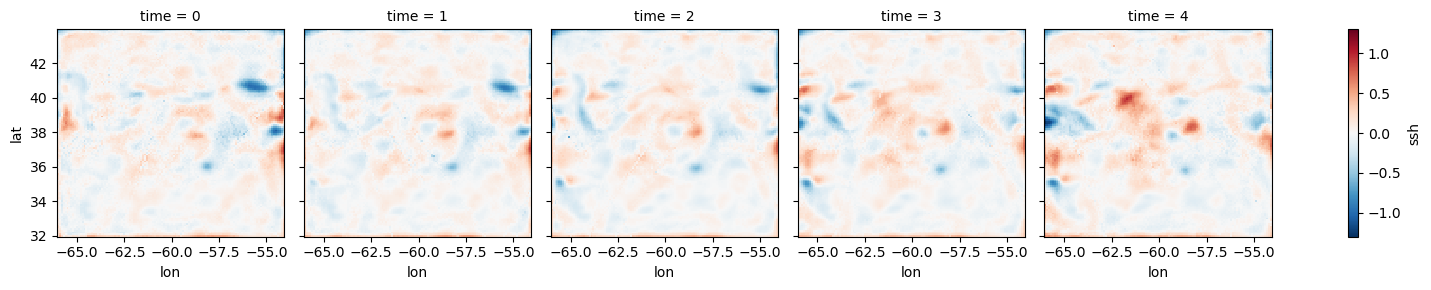

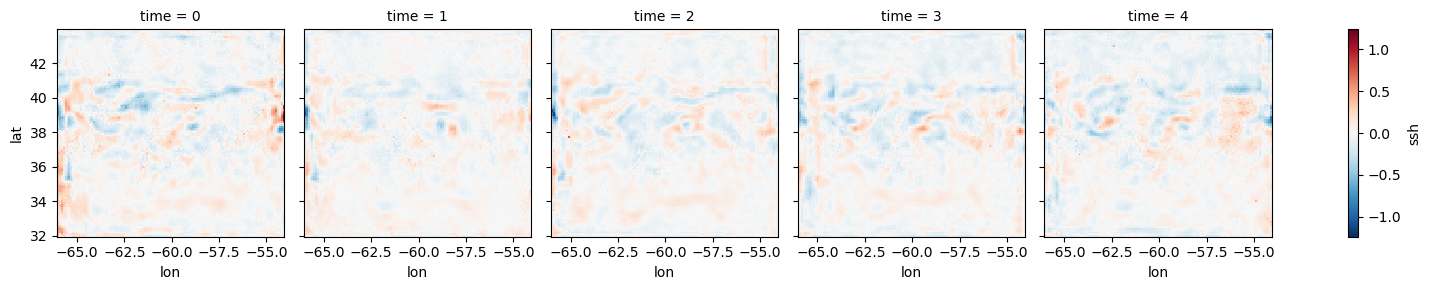

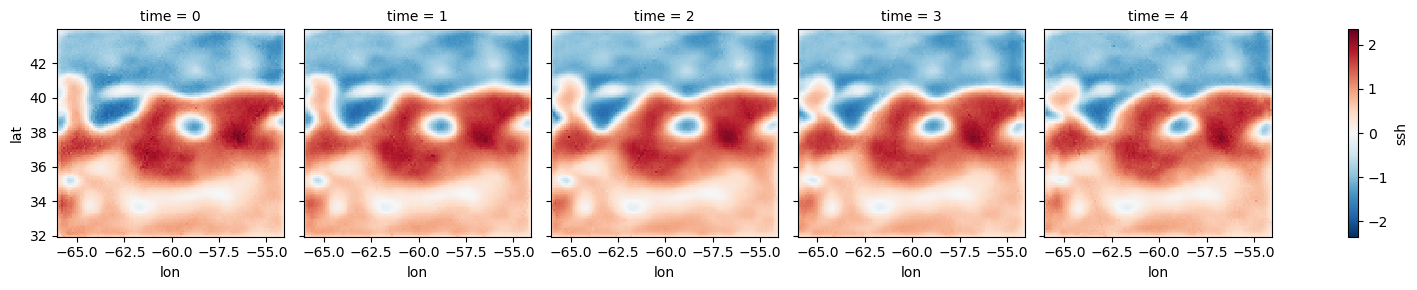

TypeError: 'NoneType' object is not subscriptable

In [7]:
# test
from IPython.display import clear_output
#ckpt = torch.load('../ckpt/ckpt_spde_wonll_rzf=2.pth', map_location=device)
#solver2.load_state_dict(ckpt)
ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2_supervised.pth', map_location=device)
solver.load_state_dict(ckpt)

k = 10
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))
test_batch = test_batch._replace(input=test_batch.input.nan_to_num().to(device))
test_batch = test_batch._replace(tgt=test_batch.tgt.nan_to_num().to(device))

out = solver2(test_batch)
cropped_batch = crop_batch(test_batch)

cropped_batch = cropped_batch._replace(input=test_batch.tgt[:,crop_daw//2:-(crop_daw//2),:,:].to(device)-out[:,crop_daw//2:-(crop_daw//2),:,:]) #
theta = solver(batch=cropped_batch, 
               x_init=cropped_batch.tgt,
               reshape_theta=True)

anom = out-solver2.prior_cost.forward_ae(out)

out = out[:,crop_daw//2:-(crop_daw//2),:,:]
anom = anom[:,crop_daw//2:-(crop_daw//2),:,:]

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),cropped_batch.input[0].detach().cpu())},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time')
plt.show()
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),anom[0].detach().cpu())},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time')
plt.show()
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time')
plt.show()
xr.Dataset(data_vars={'H22':(('time','lat','lon'),np.transpose(np.reshape(theta[2][0,1,1,:,:].detach().cpu(),(120,120,5)),(2,0,1)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).H22.plot(col='time')
plt.show()
xr.Dataset(data_vars={'m1':(('time','lat','lon'),np.transpose(np.reshape(theta[1][0,0,:,:].detach().cpu(),(120,120,5)),(2,0,1)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).m1.plot(col='time')
plt.show()
xr.Dataset(data_vars={'tau':(('time','lat','lon'),np.transpose(np.reshape(theta[3][0,0,:,:].detach().cpu(),(120,120,5)),(2,0,1)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).tau.plot(col='time')
plt.show()
xr.Dataset(data_vars={'kappa':(('time','lat','lon'),np.transpose(np.reshape(theta[0][0,:,:,:].detach().cpu(),(120,120,5)),(2,0,1)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).kappa.plot(col='time')
plt.show()

# Run simulations on the test case

In [ ]:
from IPython.display import clear_output
from sksparse.cholmod import cholesky
import scipy 
import einops

def sparse_torch2scipy(A):
    B = scipy.sparse.csc_matrix((A.coalesce().values(),
                         A.coalesce().indices()),
                         shape=(A.size()[0],A.size()[0]),dtype=np.float64)
    return B

n_b, n_t, n_y, n_x = out.shape
nb_nodes = n_x*n_y
dx = dy = dt = 1

# run n_simu non-conditional simulation
I = sparse_eye(nb_nodes)
        
spde = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")
    
Q = spde(theta[0],theta[1],theta[2],theta[3],
         store_block_diag=False)

n_simu = 10
x_simu = []
for ibatch in range(n_b):
    Q_ = Q[ibatch].detach().cpu()
    Q_sp = sparse_torch2scipy(Q_)
    factor = cholesky(Q_sp,ordering_method='natural')
    if solver.nll.downsamp is not None:
        RM = factor.apply_P(torch.randn((nb_nodes//(solver.nll.downsamp**2))*n_t,n_simu))
    else:
        RM = factor.apply_P(torch.randn(nb_nodes*n_t,n_simu))
    x_simu_ = torch.FloatTensor(factor.solve_Lt(RM,
                                                use_LDLt_decomposition=False)).to(device)
    if solver.nll.downsamp is not None:
        x_simu_ = torch.squeeze(torch.stack([solver.nll.up(torch.reshape(x_simu_[:,i],(1,n_t,n_x//solver.nll.downsamp,n_y//solver.nll.downsamp))) for i in range(n_simu)],dim=4),
                                dim=0)
    else:
        x_simu_ = torch.reshape(x_simu_,(n_t,n_x,n_y,n_simu))
    x_simu.append(x_simu_) 
x_simu = torch.stack(x_simu,dim=0).to(device)

# interpolate the simulation based on LSTM-solver
x_simu_cond = []
x_itrp_simu = []
for i in range(n_simu):
    # !! S_NC = out + anomaly 
    inputs_simu = out.clone()  + x_simu[:,:,:,:,i]
    inputs_obs_simu = out.clone()  + x_simu[:,:,:,:,i]
    # increase size of simu_batch
    inputs_simu = torch.cat((einops.repeat(inputs_simu[:,0,:,:], 'b y x -> b t y x', t=int(crop_daw//2)),
                             inputs_simu,
                             einops.repeat(inputs_simu[:,-1,:,:], 'b y x -> b t y x', t=int(crop_daw//2))),dim=1)
    inputs_obs_simu = torch.cat((einops.repeat(inputs_simu[:,0,:,:], 'b y x -> b t y x', t=int(crop_daw//2)),
                             inputs_obs_simu,
                             einops.repeat(inputs_simu[:,-1,:,:], 'b y x -> b t y x', t=int(crop_daw//2))),dim=1)  
    mask = (test_batch.input!=0)
    inputs_obs_simu[~mask] = 0.
    simu_batch = test_batch
    simu_batch = simu_batch._replace(input=inputs_obs_simu)
    simu_batch = simu_batch._replace(tgt=inputs_simu)
    # itrp non-conditional simulations (solver 2 is enough)
    x_itrp_simu_ = solver2(simu_batch)
    x_itrp_simu_ = x_itrp_simu_[:,crop_daw//2:-(crop_daw//2),:,:] 
    x_itrp_simu.append(x_itrp_simu_)
    # conditional simulations
    x_simu_cond_ = (simu_batch.tgt[:,crop_daw//2:-(crop_daw//2),:,:] - x_itrp_simu_) + out
    x_simu_cond.append(x_simu_cond_)
x_itrp_simu = torch.stack(x_itrp_simu,dim=4).to(device)
x_simu_cond = torch.stack(x_simu_cond,dim=4).to(device)

In [ ]:
from IPython.display import clear_output
import cmocean as cmo
from matplotlib import colormaps as clm

cm = clm.get_cmap('plasma')
cm = cmo.cm.deep

xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(test_batch.tgt[:1,crop_daw//2:-(crop_daw//2),:,:].detach().cpu(),(9-crop_daw, 120,120)))},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(vmin=-1.5,vmax=1.5,col='time')#
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),(out[0,:,:,:]).detach().cpu().numpy())},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),(out[0,:,:,:]+x_simu[0,:,:,:,0]).detach().cpu().numpy())},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
inp = np.reshape(test_batch.input[:1,crop_daw//2:-(crop_daw//2),:,:].detach().cpu(),(9-crop_daw, 120,120))
inp[inp==0] = np.nan
xr.Dataset(data_vars={'simu':(('time','lat','lon'),inp)},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(vmin=-1.5,vmax=1.5,col='time')#
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),(test_batch.tgt[0,crop_daw//2:-(crop_daw//2):,:]-out)[0,:,:,:].detach().cpu().numpy())},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(cmap=cm,col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:1,:,:,:,0].detach().cpu(),(9-crop_daw, 120,120)))},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(cmap=cm,col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:1,:,:,:,1].detach().cpu(),(9-crop_daw, 120,120)))},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(cmap=cm,col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:1,:,:,:,2].detach().cpu(),(9-crop_daw, 120,120)))},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(cmap=cm,col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:1,:,:,:,3].detach().cpu(),(9-crop_daw, 120,120)))},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(cmap=cm,col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:1,:,:,:,4].detach().cpu(),(9-crop_daw, 120,120)))},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(cmap=cm,col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_itrp_simu[:1,:,:,:,0].detach().cpu(),(9-crop_daw, 120,120)))},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu_cond[:1,:,:,:,0].detach().cpu(),(9-crop_daw, 120,120)))},
           coords={'time':np.arange(9-crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()

# Run test dataset, output NetCDF and metrics

In [10]:
train_data = load_altimetry_data("/Odyssey/private/m19beauc/natl_gf_w_5nadirs_swot.nc").sel(time=slice('2013-02-24', '2013-09-30',),
                                                                          lon=slice(lon_min, lon_max,),
                                                                          lat=slice(lat_min, lat_max,))

0/22
1/22
2/22
3/22
4/22
5/22
6/22
7/22
8/22
9/22
10/22
11/22
12/22
13/22
14/22
15/22
16/22
17/22
18/22
19/22
20/22
21/22


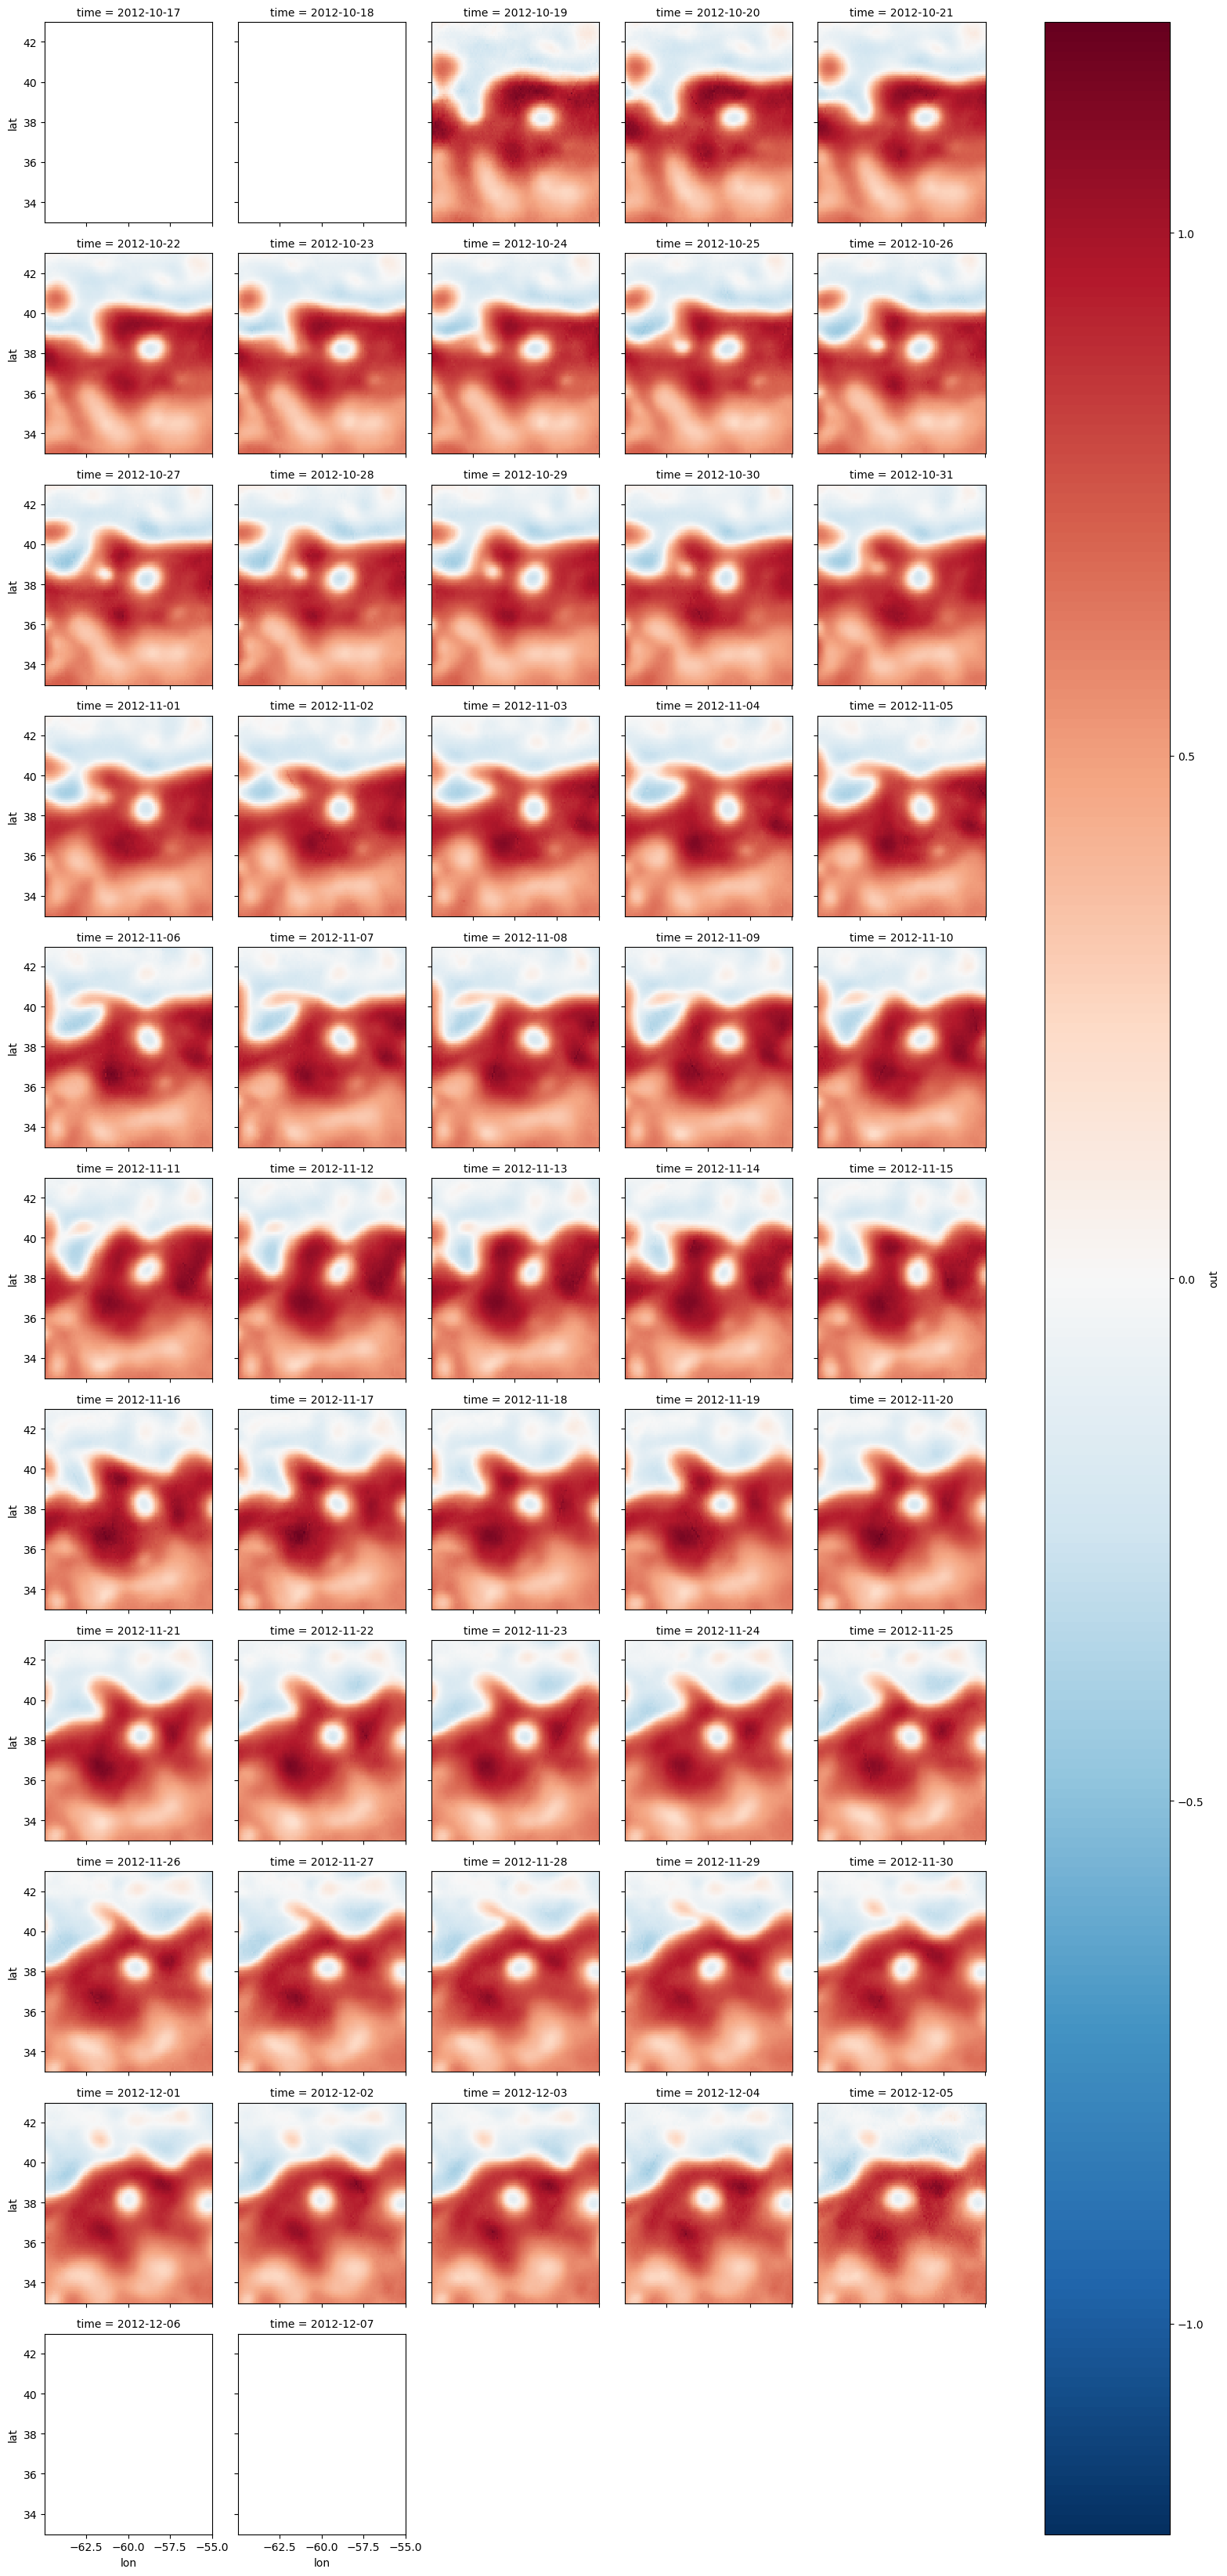

In [12]:
ckpt = torch.load('../ckpt/ckpt_spde_wonll_rzf=2.pth', map_location=device)
solver2.load_state_dict(ckpt)
ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2.pth', map_location=device)
solver.load_state_dict(ckpt)

test_data = []
test_simu = []
test_params = []

test_dataloader = datamodule.test_dataloader()

def test_quantities(self):
    return ['inp', 'tgt', 'out']

def test_simu_quantities(self):
    return ['sample_x', 'mx', 'sample_xy']

def test_params_quantities(self):
        return ['kappa', 'm1', 'm2', 'H11', 'H12', 'H21', 'H22', 'tau']

def norm_stats(train_data, variable='tgt'):
    return train_data.sel(variable=variable).pipe(lambda da: (da.mean().values.item(), da.std().values.item()))

m, s = norm_stats(train_data)

if solver.nll.downsamp is not None:
    spde = Prior_SPDE([n_t,n_y//solver.nll.downsamp,n_x//solver.nll.downsamp],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")    
else:
    spde = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")    

n_simu = 100
factor = None
for k in range(len(test_dataloader)):
    print(str(k)+'/'+str(len(test_dataloader)))
    test_batch = next(itertools.islice(test_dataloader, k, None))
        
    test_batch_ = test_batch
    test_batch_ = test_batch_._replace(input=test_batch_.input.nan_to_num().to(device))
    test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.nan_to_num().to(device))
        
    # 4DVarNets scheme  
    out = solver2(test_batch_)
    cropped_batch = crop_batch(test_batch_)
    # provide mu as coarse version of 4DVarNet outputs
    mean = up(down(out))
    cropped_batch = cropped_batch._replace(input=test_batch_.tgt[:,crop_daw//2:-(crop_daw//2),:,:].to(device)) # 
    out_spde, theta = solver(batch=cropped_batch, 
                    #x_init=out[:,crop_daw//2:-(crop_daw//2),:,:].detach(),
                    #mu=mean[:,crop_daw//2:-(crop_daw//2),:,:].detach())
                    x_init=test_batch_.tgt[:,crop_daw//2:-(crop_daw//2),:,:].detach(),
                    mu=out[:,crop_daw//2:-(crop_daw//2),:,:].detach())
    out = out[:,crop_daw//2:-(crop_daw//2),:,:]#
    if not out_as_first_guess:
        out = out_spde
        
    n_b, n_t, n_y, n_x = out.shape
    nb_nodes = n_x*n_y
    dx = dy = dt = 1
    
    test_data.append(torch.stack(
        [
            crop_batch(test_batch_).input.cpu() * s + m,
            crop_batch(test_batch_).tgt.cpu() * s + m,
            out.squeeze(dim=-1).detach().cpu() * s + m,
        ],
        dim=1,
    ))
        
    # run n_simu non-conditional simulations
    if solver.nll.downsamp is not None: 
        theta[0],theta[1],theta[2],theta[3] = solver.nll.downsamp_params(theta[0],theta[1],theta[2],theta[3],
                                                         sp_dims=[n_y, n_x])
    Q = spde(theta[0],theta[1],theta[2],theta[3],
             store_block_diag=False)

    x_simu = []
    for ibatch in range(n_b):
        Q_ = Q[ibatch].detach().cpu()
        Q_sp = sparse_torch2scipy(Q_)
        if factor is None:
            factor = cholesky(Q_sp,ordering_method='natural')
        else:
            factor.cholesky_inplace(Q_sp)        
        if solver.nll.downsamp is not None:
            RM = factor.apply_P(torch.randn((nb_nodes//(solver.nll.downsamp**2))*n_t,n_simu))
        else:
            RM = factor.apply_P(torch.randn(nb_nodes*n_t,n_simu))
        x_simu_ = torch.FloatTensor(factor.solve_Lt(RM,
                                                    use_LDLt_decomposition=False)).to(device)
        if solver.nll.downsamp is not None:
            x_simu_ = torch.squeeze(torch.stack([solver.nll.up(torch.reshape(x_simu_[:,i],(1,n_t,n_x//solver.nll.downsamp,n_y//solver.nll.downsamp))) for i in range(n_simu)],dim=4),
                                dim=0)
        else:
            x_simu_ = torch.reshape(x_simu_,(n_t,n_x,n_y,n_simu))
        x_simu.append(x_simu_)
    x_simu = torch.stack(x_simu,dim=0).to(device)

    if solver.nll.downsamp is not None:
        theta[0],theta[1],theta[2],theta[3]  = solver.nll.upsamp_params(theta[0],theta[1],theta[2],theta[3] ,
                                                          sp_dims=[n_y//solver.nll.downsamp, 
                                                                   n_x//solver.nll.downsamp])
    
    # interpolate the simulation based on LSTM-solver
    x_simu_cond = []
    x_simu_itrp = []
    for i in range(n_simu):
        # !! S_NC = out + anomaly 
        inputs_simu = out.clone()  + smooth(x_simu[:,:,:,:,i])
        inputs_obs_simu = out.clone()  + smooth(x_simu[:,:,:,:,i])
        # increase size of simu_batch
        inputs_simu = torch.cat((einops.repeat(inputs_simu[:,0,:,:], 'b y x -> b t y x', t=int(crop_daw//2)),
                             inputs_simu,
                             einops.repeat(inputs_simu[:,-1,:,:], 'b y x -> b t y x', t=int(crop_daw//2))),dim=1)
        inputs_obs_simu = torch.cat((einops.repeat(inputs_simu[:,0,:,:], 'b y x -> b t y x', t=int(crop_daw//2)),
                             inputs_obs_simu,
                             einops.repeat(inputs_simu[:,-1,:,:], 'b y x -> b t y x', t=int(crop_daw//2))),dim=1)   
        mask = (test_batch_.input!=0)
        inputs_obs_simu[~mask] = 0.
        simu_batch = test_batch_
        simu_batch = simu_batch._replace(input=inputs_obs_simu)
        simu_batch = simu_batch._replace(tgt=inputs_simu)
        # itrp non-conditional simulations (solver 2 is enough)
        x_itrp_simu_ = solver2(simu_batch).detach()
        x_itrp_simu_ = x_itrp_simu_[:,crop_daw//2:-(crop_daw//2),:,:] 
        x_simu_itrp.append(x_itrp_simu_)
        # conditional simulations
        x_simu_cond_ = (simu_batch.tgt[:,crop_daw//2:-(crop_daw//2),:,:] - x_itrp_simu_) + out.detach()
        x_simu_cond.append(x_simu_cond_)
    x_simu_itrp = torch.stack(x_simu_itrp,dim=4).to(device).detach().cpu()                
    x_simu_cond = torch.stack(x_simu_cond,dim=4).to(device).detach().cpu() 
        
    test_simu.append(torch.stack(
            [
                x_simu.detach().cpu(),
                x_simu_itrp,
                x_simu_cond * s + m,
            ],
            dim=1,
        ))  
        
    # reshape parameters as maps
    kappa = torch.reshape(theta[0],(len(out),1,n_x,n_y,n_t))
    ma = torch.reshape(theta[1],(len(out),2,n_x,n_y,n_t))
    H = torch.reshape(theta[2],(len(out),2,2,n_x,n_y,n_t))
    tau = torch.reshape(theta[3],(len(out),1,n_x,n_y,n_t))
    kappa = torch.permute(kappa,(0,4,2,3,1))
    kappa = kappa[:,:,:,:,0]
    ma = torch.permute(ma,(0,4,2,3,1))
    m1 = ma[:,:,:,:,0]
    m2 = ma[:,:,:,:,1]
    H = torch.permute(H,(0,5,3,4,1,2))
    H11 = H[:,:,:,:,0,0]
    H12 = H[:,:,:,:,0,1]
    H21 = H[:,:,:,:,1,0]
    H22 = H[:,:,:,:,1,1]
    tau = torch.permute(tau,(0,4,2,3,1))
    tau = tau[:,:,:,:,0]
        
    test_params.append(torch.stack(
            [
                kappa.detach().cpu(),
                m1.detach().cpu(),
                m2.detach().cpu(),
                H11.detach().cpu(),
                H12.detach().cpu(),
                H21.detach().cpu(),
                H22.detach().cpu(),
                tau.detach().cpu()
            ],
            dim=1,
        ))       

# reconstruct mean
if isinstance(test_dataloader,list):
    rec_da = test_dataloader[0].dataset.reconstruct(
            test_data, rec_weight.cpu().numpy(), crop=crop_daw
    )
else:
    rec_da = test_dataloader.dataset.reconstruct(
            test_data, rec_weight.cpu().numpy(), crop=crop_daw
    )
rec_da = test_dataloader.dataset.reconstruct(test_data, rec_weight.cpu().numpy(), crop=crop_daw)
test_data = rec_da.assign_coords(
            dict(v0=test_quantities)
        ).to_dataset(dim='v0').isel(lon=slice(10,110),lat=slice(10,110))

# reconstruct parameters
if isinstance(test_dataloader,list):
    rec_params = test_dataloaders[0].dataset.reconstruct(
            test_params, rec_weight.cpu().numpy(), crop=crop_daw
    )
else:
    rec_params = test_dataloader.dataset.reconstruct(
                test_params, rec_weight.cpu().numpy(), crop=crop_daw
    )
rec_params = test_dataloader.dataset.reconstruct(
                test_params, rec_weight.cpu().numpy(), crop=crop_daw
             )
test_params = rec_params.assign_coords(
            dict(v0=test_params_quantities)
        ).to_dataset(dim='v0').isel(lon=slice(10,110),lat=slice(10,110))

# reconstruct simulations
rec_da_wsimu = []
for i in range(n_simu):
    if isinstance(test_dataloader,list):
        rec_simu = test_dataloader[0].dataset.reconstruct(
            [ts[:,:,:,:,:,i] for ts in test_simu], rec_weight.cpu().numpy(), crop=crop_daw
        )
    else:
        rec_simu = test_dataloader.dataset.reconstruct(
            [ts[:,:,:,:,:,i] for ts in test_simu], rec_weight.cpu().numpy(), crop=crop_daw
        )
    rec_simu = test_dataloader.dataset.reconstruct(
            [ts[:,:,:,:,:,i] for ts in test_simu], rec_weight.cpu().numpy(), crop=crop_daw
        )
    rec_da_wsimu.append(rec_simu)
if len(rec_da_wsimu)>1:
    test_simu = xr.concat(rec_da_wsimu, pd.Index(np.arange(n_simu), name='simu'))
else:
    test_simu = rec_da_wsimu[0]
    
test_simu = test_simu.assign_coords(
            dict(v0=test_simu_quantities)
        ).to_dataset(dim='v0').isel(lon=slice(10,110),lat=slice(10,110))

test_data = xr.merge([test_data,test_simu,test_params])
test_data.out.plot(col="time",col_wrap=5)

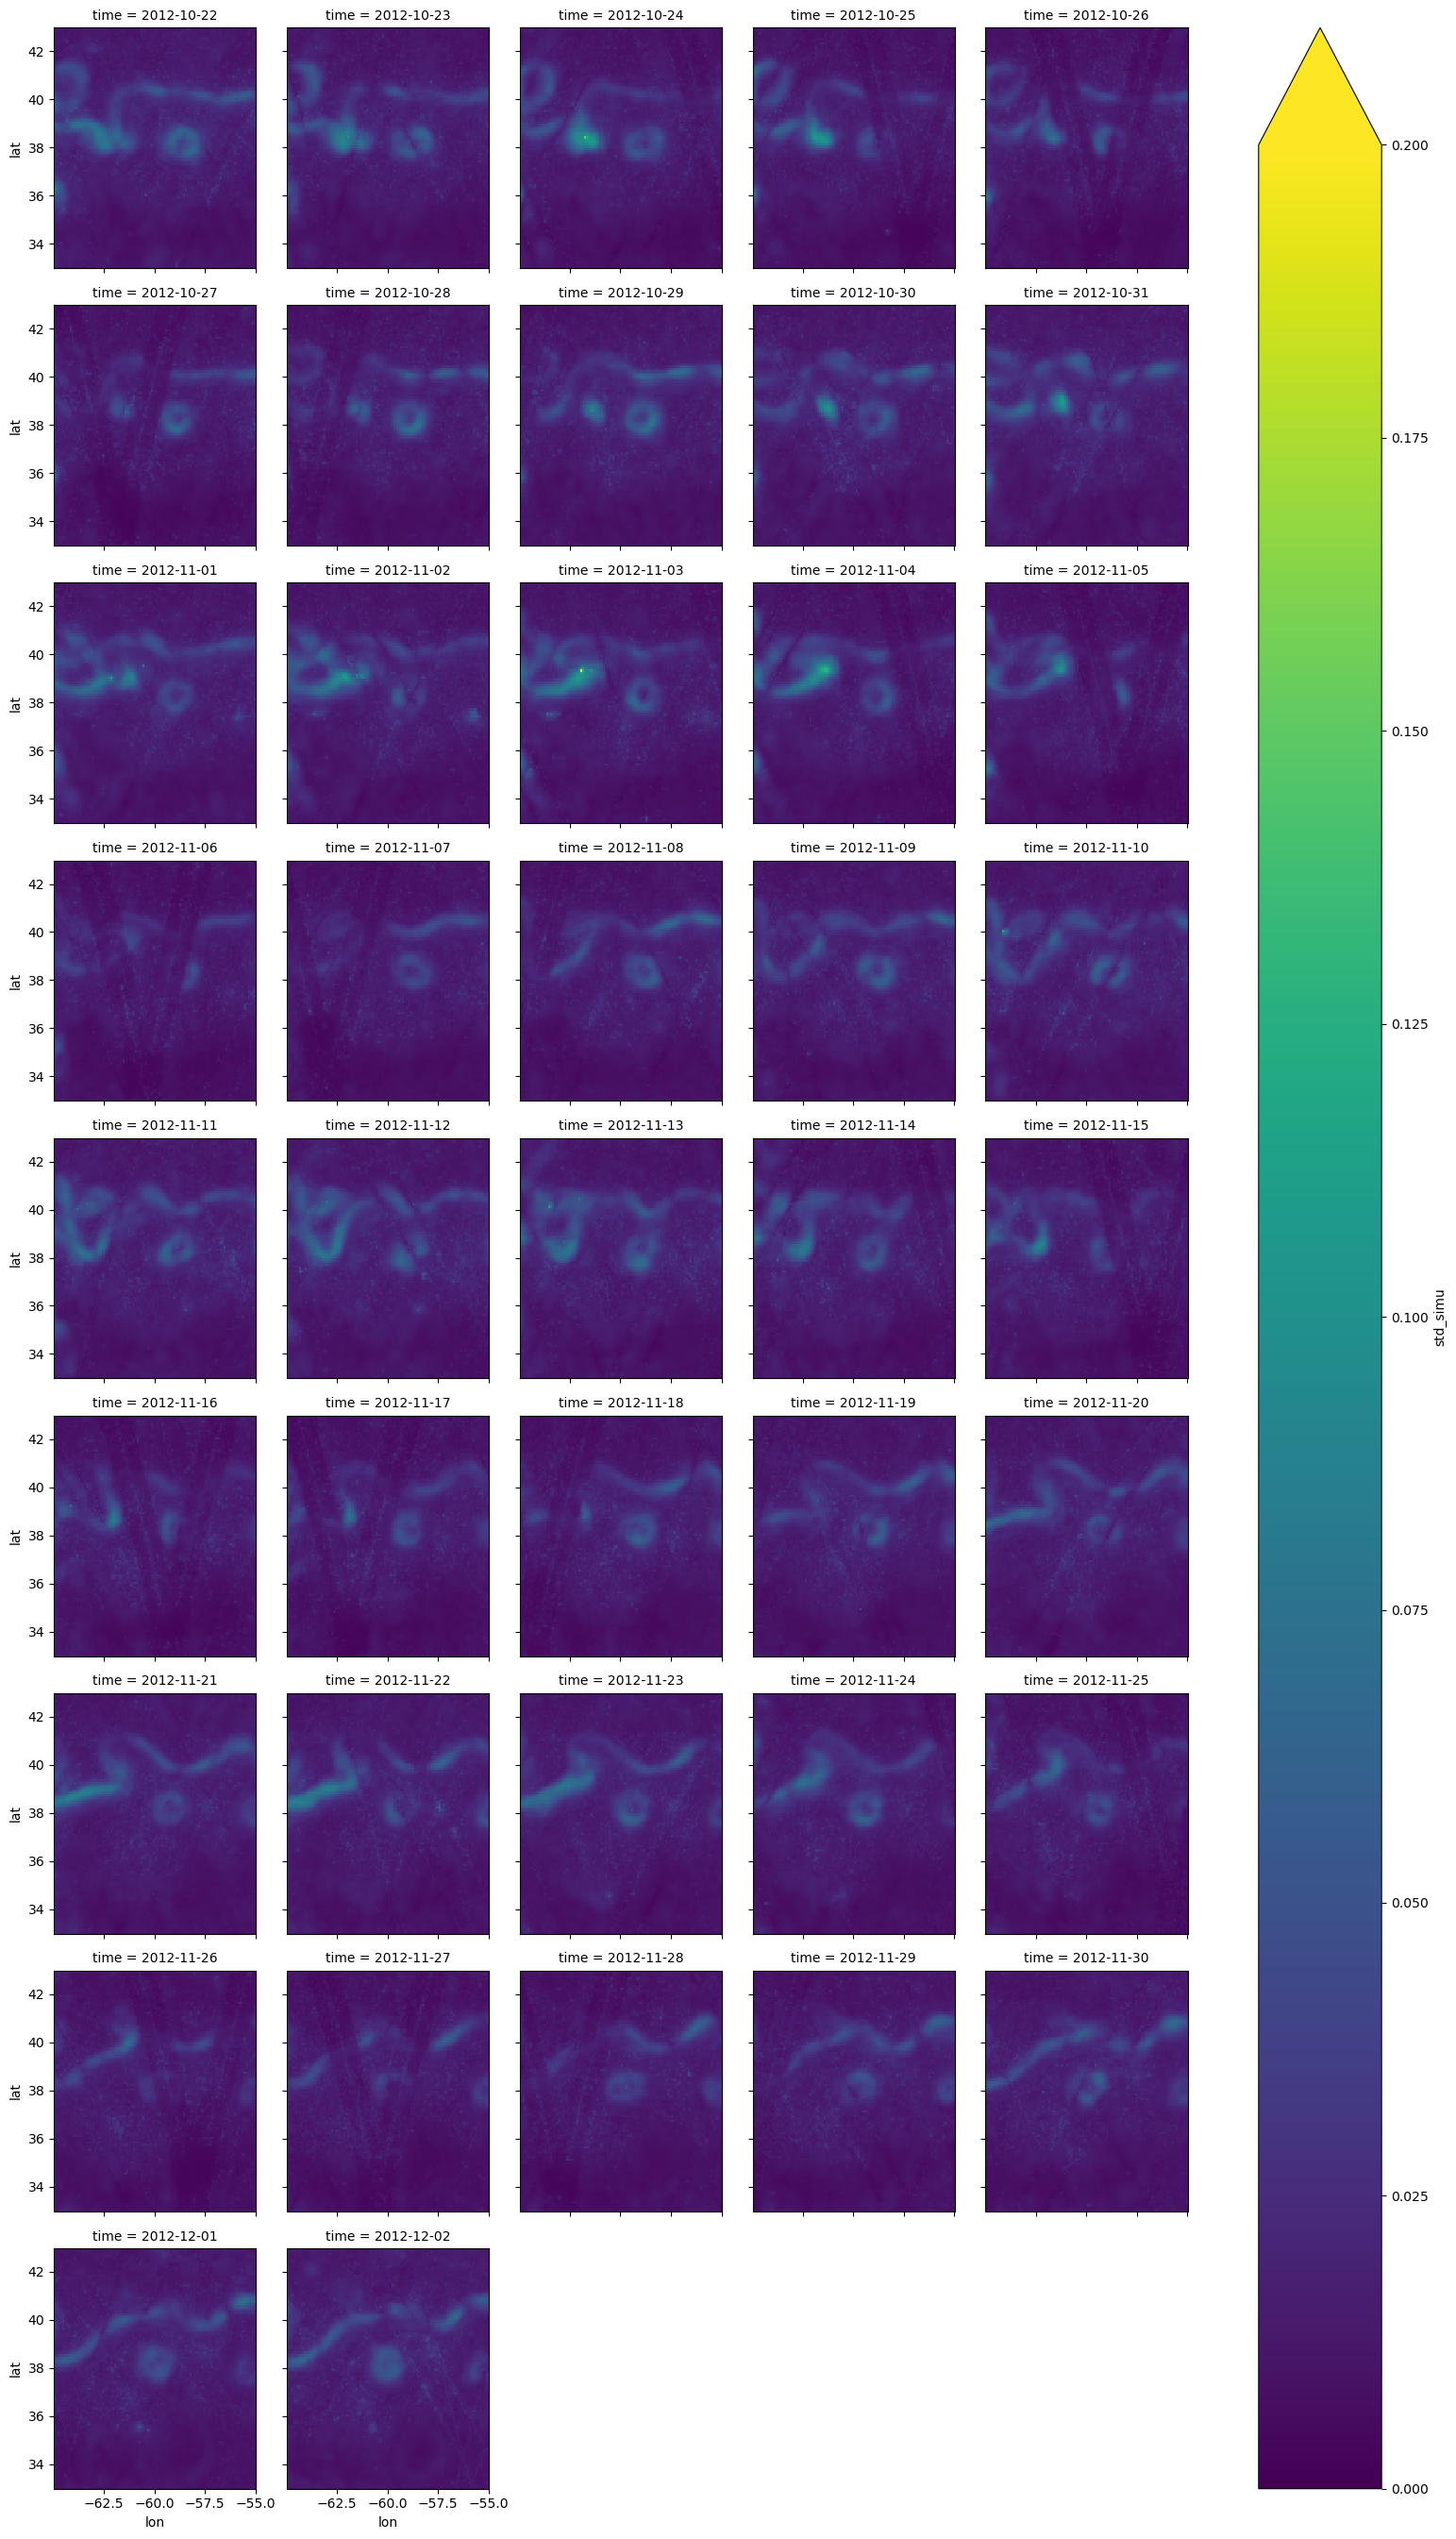

In [13]:
test_data = test_data.update({'std_simu':(('time','lat','lon'),test_data.sample_xy.std(dim='simu').values)})
test_data.std_simu.sel(time=slice('2012-10-22', '2012-12-02',)).plot(col="time",col_wrap=5,vmin=0,vmax=0.2)

In [16]:
from src.utils import rmse_based_scores_from_ds
from src.utils import psd_based_scores_from_ds
mu, sig = rmse_based_scores_from_ds(test_data.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable='out')
lx , lt = psd_based_scores_from_ds(test_data.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable='out')
print(mu,sig,lx,lt)

oi = xr.open_dataset("/Odyssey/private/m19beauc/natl_4nadirs_swot.nc").sel(time=slice('2012-10-17', '2012-12-07',),
                                                                          lon=slice(lon_min, lon_max,),
                                                                          lat=slice(lat_min, lat_max,))
oi = oi.coarsen(lon=2,boundary='trim').mean(skipna=True).coarsen(lat=2,boundary='trim').mean(skipna=True)
test_data_woi = test_data.update({'oi':(('time','lat','lon'),oi.oi_ssh_mod.values[:,10:110,10:110])})
mu, sig = rmse_based_scores_from_ds(test_data_woi.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable='oi')
lx , lt = psd_based_scores_from_ds(test_data_woi.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable='oi')
print(mu,sig,lx,lt)


0.94489 0.00992 1.224 9.374
0.9215 0.01694 1.205 13.893


In [15]:
test_data.sel(time=slice('2012-10-22', '2012-12-02',)).to_netcdf('/Odyssey/private/m19beauc/xp_osse_rzf2.nc')